In [ ]:
import pandas as pd
from tqdm import tqdm
import time
import litellm
import os
import numpy as np
tqdm.pandas()
#from .autonotebook import tqdm as notebook_tqdm
from sacrebleu.metrics import BLEU, CHRF, TER
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import random
import ast
random.seed(42)
from evaluate import load
bertscore = load("bertscore")
chrf = load("chrf")
sacrebleu = load("sacrebleu")
import glob

from litellm import completion
import sys
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from bs4 import BeautifulSoup
import json
from collections import Counter
from common import *
import Levenshtein
from sklearn.metrics import mean_squared_error
# Set the Seaborn style and color palette
sns.set_theme(style="whitegrid")
custom_palette = sns.color_palette("Set2")
import itertools
from collections import defaultdict

# Fluency evaluation

In this notebook, I have annotated up to 10 Europa translations per 15 long Flores sentences with a fluency rating, fluency errors, and the edited sentence. I excluded sentences with hallucinations such that even the dysfluent sentences with some flexibility can be said to encompass the same meaning as the source sentence. An excemption is lexical errors that are included, i.e. a model can output a sentence where a noun is replaced with a non-word or a wrong noun thereby completely changing the sematics of the sentence. These sentences are included. 

The aim is to find a model that is 
- able to distinguish fluent from dysfluent sentences-
- rate dysfluency
- rank sentences by dysfluency
- describe the fluency errors

We have up to ten fluent versions per source sentence. BLEU works better with multiple references

In [ ]:
# set system variables
! source ~/.bashrc

# In this script, set the following variables
#export HUGGINGFACE_API_KEY=xxx
#export OPENAI_API_KEY=xxx
#export GEMINI_API_KEY=xxx
#export GOOGLE_APPLICATION_CREDENTIALS=/scratch/project_462000353/maribarr/.config/gcloud/application_default_credentials.json
#export HF_HOME=/scratch/project_462000353/cache
#export HF_TOKEN=xxx

#! huggingface-cli login --token $HF_TOKEN --add-to-git-credentials

env: DEEPSEEK_API_KEY=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
env: LLAMA_API_KEY=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


## Create file for annotation

In [16]:
# make a set with the longest sentences for annotation 
flores200 = pd.read_json('/pfs/lustrep2/scratch/project_462000353/jburdge/git/compare_translations/flores/flores200_europa_eng_dan.jsonl', lines=True)

flores200['sentence_length'] = flores200['source_sentence'].str.len()

# Sort by this length
flores200_sorted = flores200.sort_values(by='sentence_length')

# If you want to sort in descending order (longest first)
flores200_sorted_desc = flores200.sort_values(by='sentence_length', ascending=False)

flores200_sorted_desc = flores200_sorted_desc.head(15)
sub = flores200_sorted_desc.explode('translations')

#sub = flores200.sample(15)
#sub = sub.explode('translations')
sub.to_csv('../data/flores200_subset_for_annotation.tsv', sep='\t', index=False)

In [4]:
df = pd.read_json('/scratch/project_462000353/maribarr/translation_quality/data/Flores200_dev.jsonl', lines=True)

In [230]:
df.to_json('/scratch/project_462000353/maribarr/translation_quality/data/Flores200_dev.jsonl', lines=True, orient='records')

## Identify the fluent and the dysfluent version from pairwise comparison

In [ ]:
models = ['gpt-4-0125-preview', 'gpt-4o-2024-08-06', 'gpt-4.5-preview-2025-02-27']

cot = False

#models = ['gemini/gemini-2.0-flash', 'gemini/gemini-1.5-pro']
for model in models:
    df[f"{model}_{'cot' if cot else 'pairwise'}"] = df.progress_apply(lambda x: run_rating(translation = x['translations'], correction=x['Correction'], model=model, cot=cot, rating_prompt_func=create_ranking_prompt), axis=1)
    #print(model, df[f'{model}_pairwise'].describe())"""
df.to_json('/scratch/project_462000353/maribarr/translation_quality/data/Flores200_dev.jsonl', lines=True, orient='records')

  0%|          | 0/100 [00:00<?, ?it/s]

translation:   Senere rapporter siger at flyet modtog end bomb trussel og måtte gøre en kvantespring tilbage til Afghanistan, hvorfra det landede i Kandahar.
correction:   Senere rapporter sagde så at flyet modtog en bombetrussel og måtte omdirigeres tilbage til Afghanistan, hvor det landede i Kandahar.


  2%|▏         | 2/100 [00:05<04:25,  2.71s/it]

translation:   Senere rapporterer angiver, at flyet modtog en bombetrussel og blev omdirigeret hjem til Afghanistan, der lander i Kandahar.
correction:   Senere rapporterer angav så, at flyet modtog en bombetrussel og blev omdirigeret tilbage til Afghanistan, hvor det landede i Kandahar.


  3%|▎         | 3/100 [00:10<05:59,  3.70s/it]

translation:   Senere rapporter sagde derefter, at flyet modtog en bombetrussel og blev omdirigeret til Afghanistan, hvor det landede i Kandahar.
correction:   Senere rapporter sagde derefter, at flyet modtog en bombetrussel og blev omdirigeret til Afghanistan, hvor det landede i Kandahar.


  4%|▍         | 4/100 [00:14<06:20,  3.96s/it]

translation:   Senere rapporterer om ændrede de, at flyet var blevet advaret om et muligt bombeanslag og vendte derefter tilbage til Afghanistan og landede i Kandahar.
correction:   Senere rapporter sagde så, at flyet var blevet advaret om et muligt bombeangreb og det vendte derefter tilbage til Afghanistan og landede i Kandahar.


  5%|▌         | 5/100 [00:21<07:51,  4.96s/it]

translation:   Senere rapporterede man om et bombetrussel, hvorefter flyet blev omdirigeret tilbage til Afghanistan og landede i Kandahar.
correction:   Senere rapporterede man om en bombetrussel, hvorefter flyet blev omdirigeret tilbage til Afghanistan og landede i Kandahar.


  6%|▌         | 6/100 [00:30<09:41,  6.19s/it]

translation:   Senere rapporter erklærede, at flyet modtog en bombetrussel og blev omdirigeret tilbage til Afghanistan, landing i Kandahar.
correction:   Senere rapporter erklærede, at flyet modtog en bombetrussel og blev omdirigeret tilbage til Afghanistan, hvor det landede i Kandahar.


  7%|▋         | 7/100 [00:35<09:03,  5.84s/it]

translation:   Efterretninger tilføjede yderligere og sagde senere, at flyet fik en bombe trussel og blev afledt tilbage til Afghanistan, landing i Kandahar.
correction:   Efterretninger tilføjede yderligere, at flyet modtog en bombetrussel og blev omdirigeret tilbage til Afghanistan, hvor det landede i Kandahar.


  8%|▊         | 8/100 [00:42<09:37,  6.28s/it]

translation:   Senere rapporter bekræftede, at flyet modtog en bombetrussel og blev omdirigeret til Afghanistan, hvorefter det landede i Kandahar.
correction:   Senere rapporter bekræftede, at flyet modtog en bombetrussel og blev omdirigeret til Afghanistan, hvorefter det landede i Kandahar.


  9%|▉         | 9/100 [00:49<09:48,  6.47s/it]

translation:   Senere rapporter siger, at flyet modtog en bombetrussel og blev omdirigeret tilbage til Afghanistan, hvor det landede i Kandahar.
correction:   Senere rapporter sagde, at flyet modtog en bombetrussel og blev omdirigeret tilbage til Afghanistan, hvor det landede i Kandahar.


 10%|█         | 10/100 [00:58<10:37,  7.09s/it]

translation:   Senere var der rapporter om, at flyet modtog en bombetruende melding og blev omdirigeret tilbage til Afghanistan, og landede i Kandahar.
correction:   Senere var der rapporter om, at flyet modtog en bombetrussel og blev omdirigeret tilbage til Afghanistan, og landede i Kandahar.


 11%|█         | 11/100 [01:04<10:11,  6.88s/it]

translation:   Bekendtgørelsen kom efter, at Trump havde haft en telefonsamtale med den tyrkiske præsident Recep Tayyip Erdoğan.
correction:   Bekendtgørelsen kom efter, at Trump havde haft en telefonsamtale med den tyrkiske præsident Recep Tayyip Erdoğan.


 12%|█▏        | 12/100 [01:09<09:13,  6.29s/it]

translation:   Udmeldelsen kom, efter Trump havde en telefonsamtale med Tyrkiets præsident, Recep Tayyip Erdoğan.
correction:   Udmeldingen kom, efter Trump havde en telefonsamtale med Tyrkiets præsident, Recep Tayyip Erdoğan.


 13%|█▎        | 13/100 [01:16<09:17,  6.41s/it]

translation:   Bekendtgørelsen blev foretaget, efter at Trump havde en telefonsamtale med Tyrkiets præsident Recep Tayyip Erdoğan.
correction:   Bekendtgørelsen blev givet, efter at Trump havde en telefonsamtale med Tyrkiets præsident Recep Tayyip Erdoğan.


 14%|█▍        | 14/100 [01:25<10:27,  7.29s/it]

translation:   Erklæringen blev fremsat efter, at Trump havde haft en telefonsamtale med Tyrkiets præsident, Recep Tayyip Erdoğan.
correction:  Udmeldingen blev givet, efter at Trump havde haft en telefonsamtale med Tyrkiets præsident, Recep Tayyip Erdoğan.


 15%|█▌        | 15/100 [01:31<09:45,  6.89s/it]

translation:   Meddelelsen kom efter, at Trump havde en telefonsamtale med den tyrkiske præsident Recep Tayyip Erdoğan.
correction:   Meddelelsen kom efter, at Trump havde en telefonsamtale med den tyrkiske præsident Recep Tayyip Erdoğan.


 16%|█▌        | 16/100 [01:37<09:09,  6.54s/it]

translation:   Nyheden blev offentliggjort efter, at Trump havde haft en telefonsamtale med Tyrkiets præsident Recep Tayyip Erdoğan.
correction:   Nyheden blev offentliggjort efter, at Trump havde haft en telefonsamtale med Tyrkiets præsident Recep Tayyip Erdoğan.


 17%|█▋        | 17/100 [01:42<08:40,  6.27s/it]

translation:   Udmeldingen blev foretaget, efter Trump havde en telefonsamtale med Tyrkiets præsident Recep Tayyip Erdoğan.
correction:   Udmeldingen blev foretaget, efter Trump havde en telefonsamtale med Tyrkiets præsident Recep Tayyip Erdoğan.


 18%|█▊        | 18/100 [01:48<08:29,  6.21s/it]

translation:   Budskabet kom, da Trump havde telefonisk kontakt med Tyrkiets præsident Recep Tayyip Erdoğan.
correction:   Udmeldingen  kom efter Trump havde telefonisk kontakt med Tyrkiets præsident Recep Tayyip Erdoğan.


 19%|█▉        | 19/100 [01:57<09:25,  6.98s/it]

translation:   Meddelelsen kom efter, at Trump havde foretaget en telefonisk samtale med Tyrkiets præsident, Recep Tayyip Erdoğan.
correction:   Meddelelsen kom efter, at Trump havde foretaget en telefonsamtale med Tyrkiets præsident, Recep Tayyip Erdoğan.


 20%|██        | 20/100 [02:05<09:43,  7.29s/it]

translation:   Deres termiske ​​adfærd er ikke så stabil som store huler på jorden, der ofte holder en forholdsvis konstant temperatur, men det er konsistent, at hulerne her er dybe huller i jorden", sagde Glenn Cushing fra USGS Astrogeology Team og fra Northern Arizona University, lokaliseret i Flagstaff, Arizona.
correction:   Deres termiske ​​opførsel er ikke så stabil som store huler på jorden, der ofte holder en forholdsvis konstant temperatur, men det passer med at hulerne her er dybe huller i jorden", sagde Glenn Cushing fra USGS Astrogeology Team og fra Northern Arizona University, Flagstaff, Arizona.


 21%|██        | 21/100 [02:11<08:58,  6.82s/it]

translation:   Deres termiske adfærd er ikke så stabil som dybe huler på jorden, som ofte har en nogenlunde konstant temperatur, men det er i overensstemmelse med at disse er dybe huller i jorden, sagde Glen Cushing fra den amerikanske Geologiske Undersøgelses (USGS) Astrogeologi Team og fra Northern Arizona University med base i Flagstaff, Arizona.
correction:   Deres termiske opførsel er ikke så stabil som dybe huler på jorden, som ofte har en nogenlunde konstant temperatur, men det er i overensstemmelse med at disse er dybe huller i jorden, sagde Glen Cushing fra den amerikanske Geologiske Undersøgelses (USGS) Astrogeologi Team og fra Northern Arizona University, Flagstaff, Arizona.


 22%|██▏       | 22/100 [02:19<09:15,  7.13s/it]

translation:   Deres termiske adfærd er ikke så fast som på Jordens store huler (cave), som ofte har en forholdsvis konstant temperatur, men det stemmer overens med, at der er tale om dybgrave i jorden," sagde Glen Cushing, fra USGS' Astrogeologi-gruppe, og fra Northern Arizona Universitet i Flagstaff, Arizona.
correction:  Deres termiske opførsel er ikke så konsistent som i Jordens store huler, som ofte har en forholdsvis konstant temperatur, men det stemmer overens med, at der er tale om dybe huller i jorden," sagde Glen Cushing, fra USGS' Astrogeologi-gruppe, og fra Northern Arizona Universitet i Flagstaff, Arizona.


 23%|██▎       | 23/100 [02:24<08:18,  6.47s/it]

translation:   Deres termiske adfærd er ikke så stabil som de store huler på Jorden, som ofte opretholder en næsten konstant temperatur, men det er konsekvent med, at disse er dybe huller i jorden," sagde Glen Cushing fra USGS Astrogeologi Team og fra Northern Arizona University, som ligger i Flagstaff, Arizona.
correction:   Deres termiske opførsel er ikke så stabil som de store huler på Jorden, som ofte opretholder en næsten konstant temperatur, men det passer med, at disse er dybe huller i jorden," sagde Glen Cushing fra USGS Astrogeologi Team og fra Northern Arizona University, Flagstaff, Arizona.


 24%|██▍       | 24/100 [02:32<08:57,  7.07s/it]

translation:   Deres termiske adfærd (temperaturudvikling) er ikke så konstant som i store huler på Jorden, som ofte opretholder en rimelig konstant temperatur, men den er i overensstemmelse med, at disse er dybe huller i jorden.
correction:  Deres termiske opførsel er ikke så konstant som i store huler på Jorden, som ofte opretholder en rimelig konstant temperatur, men den er i overensstemmelse med, at disse er dybe huller i jorden, sagde Glen Cushing fra USGS Astrogeologi Team og fra Northern Arizona University, Flagstaff, Arizona..


 25%|██▌       | 25/100 [02:38<08:33,  6.84s/it]

translation:   Temperaturen svinger ikke lige så meget i dem som i store huler på Jorden, men den er i tråd med det, at de har været dybe gruber i jorden,” fortalte Glen Cushing fra USGS Astrogeology Team og Northern Arizona University, som har base i Flagstaff, Arizona.
correction:   Temperaturen svinger mere i dem end i store huler på Jorden, men den er i tråd med det, at de er dybe gruber i jorden,” fortalte Glen Cushing fra USGS Astrogeology Team og Northern Arizona University, Flagstaff, Arizona.


 26%|██▌       | 26/100 [02:45<08:17,  6.72s/it]

translation:   Deres termiske adfærd er ikke så konstant som de store huler på jorden, der ofte opretholder en forholdsvis konstant temperatur, men det er i overensstemmelse med disse er dybe huler i jorden, "sagde Glen Cushing af den amerikanske Geological Survey (USGS) starfelt team og North Arizona University, der ligger i Flagstaff , Arizona.
correction:   Deres termiske opførsel er ikke så konstant som de store huler på jorden, der ofte opretholder en forholdsvis konstant temperatur, men det er i overensstemmelse med at disse er dybe huler i jorden, "sagde Glen Cushing af den amerikanske Geological Survey (USGS) starfelt team og North Arizona University, Flagstaff , Arizona.


 27%|██▋       | 27/100 [02:52<08:12,  6.75s/it]

translation:   Den termiske adfærd er ikke så stabil som hulerne på Jorden, som ofte fastholder en næsten konstant temperatur, men det er i overensstemmelse med disse dybhuller i jorden,« siger Glen Cushing fra USGS Astrogeology Team og fra Northern Arizona University beliggende i Flagstaff, Arizona.
correction:   De termiske observationer er ikke så stabile som i de store huler på Jorden, som ofte opretholder en næsten konstant temperatur, men det er i overensstemmelse med at disse er dybe huller i jorden,« siger Glen Cushing fra USGS Astrogeology Team og fra Northern Arizona University, Flagstaff, Arizona.


 28%|██▊       | 28/100 [02:56<07:23,  6.15s/it]

translation:   Den termiske adfærd er ikke så stabil som store huler på Jorden, der ofte opretholder en forholdsvis konstant temperatur, men det er i tråd med dem er dybe huller i jorden," sagde Glen Cushing fra de Forenede USA Geologiske Survey (USGS) Astrogeologi Team og på Northern Arizona University beliggende i Flagstaff, Arizona.
correction:   Den termiske opførsel er ikke så stabil som store huler på Jorden, der ofte opretholder en forholdsvis konstant temperatur, men det er i tråd med at disse er dybe huller i jorden," sagde Glen Cushing fra USA's Geologiske Survey (USGS) Astrogeologi Team og fra Northern Arizona University, Flagstaff, Arizona.


 29%|██▉       | 29/100 [03:03<07:17,  6.16s/it]

translation:   Deres termiske adfærd er ikke så stabil som store huler på Jorden, som ofte holder en forholdsvis konstant temperatur, men det er i overensstemmelse med disse at være dybe huller i jorden," siger Glen Cushing fra USAs Geologiske Undersøgelse (USGS) Astrogeologi Hold og fra Northern Arizona Universitet ligger i Flagstaf, Arizona.
correction:   Deres termiske opførsel er ikke så stabil som store huler på Jorden, som ofte holder en forholdsvis konstant temperatur, men det er i overensstemmelse med at disse er dybe huller i jorden," siger Glen Cushing fra USAs Geologiske Undersøgelse (USGS) Astrogeologi Team og fra Northern Arizona Universitet, Flagstaf, Arizona.


 30%|███       | 30/100 [03:11<07:48,  6.69s/it]

translation:   Deres termiske opførsel er ikke så konstant som dybe, store huler på Jorden, som ofte opretholder en forholdsvis konstant temperatur, men de stemmer overens med, at dette er dybe, huler i jorden, sagde Glen Cushing fra USGS’s Astrogeology Team og fra Northern Arizona University i Flagstaff, Arizona.
correction:   Deres termiske opførsel er ikke så konstant som dybe, store huler på Jorden, som ofte opretholder en forholdsvis konstant temperatur, men de stemmer overens med, at dette er dybe huler i jorden, sagde Glen Cushing fra USGS’s Astrogeology Team og fra Northern Arizona University i Flagstaff, Arizona.


 31%|███       | 31/100 [03:15<06:52,  5.97s/it]

translation:   Deres termiske opførsel er ikke så stabil som større huler på Jorden, som ofte opretholder en forholdsvis konstant temperatur, men er i overensstemmelse med disse er dybe huller i jorden, "sagde Glen Cushing fra United States Geological Survey (USGS) Astrogeology Team og fra Northern Arizona University beliggende i Flagstaff, Arizona.
correction:   Deres termiske opførsel er ikke så stabil som større huler på Jorden, som ofte opretholder en forholdsvis konstant temperatur, men er i overensstemmelse med disse er dybe huller i jorden, "sagde Glen Cushing fra United States Geological Survey (USGS) Astrogeology Team og fra Northern Arizona University, Flagstaff, Arizona.


 32%|███▏      | 32/100 [03:23<07:35,  6.69s/it]

translation:   Den faste sekretær for Nobelkomiteen for Litteratur ved den Svenske Akademi, Sara Danius, offentliggjorde på mandag under et radioprogram for Sveriges Radio i Sverige på Sveriges Radio, at komiteen, som manglede evne til at rette kontakten til Bob Dylan for at gratulere ham med Nobelprisen i Litteratur for 2016et, havde opgivet forsøgene på at nå ham.
correction:   Den permanente sekretær for Nobelkomiteen for Litteratur ved den Svenske Akademi, Sara Danius, offentliggjorde i mandags under et radioprogram for Sveriges Radio, at komiteen, som ikke havde kunnet få kontakt til Bob Dylan for at lykønske ham med Nobelprisen i Litteratur i 2016, havde opgivet forsøgene på at kontakte ham.


 33%|███▎      | 33/100 [03:31<07:48,  6.99s/it]

translation:   På mandag meddelte Sara Danius, permanent sekretær ved den Svenske Akademis Nobelkomite, offentligt i et radioprogram på Sveriges radio i Sverige, at komiteen, der ikke kunne komme i kontakt med 2016 Nobel-prismodtageren Dylan, opgav at videreføre sine bestræbelser på at nå ham.
correction:  I mandags meddelte Sara Danius, permanent sekretær ved den Svenske Akademis Nobelkomite, offentligt i et radioprogram på Sveriges Radio, at komiteen, der ikke kunne komme i kontakt med 2016 Nobel-prismodtageren Bob Dylan, havde opgivet at kontake ham ham.


 34%|███▍      | 34/100 [03:37<07:14,  6.58s/it]

translation:   MANDAG offentliggjorde Sara Danius, permanent sekretær for Nobelkomiteen for Litteratur ved det svenske Akademi, på en radiosending på Sveriges Radio i Sverige, at Nobelkomiteen for Litteratur, ude af stand til at få fat i Bob Dylan direkte, for at overrække ham Nobelprisen i litteratur for 2016, havde ladet sine anstrengelser for at få fat i ham falde.
correction:   MANDAG offentliggjorde Sara Danius, permanent sekretær for Nobelkomiteen for Litteratur ved det Svenske Akademi, i en radioudsendelse på Sveriges Radio, at Nobelkomiteen for Litteratur, der var ude af stand til at få fat i Bob Dylan for at overrække ham Nobelprisen i litteratur for 2016, havde opgivet at kontakte ham.


 35%|███▌      | 35/100 [03:44<07:15,  6.71s/it]

translation:   Sara Danius, permanent sekretær for Nobelkomiteen for litteratur ved Svenska Akademin, meddelte på et radioprogram af Sveriges Radio i Sverige, at Nobelkomiteen, ude af stand til at nå Bob Dylan direkte angående indsættelsen af Nobelprisen for 2016, havde opgivet at kontakte ham.
correction:   Sara Danius, permanent sekretær for Nobelkomiteen for litteratur ved Svenska Akademien, meddelte på et radioprogram af Sveriges Radio, at Nobelkomiteen, der var ude af stand til at kontakte Bob Dylan angående overrækkelsen af Nobelprisen for 2016, havde opgivet at kontakte ham.


 36%|███▌      | 36/100 [03:49<06:45,  6.34s/it]

translation:   Sara Danius, sekretær permanent i Nobelkomitéen for Litteratur ved Svenska Akademien, offentliggjorde mandag i radioen Sveriges radio, at komitéen, ikke var i stand til at snakke med Bob Dylan vedrørende Nobelprisen i litteratur 2016, havde opgivet sit forsøg på at snakke med ham.
correction:   Sara Danius, permanent sekretær i Nobelkomitéen for Litteratur ved Svenska Akademien, offentliggjorde mandag i Sveriges Radio, at komitéen ikke var i stand til at kontakte med Bob Dylan vedrørende Nobelprisen i litteratur 2016, og nu havde opgivet sit forsøg på at komme i kontakt med ham.


 37%|███▋      | 37/100 [03:53<06:01,  5.74s/it]

translation:   På mandag offentliggjorde Sara Danius, permanent sekretær for Nobelpris-komitéen for litteratur ved den Svenske Akademi, offentligt i et radioprogram på Sveriges Radio i Sverige, at komitéen, der ikke har haft mulighed for at nå Bob Dylan direkte vedrørende hans modtagelse af Nobelprisen i litteratur i 2016, derfor havde opgivet at gøre dette.
correction:   Mandag offentliggjorde Sara Danius, permanent sekretær for Nobelpris-komitéen for litteratur ved det Svenske Akademi, offentligt i et radioprogram på Sveriges Radio, at komitéen, der ikke har formået at komme i kontakt med Bob Dylan vedrørende hans modtagelse af Nobelprisen i litteratur i 2016, nu har opgivet dette.


 38%|███▊      | 38/100 [04:00<06:16,  6.07s/it]

translation:   Mandag annoncerede Sara Danius, permanent sekretær for Nobelkomitéen for Litteratur hos den Svenske Akademi, offentligt i et radioprogram på Sveriges Radio i Sverige, at komitéen, ude af stand til at komme i kontakt med Bob Dylan, opgav at forsøge at kontakte ham.
correction:   Mandag annoncerede Sara Danius, permanent sekretær for Nobelkomitéen for Litteratur hos det Svenske Akademi, offentligt i et radioprogram på Sveriges Radio, at komitéen, ude af stand til at komme i kontakt med Bob Dylan, nu opgav at forsøge at kontakte ham.


 39%|███▉      | 39/100 [04:08<06:36,  6.49s/it]

translation:   Sara Danius, permanent sekretær i Nobelkomiteen for Litteratur hos det Svenske Akademi, bekendtgjorde under et radioprogram på Sveriges Radio i Sverige, at komiteen, der ikke kunne komme i kontakt med Bob Dylan direkte om Nobelprisen i litteratur 2016, havde opgivet at kontakte ham.
correction:   Sara Danius, permanent sekretær i Nobelkomiteen for Litteratur hos det Svenske Akademi, bekendtgjorde under et radioprogram på Sveriges Radio, at komiteen, der ikke kunne komme i kontakt med Bob Dylan direkte om Nobelprisen i litteratur 2016, havde opgivet at kontakte ham.


 40%|████      | 40/100 [04:16<06:59,  6.99s/it]

translation:   Mandag offentliggjorde Sara Danius, permanent sekretær for Nobelpriskomitéen for Litteratur i Svenska Akademien, på Sveriges Radio i Sverige, i et radioprogram, at komitéen, som ikke var i stand til at komme i kontakt med Bob Dylan, havde opgivet forsøget på at genoprette kontakten med ham.
correction:   Mandag offentliggjorde Sara Danius, permanent sekretær for Nobelpriskomitéen for Litteratur i Svenska Akademien, på Sveriges Radio, i et radioprogram, at komitéen, som ikke var i stand til at komme i kontakt med Bob Dylan, havde opgivet forsøget på at opnå kontakt til ham.


 41%|████      | 41/100 [04:26<07:56,  8.08s/it]

translation:   Mandag meddelte Sara Danius, permanent sekretær for Nobelkomitéen for litteratur hos den Svenske Akademien, offentligt i et radioprogram på Sveriges Radio i Sverige, at komitéen, ikke i stand til direkte at få kontakt til Bob Dylan, havde opgivet sit forsøg på at kontakte ham.
correction:   Mandag meddelte Sara Danius, permanent sekretær for Nobelkomitéen for litteratur hos det Svenske Akademi, offentligt i et radioprogram på Sveriges Radio, at komitéen, der ikke var i stand til at få kontakt til Bob Dylan, havde opgivet sit forsøg på at kontakte ham.


 42%|████▏     | 42/100 [04:35<07:55,  8.19s/it]

translation:   Som NSA assisterede Carter i diplomatisk håndtering af verdens anliggender, såsom Camp David-aftalerne i 1978, normaliseringen af forholdet mellem USA og Kina i slutningen af 1970erne; den iranske revolution, der førte til gidselkrisen i Iran i 1979; og den sovjetiske invasion i Afghanistan i 1979.
correction:   Som NSA assisterede han Carter i diplomatisk håndtering af verdens anliggender, såsom Camp David-aftalerne i 1978, normaliseringen af forholdet mellem USA og Kina i slutningen af 1970erne; den iranske revolution, der førte til Iran-gidsel-affæren i 1979; og den sovjetiske invasion i Afghanistan i 1979.


 43%|████▎     | 43/100 [04:44<07:59,  8.42s/it]

translation:   Som NSA, hjalp han Carter med diplomatisk at styre verdenssager, såsom Camp David-aftalerne i 1978; at normalisere relationerne mellem USA og Kina i slutningen af 70erne; den iranske revolution, som led til den iranske gidselsituation i 1979; og den sovjetiske invasion i Afghanistan i 1979.
correction:   Som NSA, hjalp han Carter med diplomatisk at styre verdensanliggender, såsom Camp David-aftalerne i 1978; at normalisere relationerne mellem USA og Kina i slutningen af 70erne; den iranske revolution, som førte  til Iran-gidsel-affæren i 1979; og den sovjetiske invasion i Afghanistan i 1979.


 44%|████▍     | 44/100 [04:48<06:44,  7.23s/it]

translation:   Som NSA, hjalp han Carter i diplomatisk håndteringen af verdens anliggender, såsom forhandlinger i Camp David, 1978; normaliseringen af de amerikanske og kinesiske relationer omkring slutningen af 1970erne; den iranske revolution, som førte til Iransk gidseldrama i 1979; og den sovjetiske invasion i Afghanistan, 1979.
correction:   Som NSA, hjalp han Carter i diplomatisk håndteringen af verdens anliggender, såsom forhandlinger i Camp David, 1978; normaliseringen af de amerikanske og kinesiske relationer omkring slutningen af 1970erne; den iranske revolution, som førte til Iran-gidsel-affæren i 1979; og den sovjetiske invasion i Afghanistan, 1979.


 45%|████▌     | 45/100 [04:56<06:42,  7.32s/it]

translation:   Som NSA samarbejdede han med Carter om at håndtere verdensanliggender diplomatisk, som f.eks. Camp David-aftalen, 1978; om at normalisere USA–Kina forhold i slutningen af 1970'erne; den iranske revolution, som førte til Iran-gisler-situationen i 1979; og den sovjetiske invasion i 1979.
correction:   Som NSA samarbejdede han med Carter om at håndtere verdensanliggender diplomatisk, som f.eks. Camp David-aftalen, 1978; om at normalisere USA–Kina forhold i slutningen af 1970'erne; den iranske revolution, som førte til Iran-gidsel-affæren i 1979; og den sovjetiske invasion af Afghanistan i 1979.


 46%|████▌     | 46/100 [05:02<06:14,  6.93s/it]

translation:   Som NSA, han bistod Carter med håndtering diplomatiske anliggender i verden, såsom Camp David-aftalerne, 1978; at normalisere USA-Kina relationer i slutningen af 1970'erne; den iranske revolution, der førte til Irans gidseldrama, 1979; og den sovjetiske invasion i Afghanistan, 1979.
correction:   Som NSA, bistod han Carter med håndtering diplomatiske anliggender i verden, såsom Camp David-aftalen, 1978; at normalisere USA-Kina-relationen i slutningen af 1970'erne; den iranske revolution, der førte til Iran-gidsel-affæren, 1979; og den sovjetiske invasion i Afghanistan, 1979.


 47%|████▋     | 47/100 [05:12<06:53,  7.81s/it]

translation:   Som NSA, hjalp han Carter med at manipulere diplomatiske forhold i verden, som for eksempel Camp David-aftalen i 1978; med hensyn til at normalisere americanaftale med Kina i slutningen af 1970'erne; den iranske revolution i 1979, som resulterede i Den iranske gidselikrise og en sovjetisk invasion i Afghanistan i 1979.
correction:   Som NSA, hjalp han Carter med at håndtere diplomatiske forhold i verden, som for eksempel Camp David-aftalen i 1978; normalisere forholdet mellem  USA og Kina  i slutningen af 1970'erne; den iranske revolution i 1979, som resulterede i Den iranske gidselkrise og den sovjetiske invasion i Afghanistan i 1979.


 48%|████▊     | 48/100 [05:20<06:49,  7.88s/it]

translation:   Som NSA, bidrog han til Carters diplomatiske håndtering af internationale problemer såsom Camp David-aftalerne fra 1978; normaliseringen af US-China-forbindelser i slutningen af 1970'erne; den iranske revolution, der førte til den iranske gidselkrise fra 1979; og Sovjetunionens invasion af Afghanistan i 1979.
correction:   Som NSA, bidrog han til Carters diplomatiske håndtering af internationale problemer såsom Camp David-aftalen i 1978; normaliseringen af US-China-forbindelser i slutningen af 1970'erne; den iranske revolution, der førte til den iranske gidselkrise fra 1979; og Sovjetunionens invasion af Afghanistan i 1979.


 49%|████▉     | 49/100 [05:25<06:03,  7.13s/it]

translation:   Perry sagde, at han ville "vende tilbage til Texas for at vurdere resultaterne af aftenens caucus og afgøre, hvorvidt der er en vej frem for mig i dette løb", men sagde senere, at han ville blive i racet og konkurrere i South Carolina primærvalget den 21. januar.
correction:   Perry sagde, at han ville "vende tilbage til Texas for at vurdere resultaterne af aftenens caucus og afgøre, hvorvidt der er en vej frem for mig i denne valgkamp", men sagde senere, at han ville fortsætte sin kampagne og stille op i South Carolina primærvalget den 21. januar.


 50%|█████     | 50/100 [05:30<05:15,  6.30s/it]

translation:   Perry sagde, at han ville "vende tilbage til Texas for at vurdere resultatet af aftenens caucus, bestemme om der er en vej frem for mig i dette valg og" senere sagde, at han ville blive og konkurrere i primærvalget i South Carolina den 21. januar.
correction:   Perry sagde, at han ville "vende tilbage til Texas for at vurdere resultatet af aftenens caucus, og se om der er en vej frem for mig i dette valg og" senere sagde han, at han ville blive og stille op i primærvalget i South Carolina den 21. januar.


 51%|█████     | 51/100 [05:37<05:18,  6.51s/it]

translation:   Perry sagde, at han ville "vende tilbage til Texas for at vurdere resultaterne af aftenens caucus, finde ud af, om der er en vej frem for mig til dette løb," men han fortalte senere, han ville blive i løbet og konkurrere i den indledende runde i South Carolina den 21 januar.
correction:   Perry sagde, at han ville "vende tilbage til Texas for at vurdere resultaterne af aftenens caucus, finde ud af, om der er en vej frem for mig til denne valgkamp," men han fortalte senere, han ville blive i valgkampen og stille op i den indledende runde i South Carolina den 21 januar.


 52%|█████▏    | 52/100 [05:43<05:16,  6.59s/it]

translation:   Perry udtalte, at han ville "vende tilbage til Texas for at evaluere resultaterne af aftenens valgmøde, for at finde ud af, om der findes en vej frem for mig i dette valg", men udtalte senere, at han ville fortsætte i valget og konkurrere i primærvalget i South Carolina den 21. januar).
correction:   Perry udtalte, at han ville "vende tilbage til Texas for at evaluere resultaterne af aftenens valgmøde, for at finde ud af, om der findes en vej frem for mig i dette valg", men udtalte senere, at han ville fortsætte i valget og gå efter sejren i primærvalget i South Carolina den 21. januar.


 53%|█████▎    | 53/100 [05:49<04:52,  6.23s/it]

translation:   Perry sagde, at han ville "vende tilbage til Texas for at vurdere resultaterne af aftenens caucus og fastlægge, om der er en vej for mig selv i dette løb", men sagdere senere, at han ville blive i løbet og ville deltage i primærvalget den 21. januar i South Carolina.
correction:   Perry sagde, at han ville "vende tilbage til Texas for at vurdere resultaterne af aftenens caucus og beslutte, om der er en vej for mig selv i dette valg", men sagde senere, at han ville blive i løbet og ville deltage i primærvalget den 21. januar i South Carolina.


 54%|█████▍    | 54/100 [05:55<04:51,  6.34s/it]

translation:   Perry angav, at han ville "vende tilbage til Texas for at bedømme resultaterne af natternes caucus, for at fastslå om der er en sti frem for mig i denne valgkamp", men sagde senere, at han ville blive i løbet og stille op i den 21. januar i Syd Carolina.
correction:   Perry angav, at han ville "vende tilbage til Texas for at bedømme resultaterne af natternes caucus, for at fastslå om der er en vej frem for mig i denne valgkamp", men sagde senere, at han ville blive i valgkampen og stille op i den 21. januar i South Carolina.


 55%|█████▌    | 55/100 [06:03<05:00,  6.69s/it]

translation:   Perry erklærede, at han ville "vende tilbage til Texas for at vurdere resultaterne af tonight's caucus, bestemme om der er en vej fremad for mig i løbet", men han senere ville forblive i indtrækningen og konkurrere i den South Carolina primær den 21. januar.
correction:   Perry erklærede, at han ville "vende tilbage til Texas for at vurdere resultaterne af aftenens caucus, bestemme om der er en vej fremad for mig i valgkampen", men han sagde senere ville forblive i valgkampen og stille op i  South Carolina primærvalg den 21. januar.


 56%|█████▌    | 56/100 [06:09<04:52,  6.65s/it]

translation:   Perry meddelte, at han ville "komme tilbage til Texas for at evaluere resultaterne af aftenens caucus, afgøre, om der var er en mulig sti for mig i denne valgkamp", men senere meddelte at han ville blive i valgkampen og konkurrere i den 21. januars primærvalg i South Carolina.
correction:   Perry meddelte, at han ville "tage tilbage til Texas for at evaluere resultaterne af aftenens caucus, afgøre om der var er en mulig vej frem for mig i denne valgkamp", men senere meddelte at han ville blive i valgkampen om primærvalget i South Carolina d. 21. januar.


 57%|█████▋    | 57/100 [06:16<04:47,  6.70s/it]

translation:   Perry sagde at hun ville "returne to Texas to assess te outcomes of tonight's caucus, determine whether there is a path forward for myself in this race", men senere sagde hun at hun ville blive i konkurrencen og deltage i den Syd Carolina vælgerkonvent den 21 januar.
correction:   Perry sagde at han ville "tage tilbage til Texas for at evaluere resultaterne af aftenens caucus, afgøre om der var er en mulig vej frem for mig i denne valgkamp", men senere sagde han at han ville blive i valgkampen og deltage i primærvalget i South Carolina d. 21 januar.


 58%|█████▊    | 58/100 [06:23<04:43,  6.76s/it]

translation:   Perry oplyste, at han ville "vende tilbage til Texas for at vurdere resultaterne fra aftenens caucus, bestemme hvorvidt der er en fremgangsmåde for mig i dette løb, men har senere udtalt, at han ville blive i løbet og ville deltage i primærvalget i South Carolina den 21 januar.
correction:   Perry oplyste, at han ville "vende tilbage til Texas for at vurdere resultaterne fra aftenens caucus, bestemme hvorvidt der er en fremtid for mig i denne valgkamp, men har senere udtalt, at han ville blive i kampen deltage i primærvalget i South Carolina den 21 januar.


 59%|█████▉    | 59/100 [06:29<04:23,  6.43s/it]

translation:   Siden da det føderale styre har grebet ind for at overtage finansieringen af Mersey hospitalet i Devonport, Tasmanien, har delstatsstaten Australien og nogle føderale medlemmer af parlamentet hævdet, at det er en gennemført stunt i begyndelsen på en planlagt zvezds-kampagne til valget til Repræsentanternes Hus, som afholdes i november.
correction:   Siden det føderale styre greb ind for at overtage finansieringen af Mersey Hospitalet i Devonport, Tasmanien, har delstatsstaten og nogle parlamentetsmedlemmer hævdet, at det er et gennemført stunt inden valget til Repræsentanternes Hus, som afholdes i november.


 60%|██████    | 60/100 [06:36<04:25,  6.65s/it]

translation:   Siden den føderale regering trådte ind for at overtage finansieringen af Mersey hospitalet i Devonport, Tasmanien, har delstatsregeringen og enkelte fællesrepræsentanter kritiseret denne handling som et stunt i prelude til det føderale valg til at blive indkaldt til november.
correction:   Siden den føderale regering trådte ind for at overtage finansieringen af Mersey-hospitalet i Devonport, Tasmanien, har delstatsregeringen og enkelte parlamentsmedlemmer kritiseret denne handling som et stunt i optakten til det føderale valg i november.


 61%|██████    | 61/100 [06:42<04:12,  6.46s/it]

translation:   Siden forbundsregeringen trådte til og overtog statens fortsatte støtte til Mersey Hospital i Devonport i Tasmanien, har delstatsregeringen og nogle føderale parlamentsmedlemmer kritiseret denne handling som en slags stunt i optakten til det føderale valg, der skal afholdes inden november.
correction:   Siden forbundsregeringen trådte til og overtog statens fortsatte støtte til Mersey Hospital i Devonport i Tasmanien, har delstatsregeringen og nogle føderale parlamentsmedlemmer kritiseret denne handling som en slags stunt i optakten til det føderale valg, der skal afholdes inden november.


 62%|██████▏   | 62/100 [06:48<03:56,  6.22s/it]

translation:   Siden den føderale regering trådte til for at overtage finansieringen af Mersey hospitalet i Devonport, Tasmanien, har delstatsregeringen og nogle føderale medlemmer af parlamentet kritiseret denne handling som en del af peronævnelsen til de føderale valg, der vil blive afholdt inden november.
correction:   Siden den føderale regering trådte til for at overtage finansieringen af Mersey Hospitalet i Devonport, Tasmanien, har delstatsregeringen og nogle føderale medlemmer af parlamentet kritiseret denne handling som et stunt inden de føderale valg, der vil blive afholdt inden november.


 63%|██████▎   | 63/100 [06:53<03:45,  6.09s/it]

translation:   Siden den føderale regering overtog finansieringen af Mersey sygehuset i Devonport, Tasmanien, har delstatens regering og nogle føderale lovgivere været ude og stramme munden med kritik af dette stunt som en bebuden aktion i forspillet til et valg til november.
correction:   Siden den føderale regering overtog finansieringen af Mersey sygehuset i Devonport, Tasmanien, har delstatens regering og nogle føderale lovgivere været ude med kritik af dette stunt som et forspil til et valg til november.


 64%|██████▍   | 64/100 [07:02<04:01,  6.71s/it]

translation:   Siden den føderale regering trådte til for at overtage finansieringen af Mersey hospitalet i Devonport, Tasmanien, har delstatsregeringen og nogle af føderale parlamentsmedlemmer kritiseret denne handling som et statmandstrick foran den føderalvalg, der skal finde sted i november.
correction:   Siden den føderale regering trådte til for at overtage finansieringen af Mersey hospitalet i Devonport, Tasmanien, har delstatsregeringen og nogle af føderale parlamentsmedlemmer kritiseret denne handling som et stunt foran den føderalvalg, der skal finde sted i november.


 65%|██████▌   | 65/100 [07:09<04:07,  7.08s/it]

translation:   Siden den føderale regering trådte til for at overtage finansieringen af ​​Mersey hospitalet i Devonport, Tasmania, har delstatsregeringen og nogle føderale medlemmer af parlamentet kritiseret denne handling som et stunt for at vise flaget i indledningen til det føderale valg til at blive kaldt inden november.
correction:   Siden den føderale regering trådte til for at overtage finansieringen af ​​Mersey hospitalet i Devonport, Tasmania, har delstatsregeringen og nogle føderale medlemmer af parlamentet kritiseret denne handling som et stunt for at vise flaget inden det føderale valg, der skal udskrives inden november.


 66%|██████▌   | 66/100 [07:14<03:38,  6.41s/it]

translation:   Siden forbundsregeringen trådte til for at overtage finansieringen af Mersey-hospitalet i Devonport, Tasmanien, har delstatsregeringen og nogle føderale parlamentsmedlemmer kritiseret denne handling som et stunt i overdækket til forbundsvalget bliver er det kan det.
correction:   Siden forbundsregeringen trådte til for at overtage finansieringen af Mersey-hospitalet i Devonport, Tasmanien, har delstatsregeringen og nogle føderale parlamentsmedlemmer kritiseret denne handling som et stunt inden det føderale valg, der skal udskrives inden november.


 67%|██████▋   | 67/100 [07:22<03:40,  6.70s/it]

translation:   Siden det føderale regering siden er trådte i at overtage finansiering af Mersey hospitalet i Devonport, Tasmanien, har delstatsregeringen og nogle føderale parlamentsmedlemmer kritiseret dette som et stunt i overblikket over den føderale valg, der skal kaldes af november.
correction:  Lige siden det føderale regering trådte til for at overtage finansiering af Mersey Hospitalet i Devonport, Tasmanien, har delstatsregeringen og nogle føderale parlamentsmedlemmer kritiseret dette som et stunt i kølvandet på det  føderale valg, der skal udskrives inden november.


 68%|██████▊   | 68/100 [07:28<03:35,  6.74s/it]

translation:   Siden den føderale regering trådte til for at overtage finansieringen af Mersey-hospitalet i Devonport Tasmanien, har delstatsregeringen og nogle føderale parlamentariske repræsentanter kritiseret dette som en manøvre for at aflede opmærksomhed frem mod det føderale valg, der skal afholdes inden november.
correction:   Siden den føderale regering trådte til for at overtage finansieringen af Mersey-hospitalet i Devonport Tasmanien, har delstatsregeringen og nogle føderale parlamentariske repræsentanter kritiseret dette som en manøvre for at aflede opmærksomhed frem mod det føderale valg, der skal afholdes inden november.


 69%|██████▉   | 69/100 [07:35<03:24,  6.60s/it]

translation:   American Gymnastik bakket en uafhængig undersøgelse, som kan sætte lys over, hvordan misbrug af de forhold, der er beskrevet så modigt af ofrene for Larry Nassar kan have gået ubemærket for så længe og omfavne ethvert nødvendigt og passende ændringer.
correction:   USA Gymnastics bakker op en uafhængig undersøgelse, som kan kaste lys over, hvordan misbrug i den størrelsesorden, der er beskrevet så modigt af Larry Nassars ofre, kan være gået ubemærket hen så længe, og de hilser ethver nødvendig og passende ændring velkommen.


 70%|███████   | 70/100 [07:40<03:07,  6.24s/it]

translation:   US Gymnastik støtter en uafhængig undersøgelse, der kan kaste lys over, hvordan misbrug af arrangementet, som anskueliggjort så modigt af ofrene for Larry Nassar, kunne gå uopdaget i så lang tid og er indstillede på, at nødvendige og passende ændringer sker.
correction:   USA Gymnastics støtter en uafhængig undersøgelse, der kan kaste lys over, hvordan misbrug i den skala, som er anskueliggjort så modigt af Larry Nassars ofre, kunne gå uopdaget i så lang tid og de er indstillede på nødvendige og passende ændringer.


 71%|███████   | 71/100 [07:48<03:15,  6.73s/it]

translation:   USA Gymnastik lægger vægt på en uafhængig efterforskning, som måske kan kaste lys over, hvordan de voldshandlinger, der blev nedtegnet så modigt af overleverne fra Larry Nassars misbrug, kunne være undsluppet afsløring så længe, og accepterer alle nødvendige og passende ændringer.
correction:   USA Gymnastics lægger vægt på en uafhængig efterforskning, som måske kan kaste lys over, hvordan de voldshandlinger, der blev så modigt beskrevet af overleverne fra Larry Nassars misbrug, kunne gå under radaren så længe, og de accepterer alle nødvendige og passende ændringer.


 72%|███████▏  | 72/100 [07:54<03:01,  6.49s/it]

translation:   USA Gymnastik støtter en uafhængig undersøgelse, der kan kaste lys over, hvordan misbrug af den proportionalitet, beskrevet så modigt af ofrene for Larry Nassar kunne have gået uanmeldt så længe, og overgiver sig til enhver nødvendige og passende ændringer.
correction:   USA Gymnastics støtter en uafhængig undersøgelse, der kan kaste lys over, hvordan misbrug i de proportioner, beskrevet så modigt af Larry Nassars ofre, kunne have gået upåagtet hen så længe, og de overgiver sig til alle nødvendige og passende ændringer.


 73%|███████▎  | 73/100 [07:59<02:44,  6.07s/it]

translation:   USA Gymnastics støtter en uafhængig undersøgelse, der kan bringe lys over, hvordan misbrug af procentdelen beskrevet så modigt af overleverne af Larry Nassar, kunne have gået uopdaget så længe, og omfavner eventuelle nødvendige og passende forandringer.
correction:   USA Gymnastics støtter en uafhængig undersøgelse, der kan kaste lys over, hvordan misbrug i den størrelsesorden, der er beskrevet så modigt af Larry Nassars ofre, kunne have gået uopdaget så længe, og de omfavner eventuelle nødvendige og passende forandringer.


 74%|███████▍  | 74/100 [08:07<02:54,  6.71s/it]

translation:   USA Gymnastik støtter en uafhængig undersøgelse som kan kaste lys over, at overgreb af den af ofrene for Larry Nassar skildrede ret hurtige form kunne være gået ustraffede i så lang tid og støtter alle nødvendige og passende forandringer
correction:   USA Gymnastics bakker op om en uafhængig undersøgelse som kan kaste lys over, hvordan overgreb, i det omfang som Larry Nassars ofre skildrede, kunne gå ustraffede i så lang tid og de støtter alle nødvendige og passende forandringer


 75%|███████▌  | 75/100 [08:14<02:51,  6.86s/it]

translation:   USA Gymnastik støtter en uafhængig undersøgelse, som kan give lys på, hvordan en efterfølgende af det proportioner, som så modigt er blevet beskrevet af ofrene for Larry Nassar kunne være gået ubemærket hen i så lang tid, og omfavner enhver nødvendig og passende ændringer.
correction:   USA Gymnastics støtter en uafhængig undersøgelse, som kan kaste lys over, hvordan en forbrydelse af de proportioner, som så modigt er blevet beskrevet af Larry Nassars ofre kunne være gået ubemærket hen i så lang tid, og de imødeser alle nødvendige og passende ændringer.


 76%|███████▌  | 76/100 [08:19<02:29,  6.22s/it]

translation:   USA Gymnastik støtter en uafhængig undersøgelse, som kan kaste lys over, hvordan misbruget af den proportioner af dimensionerne kan have undgået opdagelse og omfavner alle nødvendige og passende ændringer.
correction:   USA Gymnastics støtter en uafhængig undersøgelse, som kan kaste lys over, hvordan misbrug af de beskrevne dimensioner kan have undgået at blive opdaget, og de imødeser alle nødvendige og passende ændringer.


 77%|███████▋  | 77/100 [08:27<02:32,  6.65s/it]

translation:   USA Gymnastik støtter en uafhængig undersøgelse, som måske vil kaste lys over, hvordan misbrug inden for de proportioner beskrevet så modigt af ofrene for Larry Nassar kunne have forgået i så lang tid, og går ind for alle nødvendige og passende ændringer.
correction:   USA Gymnastics støtter en uafhængig undersøgelse, som måske vil kaste lys over, hvordan misbrug af de proportioner beskrevet så modigt af Larry Nassars ofre kunne have forgået i så lang tid, og går ind for alle nødvendige og passende ændringer.


 78%|███████▊  | 78/100 [08:33<02:21,  6.44s/it]

translation:   Fjerstrukturen tyder på, at de ikke blev brugt til flyvning, men for regulering af temperaturen eller udseendet. Forskerne foreslog, at selv om dette er halen fra en ung dinosaur, viser prøven voksen fjerdragt og ikke en kyllingsensdown.
correction:   Fjerstrukturen tyder på, at de ikke blev brugt til flyvning, men til regulering af temperaturen eller pga. udseendet. Forskerne mente, at selv om dette er halen fra en ung dinosaur, viser prøven voksen fjerdragt og ikke dun from en unge.


 79%|███████▉  | 79/100 [08:38<02:06,  6.02s/it]

translation:   Fjerenes struktur hentyder til, at de ikke er blevet benyttet under flugten, men derimod til kropstemperaturregulering eller udstilling. Forskerne foreslog, at selvom dette er halen på en ung dinosaur, viser prøven voksen håndpuld og ikke unge totter.
correction:   Fjerenes struktur tyder på, at de ikke er blevet benyttet til flyvning, men derimod til regulering af kropstemperaturen eller til pynt. Forskerne sagde, at selvom dette er halen på en ung dinosaur, viser prøven voksen fjerdragt og ikke en unges dun.


 80%|████████  | 80/100 [08:46<02:13,  6.70s/it]

translation:   Fjerstrukturerne antyder, at de ikke var i brug under flyvningen, men snarere til temperaturregulering eller visning. Forskerne foreslog, at selv om dette er halen på en ung dinosaur, så viser prøven voksen fjerdragt og ikke en kyllings dun.
correction:   Fjerstrukturerne antyder, at de ikke var i brug under flyvningen, men snarere til temperaturregulering eller pynt. Forskerne foreslog, at selv om dette er halen på en ung dinosaur, så viser prøven voksen fjerdragt og ikke en unges dun.


 81%|████████  | 81/100 [08:55<02:17,  7.25s/it]

translation:   Strukturen på fjerene tyder på, at de ikke blev brugt i flyvning, men snarere til regulering af temperaturen eller fremvisning. Forskerne foreslog, at selv om dette er halen på en ung dinosaur, viser prøven voksenfjær, ikke en uges fjer.
correction:   Strukturen på fjerene tyder på, at de ikke blev brugt til flyvning, men snarere til regulering af temperaturen eller pynt. Forskerne udtalte, at selv om dette er halen på en ung dinosaur, viser prøven voksenfjer, ikke en unges fjer.


 82%|████████▏ | 82/100 [08:59<01:54,  6.35s/it]

translation:   Fjerstrukturens design antyder, at de ikke blev brugt under flyvning, men snarere til at regulere temperaturen eller som standere. Forskerne foreslog, at selv om dette er en unge fra en ung dinosaur, inkluderer prøven voksen fjerdragt og ikke en yngles fjer.
correction:   Fjerstrukturens design antyder, at de ikke blev brugt til flyvning, men snarere til at regulere temperaturen eller for udseendets skyld. Forskerne mente, at selv om det er halen fra en ung dinosaur, viser prøven voksen fjerdragt og ikke en unges fjer.


 83%|████████▎ | 83/100 [09:08<02:00,  7.11s/it]

translation:   Undersøgelsen af fjerenes struktur antyder, at de ikke blev brugt i flugten, men snarere til temperaturregulering eller visning. Forskerne foreslog, at selvom dette er halen på en ung dinosaur, viser prøven voksen fjerdragt frem for en ungefugl.
correction:   Undersøgelsen af fjerenes struktur antyder, at de ikke blev brugt til at flyve med, men snarere til temperaturregulering eller pynt. Forskerne udtalte, at selvom dette er halen på en ung dinosaur, viser prøven voksen fjerdragt frem for dunene fra en ungfugl.


 84%|████████▍ | 84/100 [09:16<02:00,  7.52s/it]

translation:   Fjerenes struktur tyder på, at den ikke var brugt i flyvning, men snarere for temperaturregulering eller visning. Forskerne foreslog, at selv om dette er halen på en ung dinosaur, viser prøven voksen fældning og ikke en babys fjer.
correction:   Fjerenes struktur tyder på, at de ikke var brugt i flyvning, men snarere til temperaturregulering eller pynt. Forskerne sagde, at selv om dette er halen på en ung dinosaur, viser prøven voksenfjer og ikke dun fra en unge.


 85%|████████▌ | 85/100 [09:23<01:49,  7.30s/it]

translation:   Fjerenes struktur antyder, at de ikke var i brug til at flyve med, men snarere til regulering af temperaturen eller visning. Forskerne antog, at selv om det her er halen af en ung dinosaur, så viste prøven voksenplumage og ikke en kyllings udstødte.
correction:   Fjerenes struktur antyder, at de ikke var i brug til at flyve med, men snarere til regulering af temperaturen eller pynt. Forskerne har udtalt, at selv om det her er halen af en ung dinosaur, så viste prøven voksenfjerdragt og ikke en unges dun.


 86%|████████▌ | 86/100 [09:29<01:36,  6.92s/it]

translation:   Fjers struktur tyder på, at de ikke blev brugt i flyveprocessen, men snarere til regulering af temperaturen og fremtrædning. Forskerne foreslog, at selvom det er ryggen af en ung dinosaurus, viser prøverne også voksen fjerdragt og ikke en kyllings.
correction:   Fjerenes struktur tyder på, at de ikke blev brugt til at flyve med, men snarere til regulering af temperaturen og pynt. Forskerne udtalte, at selvom det er halen af en ung dinosaurus, viser prøverne en voksen fjerdragt og ikke en unges.


 87%|████████▋ | 87/100 [09:35<01:26,  6.62s/it]

translation:   Fjerstrukturen antyder, at de ikke blev brugt i flyvning, men snarere til temperaturregulering eller fremvisning. Forskerne foreslog, at selv om det er halen på et ungt dyr, så viser prøven voksen fjerdragt og ikke en babys dun.
correction:   Fjerstrukturen antyder, at de ikke blev brugt til flyvning, men snarere til temperaturregulering eller pynt. Forskerne foreslog, at selv om det er halen på et ungt dyr, så viser prøven voksen fjerdragt og ikke en unges dun.


 88%|████████▊ | 88/100 [09:42<01:19,  6.61s/it]

translation:   Dr. Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad til Cincinnati, ca. 15 miles nord for Cincinnati, på jorden ved siden af vejen i en T-shirt og undertøj i tilsyneladende alvorlig medicinering.
correction:   Dr. Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 miles nord for Cincinnati, på jorden ved siden af vejen i en T-shirt og undertøj i tilsyneladende stærkt medicineret tilstand.


 89%|████████▉ | 89/100 [09:46<01:05,  5.92s/it]

translation:   Dr. Malar Balasubramanian, 29 år, blev fundet i Blue Ash, Ohio, en forstad cirka 15 kilometer nord for Cincinnati, liggende på jorden ved vejen i en T-shirt og undertøj i en tilsyneladende kraftigt medicineret tilstand.
correction:   Dr. Malar Balasubramanian, 29 år, blev fundet i Blue Ash, Ohio, en forstad cirka 15 mil nord for Cincinnati, liggende på jorden ved vejen i en T-shirt og undertøj i en tilsyneladende kraftigt medicineret tilstand.


 90%|█████████ | 90/100 [09:54<01:04,  6.48s/it]

translation:   Dr. Malar Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 km nord for Cincinnati på jorden ved siden af ​​vejen i en t-shirt og undertøj tilsyneladende i en højt medicin tilstand.
correction:   Dr. Malar Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 mil nord for Cincinnati, på jorden ved siden af ​​vejen i en t-shirt og undertøj tilsyneladende stærkt medicineret.


 91%|█████████ | 91/100 [10:01<01:01,  6.79s/it]

translation:   Dr. Malar Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 km nord for Cincinnati liggende på jorden ved siden af vejen i en T-shirt og undertøj i en tilsyneladende stærkt medicineret tilstand.
correction:   Dr. Malar Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 mil nord for Cincinnati, liggende på jorden ved siden af vejen i en T-shirt og undertøj i en tilsyneladende stærkt medicineret tilstand.


 92%|█████████▏| 92/100 [10:08<00:53,  6.71s/it]

translation:   Dr. Malar Balasubramaniam, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 mil nord for Cincinnati, liggende på jorden ved siden af vejen i T-shirt og undertøj i en tilsyneladende kraftigt medicineret tilstand.
correction:   Dr. Malar Balasubramaniam, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 mil nord for Cincinnati, liggende på jorden ved siden af vejen i T-shirt og undertøj i en tilsyneladende kraftigt medicineret tilstand.


 93%|█████████▎| 93/100 [10:16<00:49,  7.05s/it]

translation:   Dr. Malar Balasubramanian blev fundet i Blue Ash, Ohio, et nabolag 15 miles nord for Cincinnati, liggende på jorden ved siden af vejen i en T-shirt og underbukser i en tilsyneladende kraftigt medicineret tilstand.
correction:   Dr. Malar Balasubramanian blev fundet i Blue Ash, Ohio, en forstad 15 mil nord for Cincinnati, liggende på jorden ved siden af vejen i en T-shirt og underbukser i en tilsyneladende kraftigt medicineret tilstand.


 94%|█████████▍| 94/100 [10:21<00:38,  6.47s/it]

translation:   Dr. Malar Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 km nord for Cincinnati ved vejen i T-shirt og undertøj i en tilsyneladende stærkt medicineret tilstand.
correction:   Dr. Malar Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 mil nord for Cincinnati ved vejen i T-shirt og undertøj i en tilsyneladende stærkt medicineret tilstand.


 95%|█████████▌| 95/100 [10:25<00:29,  5.90s/it]

translation:   Dr. Balasubramanian blev 29 år og blev fundet i Blue Ash, Ohio, en forstad 20 kilometer nord for Cincinnati, liggende på jorden nær vejen i en t-shirt og underbukser i tilsyneladende stærkt medicinpåvirket tilstand.
correction:   Dr. Balasubramanian blev 29 år og blev fundet i Blue Ash, Ohio, en forstad 20 kilometer nord for Cincinnati, liggende på jorden nær vejen i en t-shirt og underbukser i tilsyneladende stærkt medicinpåvirket tilstand.


 96%|█████████▌| 96/100 [10:32<00:24,  6.13s/it]

translation:   Dr. Malar Balasubramanian, 29 år, er fundet i Blue Ash, Ohio, en forstad 15 miles nord for Cincinatti liggende på jorden ved landevejen i T-shirt og undertøj i en tilsyneladende dybt medicinoverdoseret tilstand.
correction:   Dr. Malar Balasubramanian, 29 år, er fundet i Blue Ash, Ohio, en forstad 15 miles nord for Cincinatti, liggende på jorden ved landevejen i T-shirt og undertøj i en tilsyneladende dybt medicineret tilstand.


 97%|█████████▋| 97/100 [10:41<00:20,  6.93s/it]

translation:   Dr. Balasubramanian, på 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 miles nord for Cincinnati på gaden i en T-shirt og underbukser tilsyneladende i en stærkt medicineret tilstand.
correction:   Dr. Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 miles nord for Cincinnati, på gaden i en T-shirt og underbukser tilsyneladende i en stærkt medicineret tilstand.


 98%|█████████▊| 98/100 [10:51<00:15,  7.92s/it]

translation:   Dr. Malar Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad 15 miles nord for Cincinnati liggende på jorden ved siden af vejen i en T-shirt og undertøj i en tilsyneladende stærkt medicineret tilstand.
correction:   Dr. Malar Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad 15 miles nord for Cincinnati, liggende på jorden ved siden af vejen i en T-shirt og undertøj i en tilsyneladende stærkt medicineret tilstand.


 99%|█████████▉| 99/100 [10:56<00:07,  7.05s/it]

translation:   Dr. Malar Balasubramanian, på 29 år, var funden i Blue Ash, Ohio, en forstad omkring 15 miles nord for Cincinnati liggende på jorden ved siden af vejen i en T-shirt og undertøj på en tydeligt medicinpåvirket måde.
correction:   Dr. Malar Balasubramanian, 29 år, blev fundet i Blue Ash, Ohio, en forstad omkring 15 miles nord for Cincinnati, liggende på jorden i vejkanten i en T-shirt og undertøj, øjensynligt medicinpåvirket.


100%|██████████| 100/100 [11:01<00:00,  6.49s/it]

translation:   Dr. Malar Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 km nord for Cincinnati liggende på jorden nær vejen i en T-shirt og undertøj i en tilsyneladende stærkt medicineret tilstand.
correction:   Dr. Malar Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 km nord for Cincinnati liggende på jorden nær vejen i en T-shirt og undertøj i en tilsyneladende stærkt medicineret tilstand.


  0%|          | 0/100 [00:00<?, ?it/s]

translation:   Senere rapporter siger at flyet modtog end bomb trussel og måtte gøre en kvantespring tilbage til Afghanistan, hvorfra det landede i Kandahar.
correction:   Senere rapporter sagde så at flyet modtog en bombetrussel og måtte omdirigeres tilbage til Afghanistan, hvor det landede i Kandahar.


  2%|▏         | 2/100 [00:02<02:22,  1.45s/it]

translation:   Senere rapporterer angiver, at flyet modtog en bombetrussel og blev omdirigeret hjem til Afghanistan, der lander i Kandahar.
correction:   Senere rapporterer angav så, at flyet modtog en bombetrussel og blev omdirigeret tilbage til Afghanistan, hvor det landede i Kandahar.


  3%|▎         | 3/100 [00:05<03:18,  2.04s/it]

translation:   Senere rapporter sagde derefter, at flyet modtog en bombetrussel og blev omdirigeret til Afghanistan, hvor det landede i Kandahar.
correction:   Senere rapporter sagde derefter, at flyet modtog en bombetrussel og blev omdirigeret til Afghanistan, hvor det landede i Kandahar.


  4%|▍         | 4/100 [00:08<03:57,  2.48s/it]

translation:   Senere rapporterer om ændrede de, at flyet var blevet advaret om et muligt bombeanslag og vendte derefter tilbage til Afghanistan og landede i Kandahar.
correction:   Senere rapporter sagde så, at flyet var blevet advaret om et muligt bombeangreb og det vendte derefter tilbage til Afghanistan og landede i Kandahar.


  5%|▌         | 5/100 [00:15<06:05,  3.84s/it]

translation:   Senere rapporterede man om et bombetrussel, hvorefter flyet blev omdirigeret tilbage til Afghanistan og landede i Kandahar.
correction:   Senere rapporterede man om en bombetrussel, hvorefter flyet blev omdirigeret tilbage til Afghanistan og landede i Kandahar.


  6%|▌         | 6/100 [00:18<05:40,  3.63s/it]

translation:   Senere rapporter erklærede, at flyet modtog en bombetrussel og blev omdirigeret tilbage til Afghanistan, landing i Kandahar.
correction:   Senere rapporter erklærede, at flyet modtog en bombetrussel og blev omdirigeret tilbage til Afghanistan, hvor det landede i Kandahar.


  7%|▋         | 7/100 [00:21<05:27,  3.52s/it]

translation:   Efterretninger tilføjede yderligere og sagde senere, at flyet fik en bombe trussel og blev afledt tilbage til Afghanistan, landing i Kandahar.
correction:   Efterretninger tilføjede yderligere, at flyet modtog en bombetrussel og blev omdirigeret tilbage til Afghanistan, hvor det landede i Kandahar.


  8%|▊         | 8/100 [00:24<04:59,  3.25s/it]

translation:   Senere rapporter bekræftede, at flyet modtog en bombetrussel og blev omdirigeret til Afghanistan, hvorefter det landede i Kandahar.
correction:   Senere rapporter bekræftede, at flyet modtog en bombetrussel og blev omdirigeret til Afghanistan, hvorefter det landede i Kandahar.


  9%|▉         | 9/100 [00:27<04:36,  3.04s/it]

translation:   Senere rapporter siger, at flyet modtog en bombetrussel og blev omdirigeret tilbage til Afghanistan, hvor det landede i Kandahar.
correction:   Senere rapporter sagde, at flyet modtog en bombetrussel og blev omdirigeret tilbage til Afghanistan, hvor det landede i Kandahar.


 10%|█         | 10/100 [00:29<04:24,  2.94s/it]

translation:   Senere var der rapporter om, at flyet modtog en bombetruende melding og blev omdirigeret tilbage til Afghanistan, og landede i Kandahar.
correction:   Senere var der rapporter om, at flyet modtog en bombetrussel og blev omdirigeret tilbage til Afghanistan, og landede i Kandahar.


 11%|█         | 11/100 [00:32<04:18,  2.91s/it]

translation:   Bekendtgørelsen kom efter, at Trump havde haft en telefonsamtale med den tyrkiske præsident Recep Tayyip Erdoğan.
correction:   Bekendtgørelsen kom efter, at Trump havde haft en telefonsamtale med den tyrkiske præsident Recep Tayyip Erdoğan.


 12%|█▏        | 12/100 [00:35<04:25,  3.02s/it]

translation:   Udmeldelsen kom, efter Trump havde en telefonsamtale med Tyrkiets præsident, Recep Tayyip Erdoğan.
correction:   Udmeldingen kom, efter Trump havde en telefonsamtale med Tyrkiets præsident, Recep Tayyip Erdoğan.


 13%|█▎        | 13/100 [00:39<04:37,  3.19s/it]

translation:   Bekendtgørelsen blev foretaget, efter at Trump havde en telefonsamtale med Tyrkiets præsident Recep Tayyip Erdoğan.
correction:   Bekendtgørelsen blev givet, efter at Trump havde en telefonsamtale med Tyrkiets præsident Recep Tayyip Erdoğan.


 14%|█▍        | 14/100 [00:44<05:15,  3.66s/it]

translation:   Erklæringen blev fremsat efter, at Trump havde haft en telefonsamtale med Tyrkiets præsident, Recep Tayyip Erdoğan.
correction:  Udmeldingen blev givet, efter at Trump havde haft en telefonsamtale med Tyrkiets præsident, Recep Tayyip Erdoğan.


 15%|█▌        | 15/100 [00:47<05:03,  3.57s/it]

translation:   Meddelelsen kom efter, at Trump havde en telefonsamtale med den tyrkiske præsident Recep Tayyip Erdoğan.
correction:   Meddelelsen kom efter, at Trump havde en telefonsamtale med den tyrkiske præsident Recep Tayyip Erdoğan.


 16%|█▌        | 16/100 [00:50<04:46,  3.41s/it]

translation:   Nyheden blev offentliggjort efter, at Trump havde haft en telefonsamtale med Tyrkiets præsident Recep Tayyip Erdoğan.
correction:   Nyheden blev offentliggjort efter, at Trump havde haft en telefonsamtale med Tyrkiets præsident Recep Tayyip Erdoğan.


 17%|█▋        | 17/100 [00:54<04:59,  3.61s/it]

translation:   Udmeldingen blev foretaget, efter Trump havde en telefonsamtale med Tyrkiets præsident Recep Tayyip Erdoğan.
correction:   Udmeldingen blev foretaget, efter Trump havde en telefonsamtale med Tyrkiets præsident Recep Tayyip Erdoğan.


 18%|█▊        | 18/100 [00:58<04:47,  3.51s/it]

translation:   Budskabet kom, da Trump havde telefonisk kontakt med Tyrkiets præsident Recep Tayyip Erdoğan.
correction:   Udmeldingen  kom efter Trump havde telefonisk kontakt med Tyrkiets præsident Recep Tayyip Erdoğan.


 19%|█▉        | 19/100 [01:00<04:31,  3.35s/it]

translation:   Meddelelsen kom efter, at Trump havde foretaget en telefonisk samtale med Tyrkiets præsident, Recep Tayyip Erdoğan.
correction:   Meddelelsen kom efter, at Trump havde foretaget en telefonsamtale med Tyrkiets præsident, Recep Tayyip Erdoğan.


 20%|██        | 20/100 [01:04<04:31,  3.39s/it]

translation:   Deres termiske ​​adfærd er ikke så stabil som store huler på jorden, der ofte holder en forholdsvis konstant temperatur, men det er konsistent, at hulerne her er dybe huller i jorden", sagde Glenn Cushing fra USGS Astrogeology Team og fra Northern Arizona University, lokaliseret i Flagstaff, Arizona.
correction:   Deres termiske ​​opførsel er ikke så stabil som store huler på jorden, der ofte holder en forholdsvis konstant temperatur, men det passer med at hulerne her er dybe huller i jorden", sagde Glenn Cushing fra USGS Astrogeology Team og fra Northern Arizona University, Flagstaff, Arizona.


 21%|██        | 21/100 [01:08<04:42,  3.57s/it]

translation:   Deres termiske adfærd er ikke så stabil som dybe huler på jorden, som ofte har en nogenlunde konstant temperatur, men det er i overensstemmelse med at disse er dybe huller i jorden, sagde Glen Cushing fra den amerikanske Geologiske Undersøgelses (USGS) Astrogeologi Team og fra Northern Arizona University med base i Flagstaff, Arizona.
correction:   Deres termiske opførsel er ikke så stabil som dybe huler på jorden, som ofte har en nogenlunde konstant temperatur, men det er i overensstemmelse med at disse er dybe huller i jorden, sagde Glen Cushing fra den amerikanske Geologiske Undersøgelses (USGS) Astrogeologi Team og fra Northern Arizona University, Flagstaff, Arizona.


 22%|██▏       | 22/100 [01:11<04:27,  3.43s/it]

translation:   Deres termiske adfærd er ikke så fast som på Jordens store huler (cave), som ofte har en forholdsvis konstant temperatur, men det stemmer overens med, at der er tale om dybgrave i jorden," sagde Glen Cushing, fra USGS' Astrogeologi-gruppe, og fra Northern Arizona Universitet i Flagstaff, Arizona.
correction:  Deres termiske opførsel er ikke så konsistent som i Jordens store huler, som ofte har en forholdsvis konstant temperatur, men det stemmer overens med, at der er tale om dybe huller i jorden," sagde Glen Cushing, fra USGS' Astrogeologi-gruppe, og fra Northern Arizona Universitet i Flagstaff, Arizona.


 23%|██▎       | 23/100 [01:17<05:16,  4.12s/it]

translation:   Deres termiske adfærd er ikke så stabil som de store huler på Jorden, som ofte opretholder en næsten konstant temperatur, men det er konsekvent med, at disse er dybe huller i jorden," sagde Glen Cushing fra USGS Astrogeologi Team og fra Northern Arizona University, som ligger i Flagstaff, Arizona.
correction:   Deres termiske opførsel er ikke så stabil som de store huler på Jorden, som ofte opretholder en næsten konstant temperatur, men det passer med, at disse er dybe huller i jorden," sagde Glen Cushing fra USGS Astrogeologi Team og fra Northern Arizona University, Flagstaff, Arizona.


 24%|██▍       | 24/100 [01:24<06:29,  5.13s/it]

translation:   Deres termiske adfærd (temperaturudvikling) er ikke så konstant som i store huler på Jorden, som ofte opretholder en rimelig konstant temperatur, men den er i overensstemmelse med, at disse er dybe huller i jorden.
correction:  Deres termiske opførsel er ikke så konstant som i store huler på Jorden, som ofte opretholder en rimelig konstant temperatur, men den er i overensstemmelse med, at disse er dybe huller i jorden, sagde Glen Cushing fra USGS Astrogeologi Team og fra Northern Arizona University, Flagstaff, Arizona..


 25%|██▌       | 25/100 [01:28<05:44,  4.60s/it]

translation:   Temperaturen svinger ikke lige så meget i dem som i store huler på Jorden, men den er i tråd med det, at de har været dybe gruber i jorden,” fortalte Glen Cushing fra USGS Astrogeology Team og Northern Arizona University, som har base i Flagstaff, Arizona.
correction:   Temperaturen svinger mere i dem end i store huler på Jorden, men den er i tråd med det, at de er dybe gruber i jorden,” fortalte Glen Cushing fra USGS Astrogeology Team og Northern Arizona University, Flagstaff, Arizona.


 26%|██▌       | 26/100 [01:32<05:35,  4.54s/it]

translation:   Deres termiske adfærd er ikke så konstant som de store huler på jorden, der ofte opretholder en forholdsvis konstant temperatur, men det er i overensstemmelse med disse er dybe huler i jorden, "sagde Glen Cushing af den amerikanske Geological Survey (USGS) starfelt team og North Arizona University, der ligger i Flagstaff , Arizona.
correction:   Deres termiske opførsel er ikke så konstant som de store huler på jorden, der ofte opretholder en forholdsvis konstant temperatur, men det er i overensstemmelse med at disse er dybe huler i jorden, "sagde Glen Cushing af den amerikanske Geological Survey (USGS) starfelt team og North Arizona University, Flagstaff , Arizona.


 27%|██▋       | 27/100 [01:36<05:14,  4.31s/it]

translation:   Den termiske adfærd er ikke så stabil som hulerne på Jorden, som ofte fastholder en næsten konstant temperatur, men det er i overensstemmelse med disse dybhuller i jorden,« siger Glen Cushing fra USGS Astrogeology Team og fra Northern Arizona University beliggende i Flagstaff, Arizona.
correction:   De termiske observationer er ikke så stabile som i de store huler på Jorden, som ofte opretholder en næsten konstant temperatur, men det er i overensstemmelse med at disse er dybe huller i jorden,« siger Glen Cushing fra USGS Astrogeology Team og fra Northern Arizona University, Flagstaff, Arizona.


 28%|██▊       | 28/100 [01:40<05:13,  4.36s/it]

translation:   Den termiske adfærd er ikke så stabil som store huler på Jorden, der ofte opretholder en forholdsvis konstant temperatur, men det er i tråd med dem er dybe huller i jorden," sagde Glen Cushing fra de Forenede USA Geologiske Survey (USGS) Astrogeologi Team og på Northern Arizona University beliggende i Flagstaff, Arizona.
correction:   Den termiske opførsel er ikke så stabil som store huler på Jorden, der ofte opretholder en forholdsvis konstant temperatur, men det er i tråd med at disse er dybe huller i jorden," sagde Glen Cushing fra USA's Geologiske Survey (USGS) Astrogeologi Team og fra Northern Arizona University, Flagstaff, Arizona.


 29%|██▉       | 29/100 [01:44<04:54,  4.14s/it]

translation:   Deres termiske adfærd er ikke så stabil som store huler på Jorden, som ofte holder en forholdsvis konstant temperatur, men det er i overensstemmelse med disse at være dybe huller i jorden," siger Glen Cushing fra USAs Geologiske Undersøgelse (USGS) Astrogeologi Hold og fra Northern Arizona Universitet ligger i Flagstaf, Arizona.
correction:   Deres termiske opførsel er ikke så stabil som store huler på Jorden, som ofte holder en forholdsvis konstant temperatur, men det er i overensstemmelse med at disse er dybe huller i jorden," siger Glen Cushing fra USAs Geologiske Undersøgelse (USGS) Astrogeologi Team og fra Northern Arizona Universitet, Flagstaf, Arizona.


 30%|███       | 30/100 [01:47<04:28,  3.84s/it]

translation:   Deres termiske opførsel er ikke så konstant som dybe, store huler på Jorden, som ofte opretholder en forholdsvis konstant temperatur, men de stemmer overens med, at dette er dybe, huler i jorden, sagde Glen Cushing fra USGS’s Astrogeology Team og fra Northern Arizona University i Flagstaff, Arizona.
correction:   Deres termiske opførsel er ikke så konstant som dybe, store huler på Jorden, som ofte opretholder en forholdsvis konstant temperatur, men de stemmer overens med, at dette er dybe huler i jorden, sagde Glen Cushing fra USGS’s Astrogeology Team og fra Northern Arizona University i Flagstaff, Arizona.


 31%|███       | 31/100 [01:51<04:21,  3.79s/it]

translation:   Deres termiske opførsel er ikke så stabil som større huler på Jorden, som ofte opretholder en forholdsvis konstant temperatur, men er i overensstemmelse med disse er dybe huller i jorden, "sagde Glen Cushing fra United States Geological Survey (USGS) Astrogeology Team og fra Northern Arizona University beliggende i Flagstaff, Arizona.
correction:   Deres termiske opførsel er ikke så stabil som større huler på Jorden, som ofte opretholder en forholdsvis konstant temperatur, men er i overensstemmelse med disse er dybe huller i jorden, "sagde Glen Cushing fra United States Geological Survey (USGS) Astrogeology Team og fra Northern Arizona University, Flagstaff, Arizona.


 32%|███▏      | 32/100 [01:55<04:24,  3.88s/it]

translation:   Den faste sekretær for Nobelkomiteen for Litteratur ved den Svenske Akademi, Sara Danius, offentliggjorde på mandag under et radioprogram for Sveriges Radio i Sverige på Sveriges Radio, at komiteen, som manglede evne til at rette kontakten til Bob Dylan for at gratulere ham med Nobelprisen i Litteratur for 2016et, havde opgivet forsøgene på at nå ham.
correction:   Den permanente sekretær for Nobelkomiteen for Litteratur ved den Svenske Akademi, Sara Danius, offentliggjorde i mandags under et radioprogram for Sveriges Radio, at komiteen, som ikke havde kunnet få kontakt til Bob Dylan for at lykønske ham med Nobelprisen i Litteratur i 2016, havde opgivet forsøgene på at kontakte ham.


 33%|███▎      | 33/100 [01:58<04:06,  3.68s/it]

translation:   På mandag meddelte Sara Danius, permanent sekretær ved den Svenske Akademis Nobelkomite, offentligt i et radioprogram på Sveriges radio i Sverige, at komiteen, der ikke kunne komme i kontakt med 2016 Nobel-prismodtageren Dylan, opgav at videreføre sine bestræbelser på at nå ham.
correction:  I mandags meddelte Sara Danius, permanent sekretær ved den Svenske Akademis Nobelkomite, offentligt i et radioprogram på Sveriges Radio, at komiteen, der ikke kunne komme i kontakt med 2016 Nobel-prismodtageren Bob Dylan, havde opgivet at kontake ham ham.


 34%|███▍      | 34/100 [02:01<03:53,  3.53s/it]

translation:   MANDAG offentliggjorde Sara Danius, permanent sekretær for Nobelkomiteen for Litteratur ved det svenske Akademi, på en radiosending på Sveriges Radio i Sverige, at Nobelkomiteen for Litteratur, ude af stand til at få fat i Bob Dylan direkte, for at overrække ham Nobelprisen i litteratur for 2016, havde ladet sine anstrengelser for at få fat i ham falde.
correction:   MANDAG offentliggjorde Sara Danius, permanent sekretær for Nobelkomiteen for Litteratur ved det Svenske Akademi, i en radioudsendelse på Sveriges Radio, at Nobelkomiteen for Litteratur, der var ude af stand til at få fat i Bob Dylan for at overrække ham Nobelprisen i litteratur for 2016, havde opgivet at kontakte ham.


 35%|███▌      | 35/100 [02:05<03:46,  3.48s/it]

translation:   Sara Danius, permanent sekretær for Nobelkomiteen for litteratur ved Svenska Akademin, meddelte på et radioprogram af Sveriges Radio i Sverige, at Nobelkomiteen, ude af stand til at nå Bob Dylan direkte angående indsættelsen af Nobelprisen for 2016, havde opgivet at kontakte ham.
correction:   Sara Danius, permanent sekretær for Nobelkomiteen for litteratur ved Svenska Akademien, meddelte på et radioprogram af Sveriges Radio, at Nobelkomiteen, der var ude af stand til at kontakte Bob Dylan angående overrækkelsen af Nobelprisen for 2016, havde opgivet at kontakte ham.


 36%|███▌      | 36/100 [02:07<03:30,  3.28s/it]

translation:   Sara Danius, sekretær permanent i Nobelkomitéen for Litteratur ved Svenska Akademien, offentliggjorde mandag i radioen Sveriges radio, at komitéen, ikke var i stand til at snakke med Bob Dylan vedrørende Nobelprisen i litteratur 2016, havde opgivet sit forsøg på at snakke med ham.
correction:   Sara Danius, permanent sekretær i Nobelkomitéen for Litteratur ved Svenska Akademien, offentliggjorde mandag i Sveriges Radio, at komitéen ikke var i stand til at kontakte med Bob Dylan vedrørende Nobelprisen i litteratur 2016, og nu havde opgivet sit forsøg på at komme i kontakt med ham.


 37%|███▋      | 37/100 [02:11<03:35,  3.42s/it]

translation:   På mandag offentliggjorde Sara Danius, permanent sekretær for Nobelpris-komitéen for litteratur ved den Svenske Akademi, offentligt i et radioprogram på Sveriges Radio i Sverige, at komitéen, der ikke har haft mulighed for at nå Bob Dylan direkte vedrørende hans modtagelse af Nobelprisen i litteratur i 2016, derfor havde opgivet at gøre dette.
correction:   Mandag offentliggjorde Sara Danius, permanent sekretær for Nobelpris-komitéen for litteratur ved det Svenske Akademi, offentligt i et radioprogram på Sveriges Radio, at komitéen, der ikke har formået at komme i kontakt med Bob Dylan vedrørende hans modtagelse af Nobelprisen i litteratur i 2016, nu har opgivet dette.


 38%|███▊      | 38/100 [02:15<03:31,  3.42s/it]

translation:   Mandag annoncerede Sara Danius, permanent sekretær for Nobelkomitéen for Litteratur hos den Svenske Akademi, offentligt i et radioprogram på Sveriges Radio i Sverige, at komitéen, ude af stand til at komme i kontakt med Bob Dylan, opgav at forsøge at kontakte ham.
correction:   Mandag annoncerede Sara Danius, permanent sekretær for Nobelkomitéen for Litteratur hos det Svenske Akademi, offentligt i et radioprogram på Sveriges Radio, at komitéen, ude af stand til at komme i kontakt med Bob Dylan, nu opgav at forsøge at kontakte ham.


 39%|███▉      | 39/100 [02:18<03:29,  3.43s/it]

translation:   Sara Danius, permanent sekretær i Nobelkomiteen for Litteratur hos det Svenske Akademi, bekendtgjorde under et radioprogram på Sveriges Radio i Sverige, at komiteen, der ikke kunne komme i kontakt med Bob Dylan direkte om Nobelprisen i litteratur 2016, havde opgivet at kontakte ham.
correction:   Sara Danius, permanent sekretær i Nobelkomiteen for Litteratur hos det Svenske Akademi, bekendtgjorde under et radioprogram på Sveriges Radio, at komiteen, der ikke kunne komme i kontakt med Bob Dylan direkte om Nobelprisen i litteratur 2016, havde opgivet at kontakte ham.


 40%|████      | 40/100 [02:21<03:15,  3.25s/it]

translation:   Mandag offentliggjorde Sara Danius, permanent sekretær for Nobelpriskomitéen for Litteratur i Svenska Akademien, på Sveriges Radio i Sverige, i et radioprogram, at komitéen, som ikke var i stand til at komme i kontakt med Bob Dylan, havde opgivet forsøget på at genoprette kontakten med ham.
correction:   Mandag offentliggjorde Sara Danius, permanent sekretær for Nobelpriskomitéen for Litteratur i Svenska Akademien, på Sveriges Radio, i et radioprogram, at komitéen, som ikke var i stand til at komme i kontakt med Bob Dylan, havde opgivet forsøget på at opnå kontakt til ham.


 41%|████      | 41/100 [02:25<03:19,  3.38s/it]

translation:   Mandag meddelte Sara Danius, permanent sekretær for Nobelkomitéen for litteratur hos den Svenske Akademien, offentligt i et radioprogram på Sveriges Radio i Sverige, at komitéen, ikke i stand til direkte at få kontakt til Bob Dylan, havde opgivet sit forsøg på at kontakte ham.
correction:   Mandag meddelte Sara Danius, permanent sekretær for Nobelkomitéen for litteratur hos det Svenske Akademi, offentligt i et radioprogram på Sveriges Radio, at komitéen, der ikke var i stand til at få kontakt til Bob Dylan, havde opgivet sit forsøg på at kontakte ham.


 42%|████▏     | 42/100 [02:28<03:09,  3.26s/it]

translation:   Som NSA assisterede Carter i diplomatisk håndtering af verdens anliggender, såsom Camp David-aftalerne i 1978, normaliseringen af forholdet mellem USA og Kina i slutningen af 1970erne; den iranske revolution, der førte til gidselkrisen i Iran i 1979; og den sovjetiske invasion i Afghanistan i 1979.
correction:   Som NSA assisterede han Carter i diplomatisk håndtering af verdens anliggender, såsom Camp David-aftalerne i 1978, normaliseringen af forholdet mellem USA og Kina i slutningen af 1970erne; den iranske revolution, der førte til Iran-gidsel-affæren i 1979; og den sovjetiske invasion i Afghanistan i 1979.


 43%|████▎     | 43/100 [02:31<03:10,  3.33s/it]

translation:   Som NSA, hjalp han Carter med diplomatisk at styre verdenssager, såsom Camp David-aftalerne i 1978; at normalisere relationerne mellem USA og Kina i slutningen af 70erne; den iranske revolution, som led til den iranske gidselsituation i 1979; og den sovjetiske invasion i Afghanistan i 1979.
correction:   Som NSA, hjalp han Carter med diplomatisk at styre verdensanliggender, såsom Camp David-aftalerne i 1978; at normalisere relationerne mellem USA og Kina i slutningen af 70erne; den iranske revolution, som førte  til Iran-gidsel-affæren i 1979; og den sovjetiske invasion i Afghanistan i 1979.


 44%|████▍     | 44/100 [02:34<03:03,  3.27s/it]

translation:   Som NSA, hjalp han Carter i diplomatisk håndteringen af verdens anliggender, såsom forhandlinger i Camp David, 1978; normaliseringen af de amerikanske og kinesiske relationer omkring slutningen af 1970erne; den iranske revolution, som førte til Iransk gidseldrama i 1979; og den sovjetiske invasion i Afghanistan, 1979.
correction:   Som NSA, hjalp han Carter i diplomatisk håndteringen af verdens anliggender, såsom forhandlinger i Camp David, 1978; normaliseringen af de amerikanske og kinesiske relationer omkring slutningen af 1970erne; den iranske revolution, som førte til Iran-gidsel-affæren i 1979; og den sovjetiske invasion i Afghanistan, 1979.


 45%|████▌     | 45/100 [02:37<02:51,  3.11s/it]

translation:   Som NSA samarbejdede han med Carter om at håndtere verdensanliggender diplomatisk, som f.eks. Camp David-aftalen, 1978; om at normalisere USA–Kina forhold i slutningen af 1970'erne; den iranske revolution, som førte til Iran-gisler-situationen i 1979; og den sovjetiske invasion i 1979.
correction:   Som NSA samarbejdede han med Carter om at håndtere verdensanliggender diplomatisk, som f.eks. Camp David-aftalen, 1978; om at normalisere USA–Kina forhold i slutningen af 1970'erne; den iranske revolution, som førte til Iran-gidsel-affæren i 1979; og den sovjetiske invasion af Afghanistan i 1979.


 46%|████▌     | 46/100 [02:41<02:56,  3.27s/it]

translation:   Som NSA, han bistod Carter med håndtering diplomatiske anliggender i verden, såsom Camp David-aftalerne, 1978; at normalisere USA-Kina relationer i slutningen af 1970'erne; den iranske revolution, der førte til Irans gidseldrama, 1979; og den sovjetiske invasion i Afghanistan, 1979.
correction:   Som NSA, bistod han Carter med håndtering diplomatiske anliggender i verden, såsom Camp David-aftalen, 1978; at normalisere USA-Kina-relationen i slutningen af 1970'erne; den iranske revolution, der førte til Iran-gidsel-affæren, 1979; og den sovjetiske invasion i Afghanistan, 1979.


 47%|████▋     | 47/100 [02:44<02:52,  3.25s/it]

translation:   Som NSA, hjalp han Carter med at manipulere diplomatiske forhold i verden, som for eksempel Camp David-aftalen i 1978; med hensyn til at normalisere americanaftale med Kina i slutningen af 1970'erne; den iranske revolution i 1979, som resulterede i Den iranske gidselikrise og en sovjetisk invasion i Afghanistan i 1979.
correction:   Som NSA, hjalp han Carter med at håndtere diplomatiske forhold i verden, som for eksempel Camp David-aftalen i 1978; normalisere forholdet mellem  USA og Kina  i slutningen af 1970'erne; den iranske revolution i 1979, som resulterede i Den iranske gidselkrise og den sovjetiske invasion i Afghanistan i 1979.


 48%|████▊     | 48/100 [02:47<02:45,  3.18s/it]

translation:   Som NSA, bidrog han til Carters diplomatiske håndtering af internationale problemer såsom Camp David-aftalerne fra 1978; normaliseringen af US-China-forbindelser i slutningen af 1970'erne; den iranske revolution, der førte til den iranske gidselkrise fra 1979; og Sovjetunionens invasion af Afghanistan i 1979.
correction:   Som NSA, bidrog han til Carters diplomatiske håndtering af internationale problemer såsom Camp David-aftalen i 1978; normaliseringen af US-China-forbindelser i slutningen af 1970'erne; den iranske revolution, der førte til den iranske gidselkrise fra 1979; og Sovjetunionens invasion af Afghanistan i 1979.


 49%|████▉     | 49/100 [02:51<03:05,  3.65s/it]

translation:   Perry sagde, at han ville "vende tilbage til Texas for at vurdere resultaterne af aftenens caucus og afgøre, hvorvidt der er en vej frem for mig i dette løb", men sagde senere, at han ville blive i racet og konkurrere i South Carolina primærvalget den 21. januar.
correction:   Perry sagde, at han ville "vende tilbage til Texas for at vurdere resultaterne af aftenens caucus og afgøre, hvorvidt der er en vej frem for mig i denne valgkamp", men sagde senere, at han ville fortsætte sin kampagne og stille op i South Carolina primærvalget den 21. januar.


 50%|█████     | 50/100 [02:55<02:55,  3.51s/it]

translation:   Perry sagde, at han ville "vende tilbage til Texas for at vurdere resultatet af aftenens caucus, bestemme om der er en vej frem for mig i dette valg og" senere sagde, at han ville blive og konkurrere i primærvalget i South Carolina den 21. januar.
correction:   Perry sagde, at han ville "vende tilbage til Texas for at vurdere resultatet af aftenens caucus, og se om der er en vej frem for mig i dette valg og" senere sagde han, at han ville blive og stille op i primærvalget i South Carolina den 21. januar.


 51%|█████     | 51/100 [02:58<02:47,  3.43s/it]

translation:   Perry sagde, at han ville "vende tilbage til Texas for at vurdere resultaterne af aftenens caucus, finde ud af, om der er en vej frem for mig til dette løb," men han fortalte senere, han ville blive i løbet og konkurrere i den indledende runde i South Carolina den 21 januar.
correction:   Perry sagde, at han ville "vende tilbage til Texas for at vurdere resultaterne af aftenens caucus, finde ud af, om der er en vej frem for mig til denne valgkamp," men han fortalte senere, han ville blive i valgkampen og stille op i den indledende runde i South Carolina den 21 januar.


 52%|█████▏    | 52/100 [03:01<02:44,  3.44s/it]

translation:   Perry udtalte, at han ville "vende tilbage til Texas for at evaluere resultaterne af aftenens valgmøde, for at finde ud af, om der findes en vej frem for mig i dette valg", men udtalte senere, at han ville fortsætte i valget og konkurrere i primærvalget i South Carolina den 21. januar).
correction:   Perry udtalte, at han ville "vende tilbage til Texas for at evaluere resultaterne af aftenens valgmøde, for at finde ud af, om der findes en vej frem for mig i dette valg", men udtalte senere, at han ville fortsætte i valget og gå efter sejren i primærvalget i South Carolina den 21. januar.


 53%|█████▎    | 53/100 [03:05<02:40,  3.42s/it]

translation:   Perry sagde, at han ville "vende tilbage til Texas for at vurdere resultaterne af aftenens caucus og fastlægge, om der er en vej for mig selv i dette løb", men sagdere senere, at han ville blive i løbet og ville deltage i primærvalget den 21. januar i South Carolina.
correction:   Perry sagde, at han ville "vende tilbage til Texas for at vurdere resultaterne af aftenens caucus og beslutte, om der er en vej for mig selv i dette valg", men sagde senere, at han ville blive i løbet og ville deltage i primærvalget den 21. januar i South Carolina.


 54%|█████▍    | 54/100 [03:10<03:04,  4.01s/it]

translation:   Perry angav, at han ville "vende tilbage til Texas for at bedømme resultaterne af natternes caucus, for at fastslå om der er en sti frem for mig i denne valgkamp", men sagde senere, at han ville blive i løbet og stille op i den 21. januar i Syd Carolina.
correction:   Perry angav, at han ville "vende tilbage til Texas for at bedømme resultaterne af natternes caucus, for at fastslå om der er en vej frem for mig i denne valgkamp", men sagde senere, at han ville blive i valgkampen og stille op i den 21. januar i South Carolina.


 55%|█████▌    | 55/100 [03:14<02:56,  3.92s/it]

translation:   Perry erklærede, at han ville "vende tilbage til Texas for at vurdere resultaterne af tonight's caucus, bestemme om der er en vej fremad for mig i løbet", men han senere ville forblive i indtrækningen og konkurrere i den South Carolina primær den 21. januar.
correction:   Perry erklærede, at han ville "vende tilbage til Texas for at vurdere resultaterne af aftenens caucus, bestemme om der er en vej fremad for mig i valgkampen", men han sagde senere ville forblive i valgkampen og stille op i  South Carolina primærvalg den 21. januar.


 56%|█████▌    | 56/100 [03:17<02:44,  3.73s/it]

translation:   Perry meddelte, at han ville "komme tilbage til Texas for at evaluere resultaterne af aftenens caucus, afgøre, om der var er en mulig sti for mig i denne valgkamp", men senere meddelte at han ville blive i valgkampen og konkurrere i den 21. januars primærvalg i South Carolina.
correction:   Perry meddelte, at han ville "tage tilbage til Texas for at evaluere resultaterne af aftenens caucus, afgøre om der var er en mulig vej frem for mig i denne valgkamp", men senere meddelte at han ville blive i valgkampen om primærvalget i South Carolina d. 21. januar.


 57%|█████▋    | 57/100 [03:21<02:39,  3.71s/it]

translation:   Perry sagde at hun ville "returne to Texas to assess te outcomes of tonight's caucus, determine whether there is a path forward for myself in this race", men senere sagde hun at hun ville blive i konkurrencen og deltage i den Syd Carolina vælgerkonvent den 21 januar.
correction:   Perry sagde at han ville "tage tilbage til Texas for at evaluere resultaterne af aftenens caucus, afgøre om der var er en mulig vej frem for mig i denne valgkamp", men senere sagde han at han ville blive i valgkampen og deltage i primærvalget i South Carolina d. 21 januar.


 58%|█████▊    | 58/100 [03:24<02:26,  3.48s/it]

translation:   Perry oplyste, at han ville "vende tilbage til Texas for at vurdere resultaterne fra aftenens caucus, bestemme hvorvidt der er en fremgangsmåde for mig i dette løb, men har senere udtalt, at han ville blive i løbet og ville deltage i primærvalget i South Carolina den 21 januar.
correction:   Perry oplyste, at han ville "vende tilbage til Texas for at vurdere resultaterne fra aftenens caucus, bestemme hvorvidt der er en fremtid for mig i denne valgkamp, men har senere udtalt, at han ville blive i kampen deltage i primærvalget i South Carolina den 21 januar.


 59%|█████▉    | 59/100 [03:27<02:22,  3.47s/it]

translation:   Siden da det føderale styre har grebet ind for at overtage finansieringen af Mersey hospitalet i Devonport, Tasmanien, har delstatsstaten Australien og nogle føderale medlemmer af parlamentet hævdet, at det er en gennemført stunt i begyndelsen på en planlagt zvezds-kampagne til valget til Repræsentanternes Hus, som afholdes i november.
correction:   Siden det føderale styre greb ind for at overtage finansieringen af Mersey Hospitalet i Devonport, Tasmanien, har delstatsstaten og nogle parlamentetsmedlemmer hævdet, at det er et gennemført stunt inden valget til Repræsentanternes Hus, som afholdes i november.


 60%|██████    | 60/100 [03:30<02:15,  3.40s/it]

translation:   Siden den føderale regering trådte ind for at overtage finansieringen af Mersey hospitalet i Devonport, Tasmanien, har delstatsregeringen og enkelte fællesrepræsentanter kritiseret denne handling som et stunt i prelude til det føderale valg til at blive indkaldt til november.
correction:   Siden den føderale regering trådte ind for at overtage finansieringen af Mersey-hospitalet i Devonport, Tasmanien, har delstatsregeringen og enkelte parlamentsmedlemmer kritiseret denne handling som et stunt i optakten til det føderale valg i november.


 61%|██████    | 61/100 [03:33<02:07,  3.27s/it]

translation:   Siden forbundsregeringen trådte til og overtog statens fortsatte støtte til Mersey Hospital i Devonport i Tasmanien, har delstatsregeringen og nogle føderale parlamentsmedlemmer kritiseret denne handling som en slags stunt i optakten til det føderale valg, der skal afholdes inden november.
correction:   Siden forbundsregeringen trådte til og overtog statens fortsatte støtte til Mersey Hospital i Devonport i Tasmanien, har delstatsregeringen og nogle føderale parlamentsmedlemmer kritiseret denne handling som en slags stunt i optakten til det føderale valg, der skal afholdes inden november.


 62%|██████▏   | 62/100 [03:36<02:01,  3.21s/it]

translation:   Siden den føderale regering trådte til for at overtage finansieringen af Mersey hospitalet i Devonport, Tasmanien, har delstatsregeringen og nogle føderale medlemmer af parlamentet kritiseret denne handling som en del af peronævnelsen til de føderale valg, der vil blive afholdt inden november.
correction:   Siden den føderale regering trådte til for at overtage finansieringen af Mersey Hospitalet i Devonport, Tasmanien, har delstatsregeringen og nogle føderale medlemmer af parlamentet kritiseret denne handling som et stunt inden de føderale valg, der vil blive afholdt inden november.


 63%|██████▎   | 63/100 [03:40<02:00,  3.25s/it]

translation:   Siden den føderale regering overtog finansieringen af Mersey sygehuset i Devonport, Tasmanien, har delstatens regering og nogle føderale lovgivere været ude og stramme munden med kritik af dette stunt som en bebuden aktion i forspillet til et valg til november.
correction:   Siden den føderale regering overtog finansieringen af Mersey sygehuset i Devonport, Tasmanien, har delstatens regering og nogle føderale lovgivere været ude med kritik af dette stunt som et forspil til et valg til november.


 64%|██████▍   | 64/100 [03:43<01:57,  3.26s/it]

translation:   Siden den føderale regering trådte til for at overtage finansieringen af Mersey hospitalet i Devonport, Tasmanien, har delstatsregeringen og nogle af føderale parlamentsmedlemmer kritiseret denne handling som et statmandstrick foran den føderalvalg, der skal finde sted i november.
correction:   Siden den føderale regering trådte til for at overtage finansieringen af Mersey hospitalet i Devonport, Tasmanien, har delstatsregeringen og nogle af føderale parlamentsmedlemmer kritiseret denne handling som et stunt foran den føderalvalg, der skal finde sted i november.


 65%|██████▌   | 65/100 [03:47<01:56,  3.32s/it]

translation:   Siden den føderale regering trådte til for at overtage finansieringen af ​​Mersey hospitalet i Devonport, Tasmania, har delstatsregeringen og nogle føderale medlemmer af parlamentet kritiseret denne handling som et stunt for at vise flaget i indledningen til det føderale valg til at blive kaldt inden november.
correction:   Siden den føderale regering trådte til for at overtage finansieringen af ​​Mersey hospitalet i Devonport, Tasmania, har delstatsregeringen og nogle føderale medlemmer af parlamentet kritiseret denne handling som et stunt for at vise flaget inden det føderale valg, der skal udskrives inden november.


 66%|██████▌   | 66/100 [03:50<01:54,  3.38s/it]

translation:   Siden forbundsregeringen trådte til for at overtage finansieringen af Mersey-hospitalet i Devonport, Tasmanien, har delstatsregeringen og nogle føderale parlamentsmedlemmer kritiseret denne handling som et stunt i overdækket til forbundsvalget bliver er det kan det.
correction:   Siden forbundsregeringen trådte til for at overtage finansieringen af Mersey-hospitalet i Devonport, Tasmanien, har delstatsregeringen og nogle føderale parlamentsmedlemmer kritiseret denne handling som et stunt inden det føderale valg, der skal udskrives inden november.


 67%|██████▋   | 67/100 [03:53<01:49,  3.33s/it]

translation:   Siden det føderale regering siden er trådte i at overtage finansiering af Mersey hospitalet i Devonport, Tasmanien, har delstatsregeringen og nogle føderale parlamentsmedlemmer kritiseret dette som et stunt i overblikket over den føderale valg, der skal kaldes af november.
correction:  Lige siden det føderale regering trådte til for at overtage finansiering af Mersey Hospitalet i Devonport, Tasmanien, har delstatsregeringen og nogle føderale parlamentsmedlemmer kritiseret dette som et stunt i kølvandet på det  føderale valg, der skal udskrives inden november.


 68%|██████▊   | 68/100 [03:57<01:50,  3.45s/it]

translation:   Siden den føderale regering trådte til for at overtage finansieringen af Mersey-hospitalet i Devonport Tasmanien, har delstatsregeringen og nogle føderale parlamentariske repræsentanter kritiseret dette som en manøvre for at aflede opmærksomhed frem mod det føderale valg, der skal afholdes inden november.
correction:   Siden den føderale regering trådte til for at overtage finansieringen af Mersey-hospitalet i Devonport Tasmanien, har delstatsregeringen og nogle føderale parlamentariske repræsentanter kritiseret dette som en manøvre for at aflede opmærksomhed frem mod det føderale valg, der skal afholdes inden november.


 69%|██████▉   | 69/100 [04:00<01:45,  3.39s/it]

translation:   American Gymnastik bakket en uafhængig undersøgelse, som kan sætte lys over, hvordan misbrug af de forhold, der er beskrevet så modigt af ofrene for Larry Nassar kan have gået ubemærket for så længe og omfavne ethvert nødvendigt og passende ændringer.
correction:   USA Gymnastics bakker op en uafhængig undersøgelse, som kan kaste lys over, hvordan misbrug i den størrelsesorden, der er beskrevet så modigt af Larry Nassars ofre, kan være gået ubemærket hen så længe, og de hilser ethver nødvendig og passende ændring velkommen.


 70%|███████   | 70/100 [04:04<01:42,  3.43s/it]

translation:   US Gymnastik støtter en uafhængig undersøgelse, der kan kaste lys over, hvordan misbrug af arrangementet, som anskueliggjort så modigt af ofrene for Larry Nassar, kunne gå uopdaget i så lang tid og er indstillede på, at nødvendige og passende ændringer sker.
correction:   USA Gymnastics støtter en uafhængig undersøgelse, der kan kaste lys over, hvordan misbrug i den skala, som er anskueliggjort så modigt af Larry Nassars ofre, kunne gå uopdaget i så lang tid og de er indstillede på nødvendige og passende ændringer.


 71%|███████   | 71/100 [04:07<01:38,  3.40s/it]

translation:   USA Gymnastik lægger vægt på en uafhængig efterforskning, som måske kan kaste lys over, hvordan de voldshandlinger, der blev nedtegnet så modigt af overleverne fra Larry Nassars misbrug, kunne være undsluppet afsløring så længe, og accepterer alle nødvendige og passende ændringer.
correction:   USA Gymnastics lægger vægt på en uafhængig efterforskning, som måske kan kaste lys over, hvordan de voldshandlinger, der blev så modigt beskrevet af overleverne fra Larry Nassars misbrug, kunne gå under radaren så længe, og de accepterer alle nødvendige og passende ændringer.


 72%|███████▏  | 72/100 [04:10<01:35,  3.40s/it]

translation:   USA Gymnastik støtter en uafhængig undersøgelse, der kan kaste lys over, hvordan misbrug af den proportionalitet, beskrevet så modigt af ofrene for Larry Nassar kunne have gået uanmeldt så længe, og overgiver sig til enhver nødvendige og passende ændringer.
correction:   USA Gymnastics støtter en uafhængig undersøgelse, der kan kaste lys over, hvordan misbrug i de proportioner, beskrevet så modigt af Larry Nassars ofre, kunne have gået upåagtet hen så længe, og de overgiver sig til alle nødvendige og passende ændringer.


 73%|███████▎  | 73/100 [04:14<01:33,  3.45s/it]

translation:   USA Gymnastics støtter en uafhængig undersøgelse, der kan bringe lys over, hvordan misbrug af procentdelen beskrevet så modigt af overleverne af Larry Nassar, kunne have gået uopdaget så længe, og omfavner eventuelle nødvendige og passende forandringer.
correction:   USA Gymnastics støtter en uafhængig undersøgelse, der kan kaste lys over, hvordan misbrug i den størrelsesorden, der er beskrevet så modigt af Larry Nassars ofre, kunne have gået uopdaget så længe, og de omfavner eventuelle nødvendige og passende forandringer.


 74%|███████▍  | 74/100 [04:17<01:29,  3.44s/it]

translation:   USA Gymnastik støtter en uafhængig undersøgelse som kan kaste lys over, at overgreb af den af ofrene for Larry Nassar skildrede ret hurtige form kunne være gået ustraffede i så lang tid og støtter alle nødvendige og passende forandringer
correction:   USA Gymnastics bakker op om en uafhængig undersøgelse som kan kaste lys over, hvordan overgreb, i det omfang som Larry Nassars ofre skildrede, kunne gå ustraffede i så lang tid og de støtter alle nødvendige og passende forandringer


 75%|███████▌  | 75/100 [04:24<01:50,  4.43s/it]

translation:   USA Gymnastik støtter en uafhængig undersøgelse, som kan give lys på, hvordan en efterfølgende af det proportioner, som så modigt er blevet beskrevet af ofrene for Larry Nassar kunne være gået ubemærket hen i så lang tid, og omfavner enhver nødvendig og passende ændringer.
correction:   USA Gymnastics støtter en uafhængig undersøgelse, som kan kaste lys over, hvordan en forbrydelse af de proportioner, som så modigt er blevet beskrevet af Larry Nassars ofre kunne være gået ubemærket hen i så lang tid, og de imødeser alle nødvendige og passende ændringer.


 76%|███████▌  | 76/100 [04:28<01:38,  4.11s/it]

translation:   USA Gymnastik støtter en uafhængig undersøgelse, som kan kaste lys over, hvordan misbruget af den proportioner af dimensionerne kan have undgået opdagelse og omfavner alle nødvendige og passende ændringer.
correction:   USA Gymnastics støtter en uafhængig undersøgelse, som kan kaste lys over, hvordan misbrug af de beskrevne dimensioner kan have undgået at blive opdaget, og de imødeser alle nødvendige og passende ændringer.


 77%|███████▋  | 77/100 [04:30<01:26,  3.74s/it]

translation:   USA Gymnastik støtter en uafhængig undersøgelse, som måske vil kaste lys over, hvordan misbrug inden for de proportioner beskrevet så modigt af ofrene for Larry Nassar kunne have forgået i så lang tid, og går ind for alle nødvendige og passende ændringer.
correction:   USA Gymnastics støtter en uafhængig undersøgelse, som måske vil kaste lys over, hvordan misbrug af de proportioner beskrevet så modigt af Larry Nassars ofre kunne have forgået i så lang tid, og går ind for alle nødvendige og passende ændringer.


 78%|███████▊  | 78/100 [04:34<01:19,  3.62s/it]

translation:   Fjerstrukturen tyder på, at de ikke blev brugt til flyvning, men for regulering af temperaturen eller udseendet. Forskerne foreslog, at selv om dette er halen fra en ung dinosaur, viser prøven voksen fjerdragt og ikke en kyllingsensdown.
correction:   Fjerstrukturen tyder på, at de ikke blev brugt til flyvning, men til regulering af temperaturen eller pga. udseendet. Forskerne mente, at selv om dette er halen fra en ung dinosaur, viser prøven voksen fjerdragt og ikke dun from en unge.


 79%|███████▉  | 79/100 [04:38<01:20,  3.82s/it]

translation:   Fjerenes struktur hentyder til, at de ikke er blevet benyttet under flugten, men derimod til kropstemperaturregulering eller udstilling. Forskerne foreslog, at selvom dette er halen på en ung dinosaur, viser prøven voksen håndpuld og ikke unge totter.
correction:   Fjerenes struktur tyder på, at de ikke er blevet benyttet til flyvning, men derimod til regulering af kropstemperaturen eller til pynt. Forskerne sagde, at selvom dette er halen på en ung dinosaur, viser prøven voksen fjerdragt og ikke en unges dun.


 80%|████████  | 80/100 [04:41<01:12,  3.64s/it]

translation:   Fjerstrukturerne antyder, at de ikke var i brug under flyvningen, men snarere til temperaturregulering eller visning. Forskerne foreslog, at selv om dette er halen på en ung dinosaur, så viser prøven voksen fjerdragt og ikke en kyllings dun.
correction:   Fjerstrukturerne antyder, at de ikke var i brug under flyvningen, men snarere til temperaturregulering eller pynt. Forskerne foreslog, at selv om dette er halen på en ung dinosaur, så viser prøven voksen fjerdragt og ikke en unges dun.


 81%|████████  | 81/100 [04:45<01:10,  3.69s/it]

translation:   Strukturen på fjerene tyder på, at de ikke blev brugt i flyvning, men snarere til regulering af temperaturen eller fremvisning. Forskerne foreslog, at selv om dette er halen på en ung dinosaur, viser prøven voksenfjær, ikke en uges fjer.
correction:   Strukturen på fjerene tyder på, at de ikke blev brugt til flyvning, men snarere til regulering af temperaturen eller pynt. Forskerne udtalte, at selv om dette er halen på en ung dinosaur, viser prøven voksenfjer, ikke en unges fjer.


 82%|████████▏ | 82/100 [04:49<01:04,  3.61s/it]

translation:   Fjerstrukturens design antyder, at de ikke blev brugt under flyvning, men snarere til at regulere temperaturen eller som standere. Forskerne foreslog, at selv om dette er en unge fra en ung dinosaur, inkluderer prøven voksen fjerdragt og ikke en yngles fjer.
correction:   Fjerstrukturens design antyder, at de ikke blev brugt til flyvning, men snarere til at regulere temperaturen eller for udseendets skyld. Forskerne mente, at selv om det er halen fra en ung dinosaur, viser prøven voksen fjerdragt og ikke en unges fjer.


 83%|████████▎ | 83/100 [04:52<01:00,  3.57s/it]

translation:   Undersøgelsen af fjerenes struktur antyder, at de ikke blev brugt i flugten, men snarere til temperaturregulering eller visning. Forskerne foreslog, at selvom dette er halen på en ung dinosaur, viser prøven voksen fjerdragt frem for en ungefugl.
correction:   Undersøgelsen af fjerenes struktur antyder, at de ikke blev brugt til at flyve med, men snarere til temperaturregulering eller pynt. Forskerne udtalte, at selvom dette er halen på en ung dinosaur, viser prøven voksen fjerdragt frem for dunene fra en ungfugl.


 84%|████████▍ | 84/100 [04:55<00:56,  3.54s/it]

translation:   Fjerenes struktur tyder på, at den ikke var brugt i flyvning, men snarere for temperaturregulering eller visning. Forskerne foreslog, at selv om dette er halen på en ung dinosaur, viser prøven voksen fældning og ikke en babys fjer.
correction:   Fjerenes struktur tyder på, at de ikke var brugt i flyvning, men snarere til temperaturregulering eller pynt. Forskerne sagde, at selv om dette er halen på en ung dinosaur, viser prøven voksenfjer og ikke dun fra en unge.


 85%|████████▌ | 85/100 [04:59<00:52,  3.53s/it]

translation:   Fjerenes struktur antyder, at de ikke var i brug til at flyve med, men snarere til regulering af temperaturen eller visning. Forskerne antog, at selv om det her er halen af en ung dinosaur, så viste prøven voksenplumage og ikke en kyllings udstødte.
correction:   Fjerenes struktur antyder, at de ikke var i brug til at flyve med, men snarere til regulering af temperaturen eller pynt. Forskerne har udtalt, at selv om det her er halen af en ung dinosaur, så viste prøven voksenfjerdragt og ikke en unges dun.


 86%|████████▌ | 86/100 [05:03<00:50,  3.58s/it]

translation:   Fjers struktur tyder på, at de ikke blev brugt i flyveprocessen, men snarere til regulering af temperaturen og fremtrædning. Forskerne foreslog, at selvom det er ryggen af en ung dinosaurus, viser prøverne også voksen fjerdragt og ikke en kyllings.
correction:   Fjerenes struktur tyder på, at de ikke blev brugt til at flyve med, men snarere til regulering af temperaturen og pynt. Forskerne udtalte, at selvom det er halen af en ung dinosaurus, viser prøverne en voksen fjerdragt og ikke en unges.


 87%|████████▋ | 87/100 [05:06<00:45,  3.52s/it]

translation:   Fjerstrukturen antyder, at de ikke blev brugt i flyvning, men snarere til temperaturregulering eller fremvisning. Forskerne foreslog, at selv om det er halen på et ungt dyr, så viser prøven voksen fjerdragt og ikke en babys dun.
correction:   Fjerstrukturen antyder, at de ikke blev brugt til flyvning, men snarere til temperaturregulering eller pynt. Forskerne foreslog, at selv om det er halen på et ungt dyr, så viser prøven voksen fjerdragt og ikke en unges dun.


 88%|████████▊ | 88/100 [05:10<00:43,  3.64s/it]

translation:   Dr. Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad til Cincinnati, ca. 15 miles nord for Cincinnati, på jorden ved siden af vejen i en T-shirt og undertøj i tilsyneladende alvorlig medicinering.
correction:   Dr. Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 miles nord for Cincinnati, på jorden ved siden af vejen i en T-shirt og undertøj i tilsyneladende stærkt medicineret tilstand.


 89%|████████▉ | 89/100 [05:17<00:50,  4.58s/it]

translation:   Dr. Malar Balasubramanian, 29 år, blev fundet i Blue Ash, Ohio, en forstad cirka 15 kilometer nord for Cincinnati, liggende på jorden ved vejen i en T-shirt og undertøj i en tilsyneladende kraftigt medicineret tilstand.
correction:   Dr. Malar Balasubramanian, 29 år, blev fundet i Blue Ash, Ohio, en forstad cirka 15 mil nord for Cincinnati, liggende på jorden ved vejen i en T-shirt og undertøj i en tilsyneladende kraftigt medicineret tilstand.


 90%|█████████ | 90/100 [05:20<00:40,  4.07s/it]

translation:   Dr. Malar Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 km nord for Cincinnati på jorden ved siden af ​​vejen i en t-shirt og undertøj tilsyneladende i en højt medicin tilstand.
correction:   Dr. Malar Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 mil nord for Cincinnati, på jorden ved siden af ​​vejen i en t-shirt og undertøj tilsyneladende stærkt medicineret.


 91%|█████████ | 91/100 [05:23<00:34,  3.79s/it]

translation:   Dr. Malar Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 km nord for Cincinnati liggende på jorden ved siden af vejen i en T-shirt og undertøj i en tilsyneladende stærkt medicineret tilstand.
correction:   Dr. Malar Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 mil nord for Cincinnati, liggende på jorden ved siden af vejen i en T-shirt og undertøj i en tilsyneladende stærkt medicineret tilstand.


 92%|█████████▏| 92/100 [05:26<00:28,  3.57s/it]

translation:   Dr. Malar Balasubramaniam, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 mil nord for Cincinnati, liggende på jorden ved siden af vejen i T-shirt og undertøj i en tilsyneladende kraftigt medicineret tilstand.
correction:   Dr. Malar Balasubramaniam, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 mil nord for Cincinnati, liggende på jorden ved siden af vejen i T-shirt og undertøj i en tilsyneladende kraftigt medicineret tilstand.


 93%|█████████▎| 93/100 [05:29<00:24,  3.45s/it]

translation:   Dr. Malar Balasubramanian blev fundet i Blue Ash, Ohio, et nabolag 15 miles nord for Cincinnati, liggende på jorden ved siden af vejen i en T-shirt og underbukser i en tilsyneladende kraftigt medicineret tilstand.
correction:   Dr. Malar Balasubramanian blev fundet i Blue Ash, Ohio, en forstad 15 mil nord for Cincinnati, liggende på jorden ved siden af vejen i en T-shirt og underbukser i en tilsyneladende kraftigt medicineret tilstand.


 94%|█████████▍| 94/100 [05:32<00:20,  3.34s/it]

translation:   Dr. Malar Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 km nord for Cincinnati ved vejen i T-shirt og undertøj i en tilsyneladende stærkt medicineret tilstand.
correction:   Dr. Malar Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 mil nord for Cincinnati ved vejen i T-shirt og undertøj i en tilsyneladende stærkt medicineret tilstand.


 95%|█████████▌| 95/100 [05:36<00:16,  3.38s/it]

translation:   Dr. Balasubramanian blev 29 år og blev fundet i Blue Ash, Ohio, en forstad 20 kilometer nord for Cincinnati, liggende på jorden nær vejen i en t-shirt og underbukser i tilsyneladende stærkt medicinpåvirket tilstand.
correction:   Dr. Balasubramanian blev 29 år og blev fundet i Blue Ash, Ohio, en forstad 20 kilometer nord for Cincinnati, liggende på jorden nær vejen i en t-shirt og underbukser i tilsyneladende stærkt medicinpåvirket tilstand.


 96%|█████████▌| 96/100 [05:39<00:13,  3.28s/it]

translation:   Dr. Malar Balasubramanian, 29 år, er fundet i Blue Ash, Ohio, en forstad 15 miles nord for Cincinatti liggende på jorden ved landevejen i T-shirt og undertøj i en tilsyneladende dybt medicinoverdoseret tilstand.
correction:   Dr. Malar Balasubramanian, 29 år, er fundet i Blue Ash, Ohio, en forstad 15 miles nord for Cincinatti, liggende på jorden ved landevejen i T-shirt og undertøj i en tilsyneladende dybt medicineret tilstand.


 97%|█████████▋| 97/100 [05:42<00:10,  3.36s/it]

translation:   Dr. Balasubramanian, på 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 miles nord for Cincinnati på gaden i en T-shirt og underbukser tilsyneladende i en stærkt medicineret tilstand.
correction:   Dr. Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 miles nord for Cincinnati, på gaden i en T-shirt og underbukser tilsyneladende i en stærkt medicineret tilstand.


 98%|█████████▊| 98/100 [05:45<00:06,  3.30s/it]

translation:   Dr. Malar Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad 15 miles nord for Cincinnati liggende på jorden ved siden af vejen i en T-shirt og undertøj i en tilsyneladende stærkt medicineret tilstand.
correction:   Dr. Malar Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad 15 miles nord for Cincinnati, liggende på jorden ved siden af vejen i en T-shirt og undertøj i en tilsyneladende stærkt medicineret tilstand.


 99%|█████████▉| 99/100 [05:50<00:03,  3.68s/it]

translation:   Dr. Malar Balasubramanian, på 29 år, var funden i Blue Ash, Ohio, en forstad omkring 15 miles nord for Cincinnati liggende på jorden ved siden af vejen i en T-shirt og undertøj på en tydeligt medicinpåvirket måde.
correction:   Dr. Malar Balasubramanian, 29 år, blev fundet i Blue Ash, Ohio, en forstad omkring 15 miles nord for Cincinnati, liggende på jorden i vejkanten i en T-shirt og undertøj, øjensynligt medicinpåvirket.


100%|██████████| 100/100 [05:53<00:00,  3.48s/it]

translation:   Dr. Malar Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 km nord for Cincinnati liggende på jorden nær vejen i en T-shirt og undertøj i en tilsyneladende stærkt medicineret tilstand.
correction:   Dr. Malar Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 km nord for Cincinnati liggende på jorden nær vejen i en T-shirt og undertøj i en tilsyneladende stærkt medicineret tilstand.


  0%|          | 0/100 [00:00<?, ?it/s]

translation:   Senere rapporter siger at flyet modtog end bomb trussel og måtte gøre en kvantespring tilbage til Afghanistan, hvorfra det landede i Kandahar.
correction:   Senere rapporter sagde så at flyet modtog en bombetrussel og måtte omdirigeres tilbage til Afghanistan, hvor det landede i Kandahar.


  2%|▏         | 2/100 [00:04<03:36,  2.21s/it]

translation:   Senere rapporterer angiver, at flyet modtog en bombetrussel og blev omdirigeret hjem til Afghanistan, der lander i Kandahar.
correction:   Senere rapporterer angav så, at flyet modtog en bombetrussel og blev omdirigeret tilbage til Afghanistan, hvor det landede i Kandahar.


  3%|▎         | 3/100 [00:08<04:35,  2.84s/it]

translation:   Senere rapporter sagde derefter, at flyet modtog en bombetrussel og blev omdirigeret til Afghanistan, hvor det landede i Kandahar.
correction:   Senere rapporter sagde derefter, at flyet modtog en bombetrussel og blev omdirigeret til Afghanistan, hvor det landede i Kandahar.


  4%|▍         | 4/100 [00:12<05:10,  3.23s/it]

translation:   Senere rapporterer om ændrede de, at flyet var blevet advaret om et muligt bombeanslag og vendte derefter tilbage til Afghanistan og landede i Kandahar.
correction:   Senere rapporter sagde så, at flyet var blevet advaret om et muligt bombeangreb og det vendte derefter tilbage til Afghanistan og landede i Kandahar.


  5%|▌         | 5/100 [00:16<05:36,  3.55s/it]

translation:   Senere rapporterede man om et bombetrussel, hvorefter flyet blev omdirigeret tilbage til Afghanistan og landede i Kandahar.
correction:   Senere rapporterede man om en bombetrussel, hvorefter flyet blev omdirigeret tilbage til Afghanistan og landede i Kandahar.


  6%|▌         | 6/100 [00:20<05:46,  3.69s/it]

translation:   Senere rapporter erklærede, at flyet modtog en bombetrussel og blev omdirigeret tilbage til Afghanistan, landing i Kandahar.
correction:   Senere rapporter erklærede, at flyet modtog en bombetrussel og blev omdirigeret tilbage til Afghanistan, hvor det landede i Kandahar.


  7%|▋         | 7/100 [00:24<06:01,  3.89s/it]

translation:   Efterretninger tilføjede yderligere og sagde senere, at flyet fik en bombe trussel og blev afledt tilbage til Afghanistan, landing i Kandahar.
correction:   Efterretninger tilføjede yderligere, at flyet modtog en bombetrussel og blev omdirigeret tilbage til Afghanistan, hvor det landede i Kandahar.


  8%|▊         | 8/100 [00:28<06:00,  3.92s/it]

translation:   Senere rapporter bekræftede, at flyet modtog en bombetrussel og blev omdirigeret til Afghanistan, hvorefter det landede i Kandahar.
correction:   Senere rapporter bekræftede, at flyet modtog en bombetrussel og blev omdirigeret til Afghanistan, hvorefter det landede i Kandahar.


  9%|▉         | 9/100 [00:34<07:10,  4.73s/it]

translation:   Senere rapporter siger, at flyet modtog en bombetrussel og blev omdirigeret tilbage til Afghanistan, hvor det landede i Kandahar.
correction:   Senere rapporter sagde, at flyet modtog en bombetrussel og blev omdirigeret tilbage til Afghanistan, hvor det landede i Kandahar.


 10%|█         | 10/100 [00:39<06:49,  4.55s/it]

translation:   Senere var der rapporter om, at flyet modtog en bombetruende melding og blev omdirigeret tilbage til Afghanistan, og landede i Kandahar.
correction:   Senere var der rapporter om, at flyet modtog en bombetrussel og blev omdirigeret tilbage til Afghanistan, og landede i Kandahar.


 11%|█         | 11/100 [00:43<06:32,  4.41s/it]

translation:   Bekendtgørelsen kom efter, at Trump havde haft en telefonsamtale med den tyrkiske præsident Recep Tayyip Erdoğan.
correction:   Bekendtgørelsen kom efter, at Trump havde haft en telefonsamtale med den tyrkiske præsident Recep Tayyip Erdoğan.


 12%|█▏        | 12/100 [00:48<07:04,  4.83s/it]

translation:   Udmeldelsen kom, efter Trump havde en telefonsamtale med Tyrkiets præsident, Recep Tayyip Erdoğan.
correction:   Udmeldingen kom, efter Trump havde en telefonsamtale med Tyrkiets præsident, Recep Tayyip Erdoğan.


 13%|█▎        | 13/100 [00:53<06:46,  4.67s/it]

translation:   Bekendtgørelsen blev foretaget, efter at Trump havde en telefonsamtale med Tyrkiets præsident Recep Tayyip Erdoğan.
correction:   Bekendtgørelsen blev givet, efter at Trump havde en telefonsamtale med Tyrkiets præsident Recep Tayyip Erdoğan.


 14%|█▍        | 14/100 [00:57<06:28,  4.52s/it]

translation:   Erklæringen blev fremsat efter, at Trump havde haft en telefonsamtale med Tyrkiets præsident, Recep Tayyip Erdoğan.
correction:  Udmeldingen blev givet, efter at Trump havde haft en telefonsamtale med Tyrkiets præsident, Recep Tayyip Erdoğan.


 15%|█▌        | 15/100 [01:02<06:39,  4.70s/it]

translation:   Meddelelsen kom efter, at Trump havde en telefonsamtale med den tyrkiske præsident Recep Tayyip Erdoğan.
correction:   Meddelelsen kom efter, at Trump havde en telefonsamtale med den tyrkiske præsident Recep Tayyip Erdoğan.


 16%|█▌        | 16/100 [01:06<06:24,  4.58s/it]

translation:   Nyheden blev offentliggjort efter, at Trump havde haft en telefonsamtale med Tyrkiets præsident Recep Tayyip Erdoğan.
correction:   Nyheden blev offentliggjort efter, at Trump havde haft en telefonsamtale med Tyrkiets præsident Recep Tayyip Erdoğan.


 17%|█▋        | 17/100 [01:11<06:22,  4.61s/it]

translation:   Udmeldingen blev foretaget, efter Trump havde en telefonsamtale med Tyrkiets præsident Recep Tayyip Erdoğan.
correction:   Udmeldingen blev foretaget, efter Trump havde en telefonsamtale med Tyrkiets præsident Recep Tayyip Erdoğan.


 18%|█▊        | 18/100 [01:16<06:14,  4.57s/it]

translation:   Budskabet kom, da Trump havde telefonisk kontakt med Tyrkiets præsident Recep Tayyip Erdoğan.
correction:   Udmeldingen  kom efter Trump havde telefonisk kontakt med Tyrkiets præsident Recep Tayyip Erdoğan.


 19%|█▉        | 19/100 [01:23<07:23,  5.48s/it]

translation:   Meddelelsen kom efter, at Trump havde foretaget en telefonisk samtale med Tyrkiets præsident, Recep Tayyip Erdoğan.
correction:   Meddelelsen kom efter, at Trump havde foretaget en telefonsamtale med Tyrkiets præsident, Recep Tayyip Erdoğan.


 20%|██        | 20/100 [01:28<07:05,  5.31s/it]

translation:   Deres termiske ​​adfærd er ikke så stabil som store huler på jorden, der ofte holder en forholdsvis konstant temperatur, men det er konsistent, at hulerne her er dybe huller i jorden", sagde Glenn Cushing fra USGS Astrogeology Team og fra Northern Arizona University, lokaliseret i Flagstaff, Arizona.
correction:   Deres termiske ​​opførsel er ikke så stabil som store huler på jorden, der ofte holder en forholdsvis konstant temperatur, men det passer med at hulerne her er dybe huller i jorden", sagde Glenn Cushing fra USGS Astrogeology Team og fra Northern Arizona University, Flagstaff, Arizona.


 21%|██        | 21/100 [01:33<06:50,  5.20s/it]

translation:   Deres termiske adfærd er ikke så stabil som dybe huler på jorden, som ofte har en nogenlunde konstant temperatur, men det er i overensstemmelse med at disse er dybe huller i jorden, sagde Glen Cushing fra den amerikanske Geologiske Undersøgelses (USGS) Astrogeologi Team og fra Northern Arizona University med base i Flagstaff, Arizona.
correction:   Deres termiske opførsel er ikke så stabil som dybe huler på jorden, som ofte har en nogenlunde konstant temperatur, men det er i overensstemmelse med at disse er dybe huller i jorden, sagde Glen Cushing fra den amerikanske Geologiske Undersøgelses (USGS) Astrogeologi Team og fra Northern Arizona University, Flagstaff, Arizona.


 22%|██▏       | 22/100 [01:38<06:34,  5.06s/it]

translation:   Deres termiske adfærd er ikke så fast som på Jordens store huler (cave), som ofte har en forholdsvis konstant temperatur, men det stemmer overens med, at der er tale om dybgrave i jorden," sagde Glen Cushing, fra USGS' Astrogeologi-gruppe, og fra Northern Arizona Universitet i Flagstaff, Arizona.
correction:  Deres termiske opførsel er ikke så konsistent som i Jordens store huler, som ofte har en forholdsvis konstant temperatur, men det stemmer overens med, at der er tale om dybe huller i jorden," sagde Glen Cushing, fra USGS' Astrogeologi-gruppe, og fra Northern Arizona Universitet i Flagstaff, Arizona.


 23%|██▎       | 23/100 [01:42<06:15,  4.88s/it]

translation:   Deres termiske adfærd er ikke så stabil som de store huler på Jorden, som ofte opretholder en næsten konstant temperatur, men det er konsekvent med, at disse er dybe huller i jorden," sagde Glen Cushing fra USGS Astrogeologi Team og fra Northern Arizona University, som ligger i Flagstaff, Arizona.
correction:   Deres termiske opførsel er ikke så stabil som de store huler på Jorden, som ofte opretholder en næsten konstant temperatur, men det passer med, at disse er dybe huller i jorden," sagde Glen Cushing fra USGS Astrogeologi Team og fra Northern Arizona University, Flagstaff, Arizona.


 24%|██▍       | 24/100 [01:48<06:20,  5.01s/it]

translation:   Deres termiske adfærd (temperaturudvikling) er ikke så konstant som i store huler på Jorden, som ofte opretholder en rimelig konstant temperatur, men den er i overensstemmelse med, at disse er dybe huller i jorden.
correction:  Deres termiske opførsel er ikke så konstant som i store huler på Jorden, som ofte opretholder en rimelig konstant temperatur, men den er i overensstemmelse med, at disse er dybe huller i jorden, sagde Glen Cushing fra USGS Astrogeologi Team og fra Northern Arizona University, Flagstaff, Arizona..


 25%|██▌       | 25/100 [01:51<05:51,  4.69s/it]

translation:   Temperaturen svinger ikke lige så meget i dem som i store huler på Jorden, men den er i tråd med det, at de har været dybe gruber i jorden,” fortalte Glen Cushing fra USGS Astrogeology Team og Northern Arizona University, som har base i Flagstaff, Arizona.
correction:   Temperaturen svinger mere i dem end i store huler på Jorden, men den er i tråd med det, at de er dybe gruber i jorden,” fortalte Glen Cushing fra USGS Astrogeology Team og Northern Arizona University, Flagstaff, Arizona.


 26%|██▌       | 26/100 [01:55<05:26,  4.41s/it]

translation:   Deres termiske adfærd er ikke så konstant som de store huler på jorden, der ofte opretholder en forholdsvis konstant temperatur, men det er i overensstemmelse med disse er dybe huler i jorden, "sagde Glen Cushing af den amerikanske Geological Survey (USGS) starfelt team og North Arizona University, der ligger i Flagstaff , Arizona.
correction:   Deres termiske opførsel er ikke så konstant som de store huler på jorden, der ofte opretholder en forholdsvis konstant temperatur, men det er i overensstemmelse med at disse er dybe huler i jorden, "sagde Glen Cushing af den amerikanske Geological Survey (USGS) starfelt team og North Arizona University, Flagstaff , Arizona.


 27%|██▋       | 27/100 [01:59<05:09,  4.24s/it]

translation:   Den termiske adfærd er ikke så stabil som hulerne på Jorden, som ofte fastholder en næsten konstant temperatur, men det er i overensstemmelse med disse dybhuller i jorden,« siger Glen Cushing fra USGS Astrogeology Team og fra Northern Arizona University beliggende i Flagstaff, Arizona.
correction:   De termiske observationer er ikke så stabile som i de store huler på Jorden, som ofte opretholder en næsten konstant temperatur, men det er i overensstemmelse med at disse er dybe huller i jorden,« siger Glen Cushing fra USGS Astrogeology Team og fra Northern Arizona University, Flagstaff, Arizona.


 28%|██▊       | 28/100 [02:03<05:01,  4.18s/it]

translation:   Den termiske adfærd er ikke så stabil som store huler på Jorden, der ofte opretholder en forholdsvis konstant temperatur, men det er i tråd med dem er dybe huller i jorden," sagde Glen Cushing fra de Forenede USA Geologiske Survey (USGS) Astrogeologi Team og på Northern Arizona University beliggende i Flagstaff, Arizona.
correction:   Den termiske opførsel er ikke så stabil som store huler på Jorden, der ofte opretholder en forholdsvis konstant temperatur, men det er i tråd med at disse er dybe huller i jorden," sagde Glen Cushing fra USA's Geologiske Survey (USGS) Astrogeologi Team og fra Northern Arizona University, Flagstaff, Arizona.


 29%|██▉       | 29/100 [02:07<04:45,  4.02s/it]

translation:   Deres termiske adfærd er ikke så stabil som store huler på Jorden, som ofte holder en forholdsvis konstant temperatur, men det er i overensstemmelse med disse at være dybe huller i jorden," siger Glen Cushing fra USAs Geologiske Undersøgelse (USGS) Astrogeologi Hold og fra Northern Arizona Universitet ligger i Flagstaf, Arizona.
correction:   Deres termiske opførsel er ikke så stabil som store huler på Jorden, som ofte holder en forholdsvis konstant temperatur, men det er i overensstemmelse med at disse er dybe huller i jorden," siger Glen Cushing fra USAs Geologiske Undersøgelse (USGS) Astrogeologi Team og fra Northern Arizona Universitet, Flagstaf, Arizona.


 30%|███       | 30/100 [02:10<04:35,  3.94s/it]

translation:   Deres termiske opførsel er ikke så konstant som dybe, store huler på Jorden, som ofte opretholder en forholdsvis konstant temperatur, men de stemmer overens med, at dette er dybe, huler i jorden, sagde Glen Cushing fra USGS’s Astrogeology Team og fra Northern Arizona University i Flagstaff, Arizona.
correction:   Deres termiske opførsel er ikke så konstant som dybe, store huler på Jorden, som ofte opretholder en forholdsvis konstant temperatur, men de stemmer overens med, at dette er dybe huler i jorden, sagde Glen Cushing fra USGS’s Astrogeology Team og fra Northern Arizona University i Flagstaff, Arizona.


 31%|███       | 31/100 [02:16<04:55,  4.29s/it]

translation:   Deres termiske opførsel er ikke så stabil som større huler på Jorden, som ofte opretholder en forholdsvis konstant temperatur, men er i overensstemmelse med disse er dybe huller i jorden, "sagde Glen Cushing fra United States Geological Survey (USGS) Astrogeology Team og fra Northern Arizona University beliggende i Flagstaff, Arizona.
correction:   Deres termiske opførsel er ikke så stabil som større huler på Jorden, som ofte opretholder en forholdsvis konstant temperatur, men er i overensstemmelse med disse er dybe huller i jorden, "sagde Glen Cushing fra United States Geological Survey (USGS) Astrogeology Team og fra Northern Arizona University, Flagstaff, Arizona.


 32%|███▏      | 32/100 [02:20<04:55,  4.35s/it]

translation:   Den faste sekretær for Nobelkomiteen for Litteratur ved den Svenske Akademi, Sara Danius, offentliggjorde på mandag under et radioprogram for Sveriges Radio i Sverige på Sveriges Radio, at komiteen, som manglede evne til at rette kontakten til Bob Dylan for at gratulere ham med Nobelprisen i Litteratur for 2016et, havde opgivet forsøgene på at nå ham.
correction:   Den permanente sekretær for Nobelkomiteen for Litteratur ved den Svenske Akademi, Sara Danius, offentliggjorde i mandags under et radioprogram for Sveriges Radio, at komiteen, som ikke havde kunnet få kontakt til Bob Dylan for at lykønske ham med Nobelprisen i Litteratur i 2016, havde opgivet forsøgene på at kontakte ham.


 33%|███▎      | 33/100 [02:24<04:47,  4.29s/it]

translation:   På mandag meddelte Sara Danius, permanent sekretær ved den Svenske Akademis Nobelkomite, offentligt i et radioprogram på Sveriges radio i Sverige, at komiteen, der ikke kunne komme i kontakt med 2016 Nobel-prismodtageren Dylan, opgav at videreføre sine bestræbelser på at nå ham.
correction:  I mandags meddelte Sara Danius, permanent sekretær ved den Svenske Akademis Nobelkomite, offentligt i et radioprogram på Sveriges Radio, at komiteen, der ikke kunne komme i kontakt med 2016 Nobel-prismodtageren Bob Dylan, havde opgivet at kontake ham ham.


 34%|███▍      | 34/100 [02:29<04:45,  4.33s/it]

translation:   MANDAG offentliggjorde Sara Danius, permanent sekretær for Nobelkomiteen for Litteratur ved det svenske Akademi, på en radiosending på Sveriges Radio i Sverige, at Nobelkomiteen for Litteratur, ude af stand til at få fat i Bob Dylan direkte, for at overrække ham Nobelprisen i litteratur for 2016, havde ladet sine anstrengelser for at få fat i ham falde.
correction:   MANDAG offentliggjorde Sara Danius, permanent sekretær for Nobelkomiteen for Litteratur ved det Svenske Akademi, i en radioudsendelse på Sveriges Radio, at Nobelkomiteen for Litteratur, der var ude af stand til at få fat i Bob Dylan for at overrække ham Nobelprisen i litteratur for 2016, havde opgivet at kontakte ham.


 35%|███▌      | 35/100 [02:33<04:43,  4.36s/it]

translation:   Sara Danius, permanent sekretær for Nobelkomiteen for litteratur ved Svenska Akademin, meddelte på et radioprogram af Sveriges Radio i Sverige, at Nobelkomiteen, ude af stand til at nå Bob Dylan direkte angående indsættelsen af Nobelprisen for 2016, havde opgivet at kontakte ham.
correction:   Sara Danius, permanent sekretær for Nobelkomiteen for litteratur ved Svenska Akademien, meddelte på et radioprogram af Sveriges Radio, at Nobelkomiteen, der var ude af stand til at kontakte Bob Dylan angående overrækkelsen af Nobelprisen for 2016, havde opgivet at kontakte ham.


 36%|███▌      | 36/100 [02:38<04:40,  4.39s/it]

translation:   Sara Danius, sekretær permanent i Nobelkomitéen for Litteratur ved Svenska Akademien, offentliggjorde mandag i radioen Sveriges radio, at komitéen, ikke var i stand til at snakke med Bob Dylan vedrørende Nobelprisen i litteratur 2016, havde opgivet sit forsøg på at snakke med ham.
correction:   Sara Danius, permanent sekretær i Nobelkomitéen for Litteratur ved Svenska Akademien, offentliggjorde mandag i Sveriges Radio, at komitéen ikke var i stand til at kontakte med Bob Dylan vedrørende Nobelprisen i litteratur 2016, og nu havde opgivet sit forsøg på at komme i kontakt med ham.


 37%|███▋      | 37/100 [02:45<05:28,  5.21s/it]

translation:   På mandag offentliggjorde Sara Danius, permanent sekretær for Nobelpris-komitéen for litteratur ved den Svenske Akademi, offentligt i et radioprogram på Sveriges Radio i Sverige, at komitéen, der ikke har haft mulighed for at nå Bob Dylan direkte vedrørende hans modtagelse af Nobelprisen i litteratur i 2016, derfor havde opgivet at gøre dette.
correction:   Mandag offentliggjorde Sara Danius, permanent sekretær for Nobelpris-komitéen for litteratur ved det Svenske Akademi, offentligt i et radioprogram på Sveriges Radio, at komitéen, der ikke har formået at komme i kontakt med Bob Dylan vedrørende hans modtagelse af Nobelprisen i litteratur i 2016, nu har opgivet dette.


 38%|███▊      | 38/100 [02:49<05:00,  4.85s/it]

translation:   Mandag annoncerede Sara Danius, permanent sekretær for Nobelkomitéen for Litteratur hos den Svenske Akademi, offentligt i et radioprogram på Sveriges Radio i Sverige, at komitéen, ude af stand til at komme i kontakt med Bob Dylan, opgav at forsøge at kontakte ham.
correction:   Mandag annoncerede Sara Danius, permanent sekretær for Nobelkomitéen for Litteratur hos det Svenske Akademi, offentligt i et radioprogram på Sveriges Radio, at komitéen, ude af stand til at komme i kontakt med Bob Dylan, nu opgav at forsøge at kontakte ham.


 39%|███▉      | 39/100 [02:53<04:46,  4.69s/it]

translation:   Sara Danius, permanent sekretær i Nobelkomiteen for Litteratur hos det Svenske Akademi, bekendtgjorde under et radioprogram på Sveriges Radio i Sverige, at komiteen, der ikke kunne komme i kontakt med Bob Dylan direkte om Nobelprisen i litteratur 2016, havde opgivet at kontakte ham.
correction:   Sara Danius, permanent sekretær i Nobelkomiteen for Litteratur hos det Svenske Akademi, bekendtgjorde under et radioprogram på Sveriges Radio, at komiteen, der ikke kunne komme i kontakt med Bob Dylan direkte om Nobelprisen i litteratur 2016, havde opgivet at kontakte ham.


 40%|████      | 40/100 [02:58<04:42,  4.71s/it]

translation:   Mandag offentliggjorde Sara Danius, permanent sekretær for Nobelpriskomitéen for Litteratur i Svenska Akademien, på Sveriges Radio i Sverige, i et radioprogram, at komitéen, som ikke var i stand til at komme i kontakt med Bob Dylan, havde opgivet forsøget på at genoprette kontakten med ham.
correction:   Mandag offentliggjorde Sara Danius, permanent sekretær for Nobelpriskomitéen for Litteratur i Svenska Akademien, på Sveriges Radio, i et radioprogram, at komitéen, som ikke var i stand til at komme i kontakt med Bob Dylan, havde opgivet forsøget på at opnå kontakt til ham.


 41%|████      | 41/100 [03:02<04:28,  4.56s/it]

translation:   Mandag meddelte Sara Danius, permanent sekretær for Nobelkomitéen for litteratur hos den Svenske Akademien, offentligt i et radioprogram på Sveriges Radio i Sverige, at komitéen, ikke i stand til direkte at få kontakt til Bob Dylan, havde opgivet sit forsøg på at kontakte ham.
correction:   Mandag meddelte Sara Danius, permanent sekretær for Nobelkomitéen for litteratur hos det Svenske Akademi, offentligt i et radioprogram på Sveriges Radio, at komitéen, der ikke var i stand til at få kontakt til Bob Dylan, havde opgivet sit forsøg på at kontakte ham.


 42%|████▏     | 42/100 [03:06<04:19,  4.48s/it]

translation:   Som NSA assisterede Carter i diplomatisk håndtering af verdens anliggender, såsom Camp David-aftalerne i 1978, normaliseringen af forholdet mellem USA og Kina i slutningen af 1970erne; den iranske revolution, der førte til gidselkrisen i Iran i 1979; og den sovjetiske invasion i Afghanistan i 1979.
correction:   Som NSA assisterede han Carter i diplomatisk håndtering af verdens anliggender, såsom Camp David-aftalerne i 1978, normaliseringen af forholdet mellem USA og Kina i slutningen af 1970erne; den iranske revolution, der førte til Iran-gidsel-affæren i 1979; og den sovjetiske invasion i Afghanistan i 1979.


 43%|████▎     | 43/100 [03:10<04:06,  4.32s/it]

translation:   Som NSA, hjalp han Carter med diplomatisk at styre verdenssager, såsom Camp David-aftalerne i 1978; at normalisere relationerne mellem USA og Kina i slutningen af 70erne; den iranske revolution, som led til den iranske gidselsituation i 1979; og den sovjetiske invasion i Afghanistan i 1979.
correction:   Som NSA, hjalp han Carter med diplomatisk at styre verdensanliggender, såsom Camp David-aftalerne i 1978; at normalisere relationerne mellem USA og Kina i slutningen af 70erne; den iranske revolution, som førte  til Iran-gidsel-affæren i 1979; og den sovjetiske invasion i Afghanistan i 1979.


 44%|████▍     | 44/100 [03:15<04:02,  4.32s/it]

translation:   Som NSA, hjalp han Carter i diplomatisk håndteringen af verdens anliggender, såsom forhandlinger i Camp David, 1978; normaliseringen af de amerikanske og kinesiske relationer omkring slutningen af 1970erne; den iranske revolution, som førte til Iransk gidseldrama i 1979; og den sovjetiske invasion i Afghanistan, 1979.
correction:   Som NSA, hjalp han Carter i diplomatisk håndteringen af verdens anliggender, såsom forhandlinger i Camp David, 1978; normaliseringen af de amerikanske og kinesiske relationer omkring slutningen af 1970erne; den iranske revolution, som førte til Iran-gidsel-affæren i 1979; og den sovjetiske invasion i Afghanistan, 1979.


 45%|████▌     | 45/100 [03:18<03:47,  4.14s/it]

translation:   Som NSA samarbejdede han med Carter om at håndtere verdensanliggender diplomatisk, som f.eks. Camp David-aftalen, 1978; om at normalisere USA–Kina forhold i slutningen af 1970'erne; den iranske revolution, som førte til Iran-gisler-situationen i 1979; og den sovjetiske invasion i 1979.
correction:   Som NSA samarbejdede han med Carter om at håndtere verdensanliggender diplomatisk, som f.eks. Camp David-aftalen, 1978; om at normalisere USA–Kina forhold i slutningen af 1970'erne; den iranske revolution, som førte til Iran-gidsel-affæren i 1979; og den sovjetiske invasion af Afghanistan i 1979.


 46%|████▌     | 46/100 [03:23<03:47,  4.21s/it]

translation:   Som NSA, han bistod Carter med håndtering diplomatiske anliggender i verden, såsom Camp David-aftalerne, 1978; at normalisere USA-Kina relationer i slutningen af 1970'erne; den iranske revolution, der førte til Irans gidseldrama, 1979; og den sovjetiske invasion i Afghanistan, 1979.
correction:   Som NSA, bistod han Carter med håndtering diplomatiske anliggender i verden, såsom Camp David-aftalen, 1978; at normalisere USA-Kina-relationen i slutningen af 1970'erne; den iranske revolution, der førte til Iran-gidsel-affæren, 1979; og den sovjetiske invasion i Afghanistan, 1979.


 47%|████▋     | 47/100 [03:29<04:18,  4.88s/it]

translation:   Som NSA, hjalp han Carter med at manipulere diplomatiske forhold i verden, som for eksempel Camp David-aftalen i 1978; med hensyn til at normalisere americanaftale med Kina i slutningen af 1970'erne; den iranske revolution i 1979, som resulterede i Den iranske gidselikrise og en sovjetisk invasion i Afghanistan i 1979.
correction:   Som NSA, hjalp han Carter med at håndtere diplomatiske forhold i verden, som for eksempel Camp David-aftalen i 1978; normalisere forholdet mellem  USA og Kina  i slutningen af 1970'erne; den iranske revolution i 1979, som resulterede i Den iranske gidselkrise og den sovjetiske invasion i Afghanistan i 1979.


 48%|████▊     | 48/100 [03:33<04:01,  4.65s/it]

translation:   Som NSA, bidrog han til Carters diplomatiske håndtering af internationale problemer såsom Camp David-aftalerne fra 1978; normaliseringen af US-China-forbindelser i slutningen af 1970'erne; den iranske revolution, der førte til den iranske gidselkrise fra 1979; og Sovjetunionens invasion af Afghanistan i 1979.
correction:   Som NSA, bidrog han til Carters diplomatiske håndtering af internationale problemer såsom Camp David-aftalen i 1978; normaliseringen af US-China-forbindelser i slutningen af 1970'erne; den iranske revolution, der førte til den iranske gidselkrise fra 1979; og Sovjetunionens invasion af Afghanistan i 1979.


 49%|████▉     | 49/100 [03:37<03:43,  4.39s/it]

translation:   Perry sagde, at han ville "vende tilbage til Texas for at vurdere resultaterne af aftenens caucus og afgøre, hvorvidt der er en vej frem for mig i dette løb", men sagde senere, at han ville blive i racet og konkurrere i South Carolina primærvalget den 21. januar.
correction:   Perry sagde, at han ville "vende tilbage til Texas for at vurdere resultaterne af aftenens caucus og afgøre, hvorvidt der er en vej frem for mig i denne valgkamp", men sagde senere, at han ville fortsætte sin kampagne og stille op i South Carolina primærvalget den 21. januar.


 50%|█████     | 50/100 [03:41<03:37,  4.34s/it]

translation:   Perry sagde, at han ville "vende tilbage til Texas for at vurdere resultatet af aftenens caucus, bestemme om der er en vej frem for mig i dette valg og" senere sagde, at han ville blive og konkurrere i primærvalget i South Carolina den 21. januar.
correction:   Perry sagde, at han ville "vende tilbage til Texas for at vurdere resultatet af aftenens caucus, og se om der er en vej frem for mig i dette valg og" senere sagde han, at han ville blive og stille op i primærvalget i South Carolina den 21. januar.


 51%|█████     | 51/100 [03:46<03:40,  4.49s/it]

translation:   Perry sagde, at han ville "vende tilbage til Texas for at vurdere resultaterne af aftenens caucus, finde ud af, om der er en vej frem for mig til dette løb," men han fortalte senere, han ville blive i løbet og konkurrere i den indledende runde i South Carolina den 21 januar.
correction:   Perry sagde, at han ville "vende tilbage til Texas for at vurdere resultaterne af aftenens caucus, finde ud af, om der er en vej frem for mig til denne valgkamp," men han fortalte senere, han ville blive i valgkampen og stille op i den indledende runde i South Carolina den 21 januar.


 52%|█████▏    | 52/100 [03:50<03:27,  4.32s/it]

translation:   Perry udtalte, at han ville "vende tilbage til Texas for at evaluere resultaterne af aftenens valgmøde, for at finde ud af, om der findes en vej frem for mig i dette valg", men udtalte senere, at han ville fortsætte i valget og konkurrere i primærvalget i South Carolina den 21. januar).
correction:   Perry udtalte, at han ville "vende tilbage til Texas for at evaluere resultaterne af aftenens valgmøde, for at finde ud af, om der findes en vej frem for mig i dette valg", men udtalte senere, at han ville fortsætte i valget og gå efter sejren i primærvalget i South Carolina den 21. januar.


 53%|█████▎    | 53/100 [03:54<03:24,  4.35s/it]

translation:   Perry sagde, at han ville "vende tilbage til Texas for at vurdere resultaterne af aftenens caucus og fastlægge, om der er en vej for mig selv i dette løb", men sagdere senere, at han ville blive i løbet og ville deltage i primærvalget den 21. januar i South Carolina.
correction:   Perry sagde, at han ville "vende tilbage til Texas for at vurdere resultaterne af aftenens caucus og beslutte, om der er en vej for mig selv i dette valg", men sagde senere, at han ville blive i løbet og ville deltage i primærvalget den 21. januar i South Carolina.


 54%|█████▍    | 54/100 [03:59<03:22,  4.41s/it]

translation:   Perry angav, at han ville "vende tilbage til Texas for at bedømme resultaterne af natternes caucus, for at fastslå om der er en sti frem for mig i denne valgkamp", men sagde senere, at han ville blive i løbet og stille op i den 21. januar i Syd Carolina.
correction:   Perry angav, at han ville "vende tilbage til Texas for at bedømme resultaterne af natternes caucus, for at fastslå om der er en vej frem for mig i denne valgkamp", men sagde senere, at han ville blive i valgkampen og stille op i den 21. januar i South Carolina.


 55%|█████▌    | 55/100 [04:03<03:15,  4.35s/it]

translation:   Perry erklærede, at han ville "vende tilbage til Texas for at vurdere resultaterne af tonight's caucus, bestemme om der er en vej fremad for mig i løbet", men han senere ville forblive i indtrækningen og konkurrere i den South Carolina primær den 21. januar.
correction:   Perry erklærede, at han ville "vende tilbage til Texas for at vurdere resultaterne af aftenens caucus, bestemme om der er en vej fremad for mig i valgkampen", men han sagde senere ville forblive i valgkampen og stille op i  South Carolina primærvalg den 21. januar.


 56%|█████▌    | 56/100 [04:08<03:20,  4.55s/it]

translation:   Perry meddelte, at han ville "komme tilbage til Texas for at evaluere resultaterne af aftenens caucus, afgøre, om der var er en mulig sti for mig i denne valgkamp", men senere meddelte at han ville blive i valgkampen og konkurrere i den 21. januars primærvalg i South Carolina.
correction:   Perry meddelte, at han ville "tage tilbage til Texas for at evaluere resultaterne af aftenens caucus, afgøre om der var er en mulig vej frem for mig i denne valgkamp", men senere meddelte at han ville blive i valgkampen om primærvalget i South Carolina d. 21. januar.


 57%|█████▋    | 57/100 [04:16<03:52,  5.41s/it]

translation:   Perry sagde at hun ville "returne to Texas to assess te outcomes of tonight's caucus, determine whether there is a path forward for myself in this race", men senere sagde hun at hun ville blive i konkurrencen og deltage i den Syd Carolina vælgerkonvent den 21 januar.
correction:   Perry sagde at han ville "tage tilbage til Texas for at evaluere resultaterne af aftenens caucus, afgøre om der var er en mulig vej frem for mig i denne valgkamp", men senere sagde han at han ville blive i valgkampen og deltage i primærvalget i South Carolina d. 21 januar.


 58%|█████▊    | 58/100 [04:20<03:32,  5.06s/it]

translation:   Perry oplyste, at han ville "vende tilbage til Texas for at vurdere resultaterne fra aftenens caucus, bestemme hvorvidt der er en fremgangsmåde for mig i dette løb, men har senere udtalt, at han ville blive i løbet og ville deltage i primærvalget i South Carolina den 21 januar.
correction:   Perry oplyste, at han ville "vende tilbage til Texas for at vurdere resultaterne fra aftenens caucus, bestemme hvorvidt der er en fremtid for mig i denne valgkamp, men har senere udtalt, at han ville blive i kampen deltage i primærvalget i South Carolina den 21 januar.


 59%|█████▉    | 59/100 [04:25<03:30,  5.13s/it]

translation:   Siden da det føderale styre har grebet ind for at overtage finansieringen af Mersey hospitalet i Devonport, Tasmanien, har delstatsstaten Australien og nogle føderale medlemmer af parlamentet hævdet, at det er en gennemført stunt i begyndelsen på en planlagt zvezds-kampagne til valget til Repræsentanternes Hus, som afholdes i november.
correction:   Siden det føderale styre greb ind for at overtage finansieringen af Mersey Hospitalet i Devonport, Tasmanien, har delstatsstaten og nogle parlamentetsmedlemmer hævdet, at det er et gennemført stunt inden valget til Repræsentanternes Hus, som afholdes i november.


 60%|██████    | 60/100 [04:30<03:18,  4.96s/it]

translation:   Siden den føderale regering trådte ind for at overtage finansieringen af Mersey hospitalet i Devonport, Tasmanien, har delstatsregeringen og enkelte fællesrepræsentanter kritiseret denne handling som et stunt i prelude til det føderale valg til at blive indkaldt til november.
correction:   Siden den føderale regering trådte ind for at overtage finansieringen af Mersey-hospitalet i Devonport, Tasmanien, har delstatsregeringen og enkelte parlamentsmedlemmer kritiseret denne handling som et stunt i optakten til det føderale valg i november.


 61%|██████    | 61/100 [04:34<03:05,  4.77s/it]

translation:   Siden forbundsregeringen trådte til og overtog statens fortsatte støtte til Mersey Hospital i Devonport i Tasmanien, har delstatsregeringen og nogle føderale parlamentsmedlemmer kritiseret denne handling som en slags stunt i optakten til det føderale valg, der skal afholdes inden november.
correction:   Siden forbundsregeringen trådte til og overtog statens fortsatte støtte til Mersey Hospital i Devonport i Tasmanien, har delstatsregeringen og nogle føderale parlamentsmedlemmer kritiseret denne handling som en slags stunt i optakten til det føderale valg, der skal afholdes inden november.


 62%|██████▏   | 62/100 [04:39<03:00,  4.74s/it]

translation:   Siden den føderale regering trådte til for at overtage finansieringen af Mersey hospitalet i Devonport, Tasmanien, har delstatsregeringen og nogle føderale medlemmer af parlamentet kritiseret denne handling som en del af peronævnelsen til de føderale valg, der vil blive afholdt inden november.
correction:   Siden den føderale regering trådte til for at overtage finansieringen af Mersey Hospitalet i Devonport, Tasmanien, har delstatsregeringen og nogle føderale medlemmer af parlamentet kritiseret denne handling som et stunt inden de føderale valg, der vil blive afholdt inden november.


 63%|██████▎   | 63/100 [04:43<02:46,  4.51s/it]

translation:   Siden den føderale regering overtog finansieringen af Mersey sygehuset i Devonport, Tasmanien, har delstatens regering og nogle føderale lovgivere været ude og stramme munden med kritik af dette stunt som en bebuden aktion i forspillet til et valg til november.
correction:   Siden den føderale regering overtog finansieringen af Mersey sygehuset i Devonport, Tasmanien, har delstatens regering og nogle føderale lovgivere været ude med kritik af dette stunt som et forspil til et valg til november.


 64%|██████▍   | 64/100 [04:47<02:36,  4.35s/it]

translation:   Siden den føderale regering trådte til for at overtage finansieringen af Mersey hospitalet i Devonport, Tasmanien, har delstatsregeringen og nogle af føderale parlamentsmedlemmer kritiseret denne handling som et statmandstrick foran den føderalvalg, der skal finde sted i november.
correction:   Siden den føderale regering trådte til for at overtage finansieringen af Mersey hospitalet i Devonport, Tasmanien, har delstatsregeringen og nogle af føderale parlamentsmedlemmer kritiseret denne handling som et stunt foran den føderalvalg, der skal finde sted i november.


 65%|██████▌   | 65/100 [04:51<02:34,  4.41s/it]

translation:   Siden den føderale regering trådte til for at overtage finansieringen af ​​Mersey hospitalet i Devonport, Tasmania, har delstatsregeringen og nogle føderale medlemmer af parlamentet kritiseret denne handling som et stunt for at vise flaget i indledningen til det føderale valg til at blive kaldt inden november.
correction:   Siden den føderale regering trådte til for at overtage finansieringen af ​​Mersey hospitalet i Devonport, Tasmania, har delstatsregeringen og nogle føderale medlemmer af parlamentet kritiseret denne handling som et stunt for at vise flaget inden det føderale valg, der skal udskrives inden november.


 66%|██████▌   | 66/100 [04:55<02:23,  4.22s/it]

translation:   Siden forbundsregeringen trådte til for at overtage finansieringen af Mersey-hospitalet i Devonport, Tasmanien, har delstatsregeringen og nogle føderale parlamentsmedlemmer kritiseret denne handling som et stunt i overdækket til forbundsvalget bliver er det kan det.
correction:   Siden forbundsregeringen trådte til for at overtage finansieringen af Mersey-hospitalet i Devonport, Tasmanien, har delstatsregeringen og nogle føderale parlamentsmedlemmer kritiseret denne handling som et stunt inden det føderale valg, der skal udskrives inden november.


 67%|██████▋   | 67/100 [04:59<02:18,  4.19s/it]

translation:   Siden det føderale regering siden er trådte i at overtage finansiering af Mersey hospitalet i Devonport, Tasmanien, har delstatsregeringen og nogle føderale parlamentsmedlemmer kritiseret dette som et stunt i overblikket over den føderale valg, der skal kaldes af november.
correction:  Lige siden det føderale regering trådte til for at overtage finansiering af Mersey Hospitalet i Devonport, Tasmanien, har delstatsregeringen og nogle føderale parlamentsmedlemmer kritiseret dette som et stunt i kølvandet på det  føderale valg, der skal udskrives inden november.


 68%|██████▊   | 68/100 [05:03<02:14,  4.19s/it]

translation:   Siden den føderale regering trådte til for at overtage finansieringen af Mersey-hospitalet i Devonport Tasmanien, har delstatsregeringen og nogle føderale parlamentariske repræsentanter kritiseret dette som en manøvre for at aflede opmærksomhed frem mod det føderale valg, der skal afholdes inden november.
correction:   Siden den føderale regering trådte til for at overtage finansieringen af Mersey-hospitalet i Devonport Tasmanien, har delstatsregeringen og nogle føderale parlamentariske repræsentanter kritiseret dette som en manøvre for at aflede opmærksomhed frem mod det føderale valg, der skal afholdes inden november.


 69%|██████▉   | 69/100 [05:08<02:16,  4.41s/it]

translation:   American Gymnastik bakket en uafhængig undersøgelse, som kan sætte lys over, hvordan misbrug af de forhold, der er beskrevet så modigt af ofrene for Larry Nassar kan have gået ubemærket for så længe og omfavne ethvert nødvendigt og passende ændringer.
correction:   USA Gymnastics bakker op en uafhængig undersøgelse, som kan kaste lys over, hvordan misbrug i den størrelsesorden, der er beskrevet så modigt af Larry Nassars ofre, kan være gået ubemærket hen så længe, og de hilser ethver nødvendig og passende ændring velkommen.


 70%|███████   | 70/100 [05:12<02:10,  4.35s/it]

translation:   US Gymnastik støtter en uafhængig undersøgelse, der kan kaste lys over, hvordan misbrug af arrangementet, som anskueliggjort så modigt af ofrene for Larry Nassar, kunne gå uopdaget i så lang tid og er indstillede på, at nødvendige og passende ændringer sker.
correction:   USA Gymnastics støtter en uafhængig undersøgelse, der kan kaste lys over, hvordan misbrug i den skala, som er anskueliggjort så modigt af Larry Nassars ofre, kunne gå uopdaget i så lang tid og de er indstillede på nødvendige og passende ændringer.


 71%|███████   | 71/100 [05:16<02:02,  4.23s/it]

translation:   USA Gymnastik lægger vægt på en uafhængig efterforskning, som måske kan kaste lys over, hvordan de voldshandlinger, der blev nedtegnet så modigt af overleverne fra Larry Nassars misbrug, kunne være undsluppet afsløring så længe, og accepterer alle nødvendige og passende ændringer.
correction:   USA Gymnastics lægger vægt på en uafhængig efterforskning, som måske kan kaste lys over, hvordan de voldshandlinger, der blev så modigt beskrevet af overleverne fra Larry Nassars misbrug, kunne gå under radaren så længe, og de accepterer alle nødvendige og passende ændringer.


 72%|███████▏  | 72/100 [05:21<01:59,  4.26s/it]

translation:   USA Gymnastik støtter en uafhængig undersøgelse, der kan kaste lys over, hvordan misbrug af den proportionalitet, beskrevet så modigt af ofrene for Larry Nassar kunne have gået uanmeldt så længe, og overgiver sig til enhver nødvendige og passende ændringer.
correction:   USA Gymnastics støtter en uafhængig undersøgelse, der kan kaste lys over, hvordan misbrug i de proportioner, beskrevet så modigt af Larry Nassars ofre, kunne have gået upåagtet hen så længe, og de overgiver sig til alle nødvendige og passende ændringer.


 73%|███████▎  | 73/100 [05:25<01:55,  4.27s/it]

translation:   USA Gymnastics støtter en uafhængig undersøgelse, der kan bringe lys over, hvordan misbrug af procentdelen beskrevet så modigt af overleverne af Larry Nassar, kunne have gået uopdaget så længe, og omfavner eventuelle nødvendige og passende forandringer.
correction:   USA Gymnastics støtter en uafhængig undersøgelse, der kan kaste lys over, hvordan misbrug i den størrelsesorden, der er beskrevet så modigt af Larry Nassars ofre, kunne have gået uopdaget så længe, og de omfavner eventuelle nødvendige og passende forandringer.


 74%|███████▍  | 74/100 [05:29<01:47,  4.15s/it]

translation:   USA Gymnastik støtter en uafhængig undersøgelse som kan kaste lys over, at overgreb af den af ofrene for Larry Nassar skildrede ret hurtige form kunne være gået ustraffede i så lang tid og støtter alle nødvendige og passende forandringer
correction:   USA Gymnastics bakker op om en uafhængig undersøgelse som kan kaste lys over, hvordan overgreb, i det omfang som Larry Nassars ofre skildrede, kunne gå ustraffede i så lang tid og de støtter alle nødvendige og passende forandringer


 75%|███████▌  | 75/100 [05:33<01:40,  4.00s/it]

translation:   USA Gymnastik støtter en uafhængig undersøgelse, som kan give lys på, hvordan en efterfølgende af det proportioner, som så modigt er blevet beskrevet af ofrene for Larry Nassar kunne være gået ubemærket hen i så lang tid, og omfavner enhver nødvendig og passende ændringer.
correction:   USA Gymnastics støtter en uafhængig undersøgelse, som kan kaste lys over, hvordan en forbrydelse af de proportioner, som så modigt er blevet beskrevet af Larry Nassars ofre kunne være gået ubemærket hen i så lang tid, og de imødeser alle nødvendige og passende ændringer.


 76%|███████▌  | 76/100 [05:37<01:36,  4.02s/it]

translation:   USA Gymnastik støtter en uafhængig undersøgelse, som kan kaste lys over, hvordan misbruget af den proportioner af dimensionerne kan have undgået opdagelse og omfavner alle nødvendige og passende ændringer.
correction:   USA Gymnastics støtter en uafhængig undersøgelse, som kan kaste lys over, hvordan misbrug af de beskrevne dimensioner kan have undgået at blive opdaget, og de imødeser alle nødvendige og passende ændringer.


 77%|███████▋  | 77/100 [05:43<01:50,  4.79s/it]

translation:   USA Gymnastik støtter en uafhængig undersøgelse, som måske vil kaste lys over, hvordan misbrug inden for de proportioner beskrevet så modigt af ofrene for Larry Nassar kunne have forgået i så lang tid, og går ind for alle nødvendige og passende ændringer.
correction:   USA Gymnastics støtter en uafhængig undersøgelse, som måske vil kaste lys over, hvordan misbrug af de proportioner beskrevet så modigt af Larry Nassars ofre kunne have forgået i så lang tid, og går ind for alle nødvendige og passende ændringer.


 78%|███████▊  | 78/100 [05:48<01:44,  4.75s/it]

translation:   Fjerstrukturen tyder på, at de ikke blev brugt til flyvning, men for regulering af temperaturen eller udseendet. Forskerne foreslog, at selv om dette er halen fra en ung dinosaur, viser prøven voksen fjerdragt og ikke en kyllingsensdown.
correction:   Fjerstrukturen tyder på, at de ikke blev brugt til flyvning, men til regulering af temperaturen eller pga. udseendet. Forskerne mente, at selv om dette er halen fra en ung dinosaur, viser prøven voksen fjerdragt og ikke dun from en unge.


 79%|███████▉  | 79/100 [05:52<01:38,  4.69s/it]

translation:   Fjerenes struktur hentyder til, at de ikke er blevet benyttet under flugten, men derimod til kropstemperaturregulering eller udstilling. Forskerne foreslog, at selvom dette er halen på en ung dinosaur, viser prøven voksen håndpuld og ikke unge totter.
correction:   Fjerenes struktur tyder på, at de ikke er blevet benyttet til flyvning, men derimod til regulering af kropstemperaturen eller til pynt. Forskerne sagde, at selvom dette er halen på en ung dinosaur, viser prøven voksen fjerdragt og ikke en unges dun.


 80%|████████  | 80/100 [05:57<01:32,  4.62s/it]

translation:   Fjerstrukturerne antyder, at de ikke var i brug under flyvningen, men snarere til temperaturregulering eller visning. Forskerne foreslog, at selv om dette er halen på en ung dinosaur, så viser prøven voksen fjerdragt og ikke en kyllings dun.
correction:   Fjerstrukturerne antyder, at de ikke var i brug under flyvningen, men snarere til temperaturregulering eller pynt. Forskerne foreslog, at selv om dette er halen på en ung dinosaur, så viser prøven voksen fjerdragt og ikke en unges dun.


 81%|████████  | 81/100 [06:01<01:26,  4.53s/it]

translation:   Strukturen på fjerene tyder på, at de ikke blev brugt i flyvning, men snarere til regulering af temperaturen eller fremvisning. Forskerne foreslog, at selv om dette er halen på en ung dinosaur, viser prøven voksenfjær, ikke en uges fjer.
correction:   Strukturen på fjerene tyder på, at de ikke blev brugt til flyvning, men snarere til regulering af temperaturen eller pynt. Forskerne udtalte, at selv om dette er halen på en ung dinosaur, viser prøven voksenfjer, ikke en unges fjer.


 82%|████████▏ | 82/100 [06:06<01:21,  4.53s/it]

translation:   Fjerstrukturens design antyder, at de ikke blev brugt under flyvning, men snarere til at regulere temperaturen eller som standere. Forskerne foreslog, at selv om dette er en unge fra en ung dinosaur, inkluderer prøven voksen fjerdragt og ikke en yngles fjer.
correction:   Fjerstrukturens design antyder, at de ikke blev brugt til flyvning, men snarere til at regulere temperaturen eller for udseendets skyld. Forskerne mente, at selv om det er halen fra en ung dinosaur, viser prøven voksen fjerdragt og ikke en unges fjer.


 83%|████████▎ | 83/100 [06:10<01:15,  4.43s/it]

translation:   Undersøgelsen af fjerenes struktur antyder, at de ikke blev brugt i flugten, men snarere til temperaturregulering eller visning. Forskerne foreslog, at selvom dette er halen på en ung dinosaur, viser prøven voksen fjerdragt frem for en ungefugl.
correction:   Undersøgelsen af fjerenes struktur antyder, at de ikke blev brugt til at flyve med, men snarere til temperaturregulering eller pynt. Forskerne udtalte, at selvom dette er halen på en ung dinosaur, viser prøven voksen fjerdragt frem for dunene fra en ungfugl.


 84%|████████▍ | 84/100 [06:15<01:12,  4.55s/it]

translation:   Fjerenes struktur tyder på, at den ikke var brugt i flyvning, men snarere for temperaturregulering eller visning. Forskerne foreslog, at selv om dette er halen på en ung dinosaur, viser prøven voksen fældning og ikke en babys fjer.
correction:   Fjerenes struktur tyder på, at de ikke var brugt i flyvning, men snarere til temperaturregulering eller pynt. Forskerne sagde, at selv om dette er halen på en ung dinosaur, viser prøven voksenfjer og ikke dun fra en unge.


 85%|████████▌ | 85/100 [06:19<01:06,  4.44s/it]

translation:   Fjerenes struktur antyder, at de ikke var i brug til at flyve med, men snarere til regulering af temperaturen eller visning. Forskerne antog, at selv om det her er halen af en ung dinosaur, så viste prøven voksenplumage og ikke en kyllings udstødte.
correction:   Fjerenes struktur antyder, at de ikke var i brug til at flyve med, men snarere til regulering af temperaturen eller pynt. Forskerne har udtalt, at selv om det her er halen af en ung dinosaur, så viste prøven voksenfjerdragt og ikke en unges dun.


 86%|████████▌ | 86/100 [06:23<01:00,  4.30s/it]

translation:   Fjers struktur tyder på, at de ikke blev brugt i flyveprocessen, men snarere til regulering af temperaturen og fremtrædning. Forskerne foreslog, at selvom det er ryggen af en ung dinosaurus, viser prøverne også voksen fjerdragt og ikke en kyllings.
correction:   Fjerenes struktur tyder på, at de ikke blev brugt til at flyve med, men snarere til regulering af temperaturen og pynt. Forskerne udtalte, at selvom det er halen af en ung dinosaurus, viser prøverne en voksen fjerdragt og ikke en unges.


 87%|████████▋ | 87/100 [06:27<00:54,  4.23s/it]

translation:   Fjerstrukturen antyder, at de ikke blev brugt i flyvning, men snarere til temperaturregulering eller fremvisning. Forskerne foreslog, at selv om det er halen på et ungt dyr, så viser prøven voksen fjerdragt og ikke en babys dun.
correction:   Fjerstrukturen antyder, at de ikke blev brugt til flyvning, men snarere til temperaturregulering eller pynt. Forskerne foreslog, at selv om det er halen på et ungt dyr, så viser prøven voksen fjerdragt og ikke en unges dun.


 88%|████████▊ | 88/100 [06:31<00:48,  4.04s/it]

translation:   Dr. Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad til Cincinnati, ca. 15 miles nord for Cincinnati, på jorden ved siden af vejen i en T-shirt og undertøj i tilsyneladende alvorlig medicinering.
correction:   Dr. Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 miles nord for Cincinnati, på jorden ved siden af vejen i en T-shirt og undertøj i tilsyneladende stærkt medicineret tilstand.


 89%|████████▉ | 89/100 [06:35<00:45,  4.14s/it]

translation:   Dr. Malar Balasubramanian, 29 år, blev fundet i Blue Ash, Ohio, en forstad cirka 15 kilometer nord for Cincinnati, liggende på jorden ved vejen i en T-shirt og undertøj i en tilsyneladende kraftigt medicineret tilstand.
correction:   Dr. Malar Balasubramanian, 29 år, blev fundet i Blue Ash, Ohio, en forstad cirka 15 mil nord for Cincinnati, liggende på jorden ved vejen i en T-shirt og undertøj i en tilsyneladende kraftigt medicineret tilstand.


 90%|█████████ | 90/100 [06:41<00:48,  4.86s/it]

translation:   Dr. Malar Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 km nord for Cincinnati på jorden ved siden af ​​vejen i en t-shirt og undertøj tilsyneladende i en højt medicin tilstand.
correction:   Dr. Malar Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 mil nord for Cincinnati, på jorden ved siden af ​​vejen i en t-shirt og undertøj tilsyneladende stærkt medicineret.


 91%|█████████ | 91/100 [06:45<00:40,  4.54s/it]

translation:   Dr. Malar Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 km nord for Cincinnati liggende på jorden ved siden af vejen i en T-shirt og undertøj i en tilsyneladende stærkt medicineret tilstand.
correction:   Dr. Malar Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 mil nord for Cincinnati, liggende på jorden ved siden af vejen i en T-shirt og undertøj i en tilsyneladende stærkt medicineret tilstand.


 92%|█████████▏| 92/100 [06:50<00:35,  4.50s/it]

translation:   Dr. Malar Balasubramaniam, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 mil nord for Cincinnati, liggende på jorden ved siden af vejen i T-shirt og undertøj i en tilsyneladende kraftigt medicineret tilstand.
correction:   Dr. Malar Balasubramaniam, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 mil nord for Cincinnati, liggende på jorden ved siden af vejen i T-shirt og undertøj i en tilsyneladende kraftigt medicineret tilstand.


 93%|█████████▎| 93/100 [06:54<00:30,  4.36s/it]

translation:   Dr. Malar Balasubramanian blev fundet i Blue Ash, Ohio, et nabolag 15 miles nord for Cincinnati, liggende på jorden ved siden af vejen i en T-shirt og underbukser i en tilsyneladende kraftigt medicineret tilstand.
correction:   Dr. Malar Balasubramanian blev fundet i Blue Ash, Ohio, en forstad 15 mil nord for Cincinnati, liggende på jorden ved siden af vejen i en T-shirt og underbukser i en tilsyneladende kraftigt medicineret tilstand.


 94%|█████████▍| 94/100 [06:58<00:26,  4.35s/it]

translation:   Dr. Malar Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 km nord for Cincinnati ved vejen i T-shirt og undertøj i en tilsyneladende stærkt medicineret tilstand.
correction:   Dr. Malar Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 mil nord for Cincinnati ved vejen i T-shirt og undertøj i en tilsyneladende stærkt medicineret tilstand.


 95%|█████████▌| 95/100 [07:02<00:21,  4.35s/it]

translation:   Dr. Balasubramanian blev 29 år og blev fundet i Blue Ash, Ohio, en forstad 20 kilometer nord for Cincinnati, liggende på jorden nær vejen i en t-shirt og underbukser i tilsyneladende stærkt medicinpåvirket tilstand.
correction:   Dr. Balasubramanian blev 29 år og blev fundet i Blue Ash, Ohio, en forstad 20 kilometer nord for Cincinnati, liggende på jorden nær vejen i en t-shirt og underbukser i tilsyneladende stærkt medicinpåvirket tilstand.


 96%|█████████▌| 96/100 [07:06<00:16,  4.25s/it]

translation:   Dr. Malar Balasubramanian, 29 år, er fundet i Blue Ash, Ohio, en forstad 15 miles nord for Cincinatti liggende på jorden ved landevejen i T-shirt og undertøj i en tilsyneladende dybt medicinoverdoseret tilstand.
correction:   Dr. Malar Balasubramanian, 29 år, er fundet i Blue Ash, Ohio, en forstad 15 miles nord for Cincinatti, liggende på jorden ved landevejen i T-shirt og undertøj i en tilsyneladende dybt medicineret tilstand.


 97%|█████████▋| 97/100 [07:10<00:12,  4.03s/it]

translation:   Dr. Balasubramanian, på 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 miles nord for Cincinnati på gaden i en T-shirt og underbukser tilsyneladende i en stærkt medicineret tilstand.
correction:   Dr. Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 miles nord for Cincinnati, på gaden i en T-shirt og underbukser tilsyneladende i en stærkt medicineret tilstand.


 98%|█████████▊| 98/100 [07:14<00:08,  4.10s/it]

translation:   Dr. Malar Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad 15 miles nord for Cincinnati liggende på jorden ved siden af vejen i en T-shirt og undertøj i en tilsyneladende stærkt medicineret tilstand.
correction:   Dr. Malar Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad 15 miles nord for Cincinnati, liggende på jorden ved siden af vejen i en T-shirt og undertøj i en tilsyneladende stærkt medicineret tilstand.


 99%|█████████▉| 99/100 [07:18<00:04,  4.12s/it]

translation:   Dr. Malar Balasubramanian, på 29 år, var funden i Blue Ash, Ohio, en forstad omkring 15 miles nord for Cincinnati liggende på jorden ved siden af vejen i en T-shirt og undertøj på en tydeligt medicinpåvirket måde.
correction:   Dr. Malar Balasubramanian, 29 år, blev fundet i Blue Ash, Ohio, en forstad omkring 15 miles nord for Cincinnati, liggende på jorden i vejkanten i en T-shirt og undertøj, øjensynligt medicinpåvirket.


100%|██████████| 100/100 [07:22<00:00,  4.12s/it]

translation:   Dr. Malar Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 km nord for Cincinnati liggende på jorden nær vejen i en T-shirt og undertøj i en tilsyneladende stærkt medicineret tilstand.
correction:   Dr. Malar Balasubramanian, 29, blev fundet i Blue Ash, Ohio, en forstad ca. 15 km nord for Cincinnati liggende på jorden nær vejen i en T-shirt og undertøj i en tilsyneladende stærkt medicineret tilstand.


100%|██████████| 100/100 [07:27<00:00,  4.47s/it]


'\ncot = True\n#models = [\'gemini/gemini-2.0-flash\', \'gemini/gemini-1.5-pro\']\nfor model in models:\n    df[f"{model}_{\'cot\' if cot else \'pairwise\'}"] = df.progress_apply(lambda x: run_rating(translation = x[\'translations\'], correction=x[\'Correction\'], model=model, cot=cot, rating_prompt_func=create_rating_prompt, max_completion_tokens=1000), axis=1)\n    #print(model, df[f\'{model}_pairwise\'].describe())\ndf.to_csv(\'/scratch/project_462000353/maribarr/translation_quality/data/Flores200_dev.csv\', sep=\',\', index=None)'

In [32]:
more_models_pairwise = {} 
more_models = ['viking-33b-synthetic-magpie-oasst2-epochs-2-batch-128-packed',
 'Llama-3.3-70B-Instruct',
 'gemma-3-27b-it',
 'EuroLLM-9B-Instruct']
more_columns = []

fnames = glob.glob('../results/*rank_vs_edited*.jsonl')
for fname in fnames:
    model = os.path.basename(fname).split('_')[0]
    cot = True if 'cot' in fname else False
    print(f"{model}_{'cot' if cot else 'pairwise'}")
    more_columns.append(f"{model}_{'cot' if cot else 'pairwise'}")
    one_df = pd.read_json(fname, lines=True)
    print(one_df['open_model_task_col'].mean())
    df[f"{model}_{'cot' if cot else 'pairwise'}"] = one_df['open_model_task_col']
    more_models_pairwise[f"{model}_{'cot' if cot else 'pairwise'}"] =  one_df['open_model_task_col'].mean()

gemma-3-27b-it_pairwise
0.74
gemma-3-27b-it_cot
0.725
EuroLLM-9B-Instruct_pairwise
0.5
EuroLLM-9B-Instruct_cot
0.37


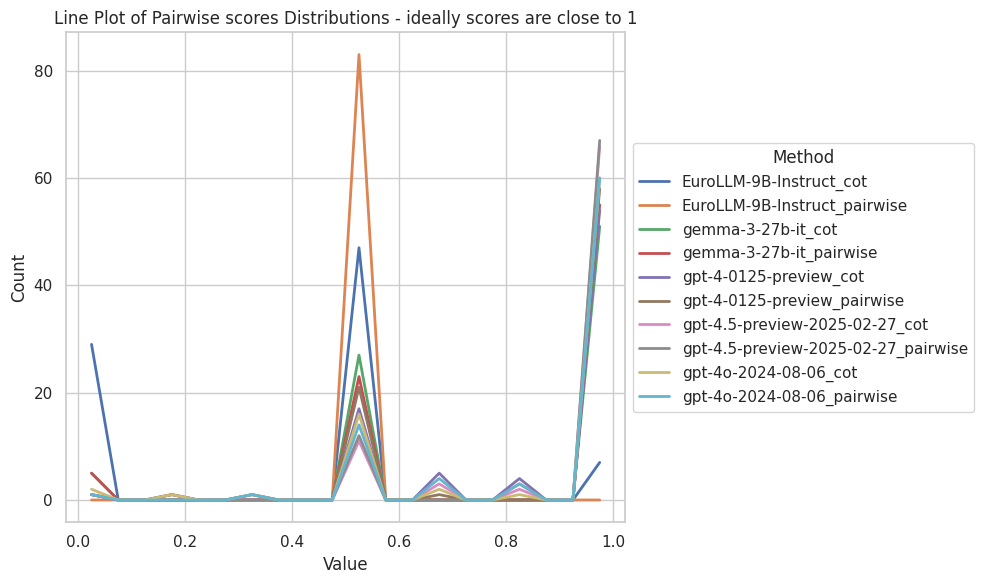

In [33]:
sub = df.loc[df.Fluency_score != 5]

columns = list(set([
    'gpt-4-0125-preview_pairwise', 'gpt-4o-2024-08-06_pairwise', 'gpt-4.5-preview-2025-02-27_pairwise', 
           'gpt-4-0125-preview_cot', 'gpt-4o-2024-08-06_cot','gpt-4.5-preview-2025-02-27_cot',
           'EuroLLM-9B-Instruct_cot', 'gemma-3-27b-it_cot'
           ]+more_columns))
columns.sort()
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the distributions for each column
for col in columns:
    # Get histogram data with raw counts (density=False)
    counts, bin_edges = np.histogram(sub[col], bins=20, density=False)
    
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Compute bin centers
    ax.plot(bin_centers, counts, label=col, linewidth=2)  # Line plot with raw counts

# Add legend, labels, and title
ax.set_xlabel('Value')
ax.set_ylabel('Count')  # Changed from 'Density' to 'Count'
ax.set_title('Line Plot of Pairwise scores Distributions - ideally scores are close to 1')

# Place legend outside the plot
ax.legend(title='Method', loc='center left', bbox_to_anchor=(1, 0.5), frameon=True)

# Adjust layout to make space for the legend
plt.tight_layout()

# Show the plot
plt.show()

In [9]:


# Assuming you have a DataFrame 'df' with two text columns 'col1' and 'col2'
# Create a new column with the edit distances
df['edit_distance'] = df.apply(lambda row: Levenshtein.distance(str(row['translations']), str(row['Correction'])), axis=1)


In [34]:
df[['edit_distance', 'Fluency_score']+columns].corr(method='spearman')[['Fluency_score', 'edit_distance']]

,Fluency_score,edit_distance
edit_distance,-0.799310,1.000000
Fluency_score,1.000000,-0.799310
EuroLLM-9B-Instruct_cot,0.018615,-0.080652
EuroLLM-9B-Instruct_pairwise,NaN,NaN
gemma-3-27b-it_cot,-0.528183,0.394119
gemma-3-27b-it_pairwise,-0.465127,0.383121
gpt-4-0125-preview_cot,-0.658245,0.547620
gpt-4-0125-preview_pairwise,-0.591445,0.451262
gpt-4.5-preview-2025-02-27_cot,-0.657373,0.530015
gpt-4.5-preview-2025-02-27_pairwise,-0.609720,0.493679


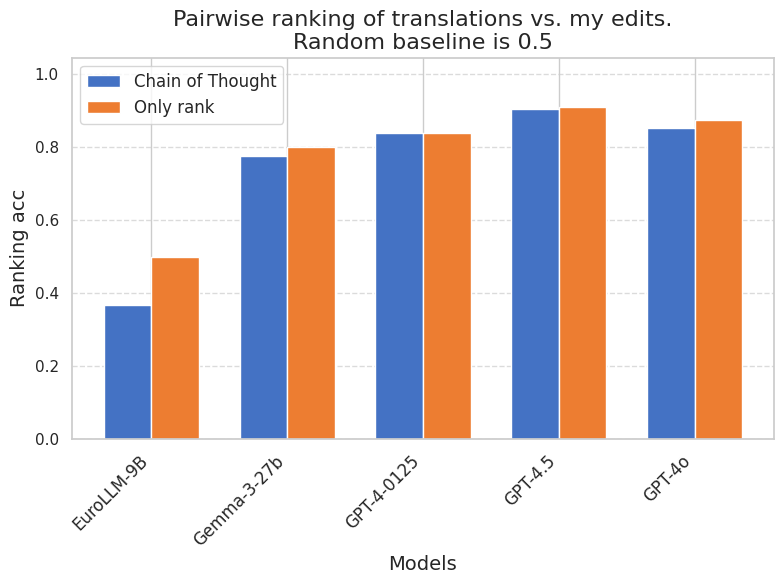

In [ ]:
# Only sentences that have less than perfect fluency score
sub = df.loc[df.Fluency_score != 5]
models = [
    'EuroLLM-9B-Instruct',
    'gemma-3-27b-it',
    'gpt-4-0125-preview',
    'gpt-4.5-preview-2025-02-27',
    'gpt-4o-2024-08-06'
]
 
# Create example data (replace with your actual metrics)
# For each model, we need a CoT score and a pairwise score
np.random.seed(42)
cot_scores = sub[[c for c in columns if '_cot' in c]].mean().values
pairwise_scores = sub[[c for c in columns if '_cot' not in c]].mean().values

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Position of bars on x-axis
x = np.arange(len(models))
width = 0.35  # Width of the bars

# Create the bars
cot_bars = ax.bar(x - width/2, cot_scores, width, label='Chain of Thought', color='#4472C4')
pairwise_bars = ax.bar(x + width/2, pairwise_scores, width, label='Only rank', color='#ED7D31')

# Add labels and title
ax.set_xlabel('Models', fontsize=14)
ax.set_ylabel('Ranking acc', fontsize=14)
ax.set_title('Pairwise ranking of translations vs. my edits.\nRandom baseline is 0.5', fontsize=16)

# Create shortened display names for better readability
display_names = [
    'EuroLLM-9B',
    'Gemma-3-27b',
    'GPT-4-0125',
    'GPT-4.5',
    'GPT-4o'
]

# Set the x-tick positions and labels
ax.set_xticks(x)
ax.set_xticklabels(display_names, rotation=45, ha='right', fontsize=12)

# Add a grid for better readability
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add legend
ax.legend(fontsize=12)

# Set y-axis limits
ax.set_ylim(0, max(max(cot_scores), max(pairwise_scores)) * 1.15)

# Adjust layout
plt.tight_layout()
plt.show()

# Rate translations among themselves

# Pairwise ranking
Assign a point if they agree with my fluency rating

In [60]:

def get_top_n_translations(ratings_df, source_id=None, n=5):
    """
    Get the top N best-rated translations for each source sentence or a specific source.
    
    Parameters:
    - ratings_df: DataFrame containing all ratings data
    - source_id: Optional specific source ID to filter by
    - n: Number of top translations to return
    
    Returns:
    - DataFrame or dict of DataFrames with top translations and their scores
    """
    # Filter by source_id if specified
    if source_id:
        df = ratings_df[ratings_df['source_id'] == source_id]
    else:
        df = ratings_df.copy()
    
    # Create a scoring system for translations
    translation_scores = defaultdict(lambda: {'wins': 0, 'losses': 0, 'human_score': 0})
    
    # Count wins and losses for each translation
    for _, row in df.iterrows():
        # Translation 1 lost to Translation 2 if model_agrees is True
        if row['model_agrees']:
            translation_scores[(row['source_id'], row['translation_id_1'])]['losses'] += 1
            translation_scores[(row['source_id'], row['translation_id_2'])]['wins'] += 1
        else:
            translation_scores[(row['source_id'], row['translation_id_1'])]['wins'] += 1
            translation_scores[(row['source_id'], row['translation_id_2'])]['losses'] += 1
        
        # Store human scores
        translation_scores[(row['source_id'], row['translation_id_1'])]['human_score'] = row['human_score_1']
        translation_scores[(row['source_id'], row['translation_id_2'])]['human_score'] = row['human_score_2']
        
        # Store the actual translation text
        if 'text' not in translation_scores[(row['source_id'], row['translation_id_1'])]:
            translation_scores[(row['source_id'], row['translation_id_1'])]['text'] = row['translation_1']
        
        if 'text' not in translation_scores[(row['source_id'], row['translation_id_2'])]:
            translation_scores[(row['source_id'], row['translation_id_2'])]['text'] = row['translation_2']
    
    # Calculate a fluency score based on win/loss ratio
    results = []
    for (source_id, translation_id), data in translation_scores.items():
        total_comparisons = data['wins'] + data['losses']
        if total_comparisons > 0:
            fluency_score = data['wins'] / total_comparisons
        else:
            fluency_score = 0
            
        results.append({
            'source_id': source_id,
            'translation_id': translation_id,
            'translation': data['text'],
            'human_score': data['human_score'],
            'wins': data['wins'],
            'losses': data['losses'],
            'fluency_score': fluency_score
        })
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Get top N for each source
    if source_id:
        return results_df.sort_values('fluency_score', ascending=False).head(n)
    else:
        top_n_by_source = {}
        for src_id, group_df in results_df.groupby('source_id'):
            top_n_by_source[src_id] = group_df.sort_values('fluency_score', ascending=False).head(n)
        return top_n_by_source


# 2. Get top 5 translations for source sentence with ID 'src_123'
# top_5_for_specific = get_top_n_translations(ratings_df, source_id='src_123', n=5)
#
# 3. Get top 3 translations for all source sentences
# top_3_for_all = get_top_n_translations(ratings_df, n=3)



In [94]:
all_res = {}
cot=False
models = ['gpt-4.1', 'gpt-4o-2024-08-06', 'gpt-4.5-preview-2025-02-27']

for model in models:
    results = compare_sentences_by_quality(
        df, 
        id_column='source_sentence', 
        sentence_column='translations', 
        score_column='Fluency_score', 
        model=model,
        cot=cot,
        save_path=f'../data/pairwise_comparison_{model}.csv'
    )

21it [00:14,  1.40it/s]
78it [01:05,  1.20it/s]
45it [00:42,  1.05it/s]
45it [00:49,  1.10s/it]
45it [00:36,  1.22it/s]
45it [00:39,  1.13it/s]
36it [00:30,  1.18it/s]
45it [00:40,  1.11it/s]
66it [01:06,  1.01s/it]
36it [00:22,  1.57it/s]
21it [00:13,  1.58it/s]
78it [00:51,  1.53it/s]
45it [00:33,  1.34it/s]
45it [00:39,  1.13it/s]
45it [00:26,  1.70it/s]
45it [00:26,  1.69it/s]
36it [00:20,  1.73it/s]
45it [00:28,  1.60it/s]
66it [00:55,  1.19it/s]
36it [00:21,  1.69it/s]
21it [00:20,  1.03it/s]
78it [01:20,  1.04s/it]
45it [00:58,  1.31s/it]
45it [00:58,  1.30s/it]
45it [00:43,  1.03it/s]
45it [00:39,  1.13it/s]
36it [00:37,  1.03s/it]
45it [00:50,  1.13s/it]
66it [01:13,  1.11s/it]
36it [00:27,  1.30it/s]


## Can the best translation be found from pairwise comparison?

- Not too accurate. 
- Too much noise beyong p@1 
- Could maybe be improved with better comparison algorithm or more repeats
- Maybe a greedy comparison scheme

In [ ]:
all_res_1 = {}
all_res_3 = {}

fnames = [f for f in glob.glob('../results/*_internal_ranking.jsonl')]+[f for f in glob.glob('../data/*pairwise_comparison.csv')]
for fname in fnames:
    model = os.path.basename(fname).split('_')[0]
    if fname.split('.')[-1] == 'jsonl':
        pair = pd.read_json(fname, lines=True)
    elif fname.split('.')[-1] == 'csv':
        pair = pd.read_csv(fname, index_col=None)

    rank1_res = []
    rank3_res = []
    for source_sent in pair.source_id.unique():
        sub = pair.loc[pair.source_id == source_sent]
        rank_dict = scores_to_ranks_dict(pd.concat([sub.human_score_1, sub.human_score_2]).values)
        top1 = get_top_n_translations(sub, source_id=source_sent, n=1)
        top1['human_rank'] = top1.human_score.map(lambda x: rank_dict[x])
        top3 =  get_top_n_translations(sub, source_id=source_sent, n=3)
        top3['human_rank'] = top3.human_score.map(lambda x: rank_dict[x])
        rank1_res.extend(top1.human_rank.values)
        rank3_res.extend(top3.human_rank.values)
    all_res_1[model] = rank1_res
    all_res_3[model] = rank3_res

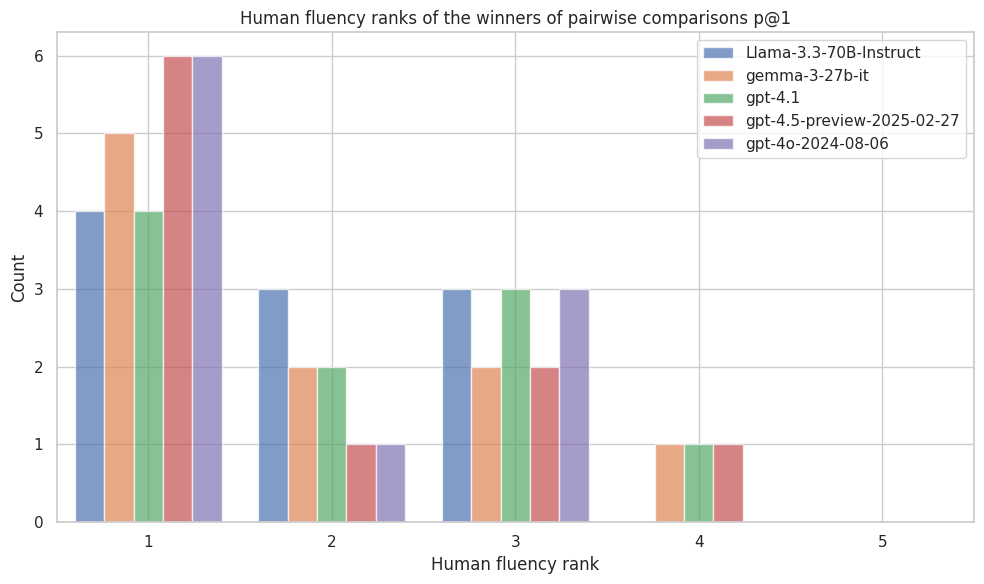

In [51]:
# Assuming all_res_1 is your data
res = pd.DataFrame(all_res_1)

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Calculate bin counts manually
bin_edges = np.arange(0.5, 5.6, 1)
bins = np.arange(1, 6)
width = 0.8 / len(res.columns)  # Width of each bar, adjusted for number of columns

# Plot each column with bars side by side
for i, col in enumerate(res.columns):
    counts, _ = np.histogram(res[col], bins=bin_edges)
    x_pos = bins + width * (i - len(res.columns)/2 + 0.5)
    ax.bar(x_pos, counts, width=width, alpha=0.7, label=col)

# Set x-axis ticks and limits
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_xlim(0.5, 5.5)

# Set title and labels
ax.set_title('Human fluency ranks of the winners of pairwise comparisons p@1')
ax.set_xlabel('Human fluency rank')
ax.set_ylabel('Count')

plt.legend()
plt.tight_layout()
plt.show()

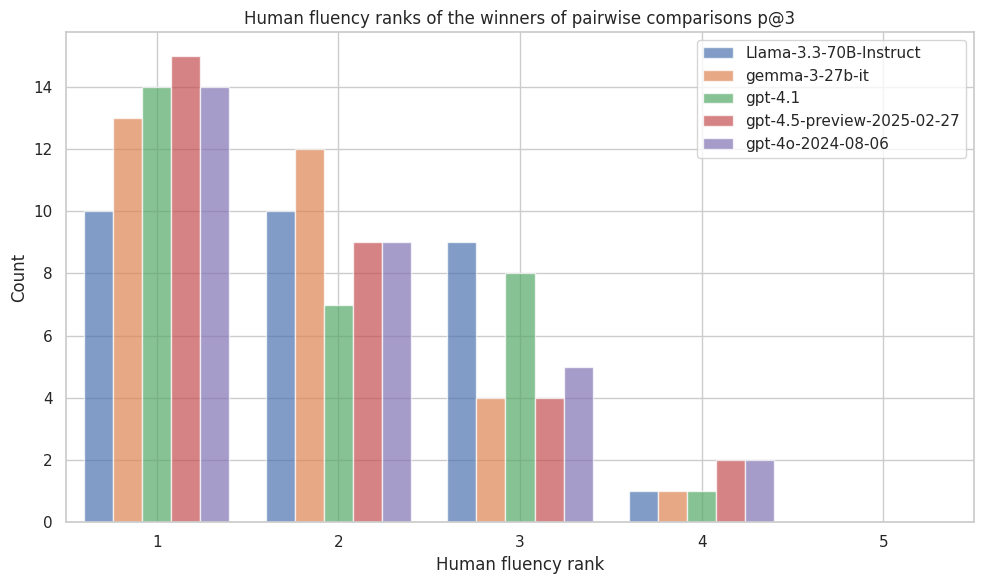

In [63]:
res = pd.DataFrame(all_res_3)

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Calculate bin counts manually
bin_edges = np.arange(0.5, 5.6, 1)
bins = np.arange(1, 6)
width = 0.8 / len(res.columns)  # Width of each bar, adjusted for number of columns

# Plot each column with bars side by side
for i, col in enumerate(res.columns):
    counts, _ = np.histogram(res[col], bins=bin_edges)
    x_pos = bins + width * (i - len(res.columns)/2 + 0.5)
    ax.bar(x_pos, counts, width=width, alpha=0.7, label=col)

# Set x-axis ticks and limits
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_xlim(0.5, 5.5)

# Set title and labels
ax.set_title('Human fluency ranks of the winners of pairwise comparisons p@3')
ax.set_xlabel('Human fluency rank')
ax.set_ylabel('Count')

plt.legend()
plt.tight_layout()
plt.show()

## What is the distribution of ranks if we take out the n worst sample?

In [96]:
def get_bottom_n(ratings_df, source_id=None, n=5):
    """
    Get the bottom N rated translations for each source sentence or a specific source.
    
    Parameters:
    - ratings_df: DataFrame containing all ratings data
    - source_id: Optional specific source ID to filter by
    - n: Number of bottom translations to return
    
    Returns:
    - DataFrame or dict of DataFrames with bottom translations and their scores
    """
    # Filter by source_id if specified
    if source_id:
        df = ratings_df[ratings_df['source_id'] == source_id]
    else:
        df = ratings_df.copy()
    
    # Create a scoring system for translations
    translation_scores = defaultdict(lambda: {'wins': 0, 'losses': 0, 'human_score': 0})
    
    # Count wins and losses for each translation
    for _, row in df.iterrows():
        # Translation 1 lost to Translation 2 if model_agrees is True
        if row['model_agrees']:
            translation_scores[(row['source_id'], row['translation_id_1'])]['losses'] += 1
            translation_scores[(row['source_id'], row['translation_id_2'])]['wins'] += 1
        else:
            translation_scores[(row['source_id'], row['translation_id_1'])]['wins'] += 1
            translation_scores[(row['source_id'], row['translation_id_2'])]['losses'] += 1
        
        # Store human scores
        translation_scores[(row['source_id'], row['translation_id_1'])]['human_score'] = row['human_score_1']
        translation_scores[(row['source_id'], row['translation_id_2'])]['human_score'] = row['human_score_2']
        
        # Store the actual translation text
        if 'text' not in translation_scores[(row['source_id'], row['translation_id_1'])]:
            translation_scores[(row['source_id'], row['translation_id_1'])]['text'] = row['translation_1']
        
        if 'text' not in translation_scores[(row['source_id'], row['translation_id_2'])]:
            translation_scores[(row['source_id'], row['translation_id_2'])]['text'] = row['translation_2']
    
    # Calculate a fluency score based on win/loss ratio
    results = []
    for (source_id, translation_id), data in translation_scores.items():
        total_comparisons = data['wins'] + data['losses']
        if total_comparisons > 0:
            fluency_score = data['wins'] / total_comparisons
        else:
            fluency_score = 0
            
        results.append({
            'source_id': source_id,
            'translation_id': translation_id,
            'translation': data['text'],
            'human_score': data['human_score'],
            'wins': data['wins'],
            'losses': data['losses'],
            'fluency_score': fluency_score
        })
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Get bottom N for each source
    if source_id:
        # Sort by fluency_score ascending (worst first) and take top n
        return results_df.sort_values('fluency_score', ascending=True).head(n)
    else:
        bottom_n_by_source = {}
        for src_id, group_df in results_df.groupby('source_id'):
            # Sort by fluency_score ascending (worst first) and take top n
            bottom_n_by_source[src_id] = group_df.sort_values('fluency_score', ascending=True).head(n)
        return bottom_n_by_source

# Initialize dictionaries to store ranks of translations removed (bottom n)
bottom_1 = {}
bottom_3 = {}
bottom_5 = {}

fnames = [f for f in glob.glob('../results/*_internal_ranking.jsonl')]+[f for f in glob.glob('../data/*pairwise_comparison.csv')]
for fname in fnames:
    model = os.path.basename(fname).split('_')[0]
    if fname.split('.')[-1] == 'jsonl':
        pair = pd.read_json(fname, lines=True)
    elif fname.split('.')[-1] == 'csv':
        pair = pd.read_csv(fname, index_col=None)
    
    
    # Initialize storage for this model - storing just the ranks
    bottom_5[model] = []
    bottom_3[model] = []
    bottom_1[model] = []
    
    for source_sent in pair.source_id.unique():
        sub = pair.loc[pair.source_id == source_sent]
        rank_dict = scores_to_ranks_dict(pd.concat([sub.human_score_1, sub.human_score_2]).values)
        bottom_1_df = get_bottom_n(sub, source_id=source_sent, n=1)
        bottom_1_df['human_rank'] = bottom_1_df.human_score.map(lambda x: rank_dict[x])
        bottom_3_df =  get_bottom_n(sub, source_id=source_sent, n=3)
        bottom_3_df['human_rank'] = bottom_3_df.human_score.map(lambda x: rank_dict[x])
        bottom_5_df =  get_bottom_n(sub, source_id=source_sent, n=5)
        bottom_5_df['human_rank'] = bottom_5_df.human_score.map(lambda x: rank_dict[x])

        bottom_1[model].extend(bottom_1_df.human_rank.values)
        bottom_3[model].extend(bottom_3_df.human_rank.values)
        bottom_5[model].extend(bottom_5_df.human_rank.values)

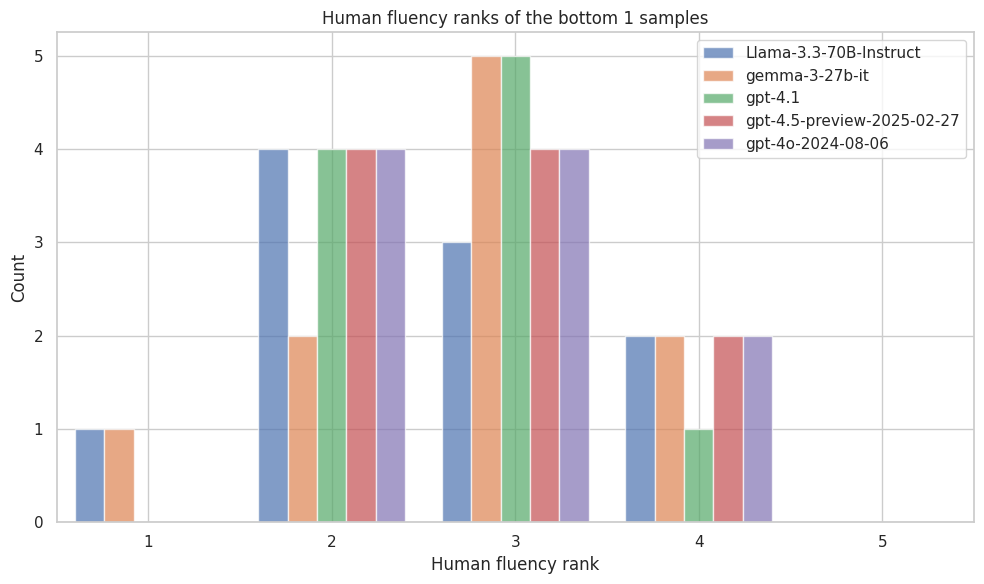

In [97]:
n = 1
res = pd.DataFrame(bottom_1)

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Calculate bin counts manually
bin_edges = np.arange(0.5, 5.6, 1)
bins = np.arange(1, 6)
width = 0.8 / len(res.columns)  # Width of each bar, adjusted for number of columns

# Plot each column with bars side by side
for i, col in enumerate(res.columns):
    counts, _ = np.histogram(res[col], bins=bin_edges)
    x_pos = bins + width * (i - len(res.columns)/2 + 0.5)
    ax.bar(x_pos, counts, width=width, alpha=0.7, label=col)

# Set x-axis ticks and limits
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_xlim(0.5, 5.5)

# Set title and labels
ax.set_title(f'Human fluency ranks of the bottom {n} samples')
ax.set_xlabel('Human fluency rank')
ax.set_ylabel('Count')

plt.legend()
plt.tight_layout()
plt.show()

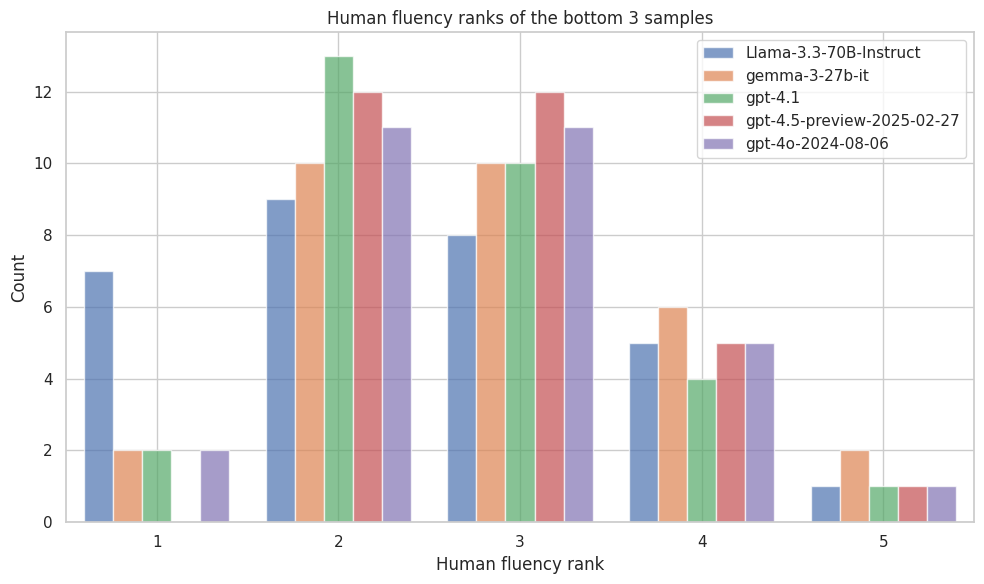

In [94]:
n = 3
res = pd.DataFrame(bottom_3)

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Calculate bin counts manually
bin_edges = np.arange(0.5, 5.6, 1)
bins = np.arange(1, 6)
width = 0.8 / len(res.columns)  # Width of each bar, adjusted for number of columns

# Plot each column with bars side by side
for i, col in enumerate(res.columns):
    counts, _ = np.histogram(res[col], bins=bin_edges)
    x_pos = bins + width * (i - len(res.columns)/2 + 0.5)
    ax.bar(x_pos, counts, width=width, alpha=0.7, label=col)

# Set x-axis ticks and limits
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_xlim(0.5, 5.5)

# Set title and labels
ax.set_title(f'Human fluency ranks of the bottom {n} samples')
ax.set_xlabel('Human fluency rank')
ax.set_ylabel('Count')

plt.legend()
plt.tight_layout()
plt.show()

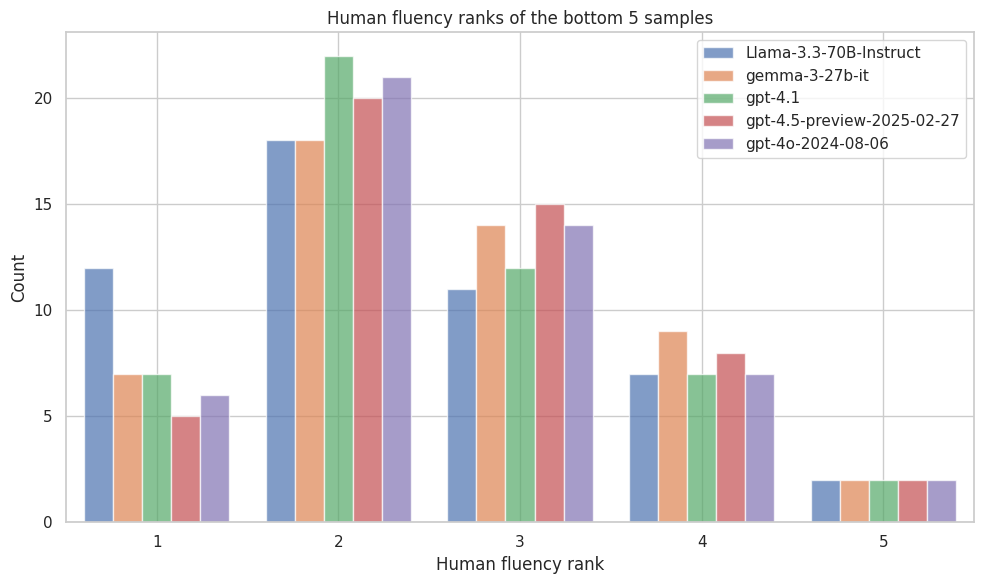

In [98]:
n = 5
res = pd.DataFrame(bottom_5)

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Calculate bin counts manually
bin_edges = np.arange(0.5, 5.6, 1)
bins = np.arange(1, 6)
width = 0.8 / len(res.columns)  # Width of each bar, adjusted for number of columns

# Plot each column with bars side by side
for i, col in enumerate(res.columns):
    counts, _ = np.histogram(res[col], bins=bin_edges)
    x_pos = bins + width * (i - len(res.columns)/2 + 0.5)
    ax.bar(x_pos, counts, width=width, alpha=0.7, label=col)

# Set x-axis ticks and limits
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_xlim(0.5, 5.5)

# Set title and labels
ax.set_title(f'Human fluency ranks of the bottom {n} samples')
ax.set_xlabel('Human fluency rank')
ax.set_ylabel('Count')

plt.legend()
plt.tight_layout()
plt.show()

## Can models distinguish a dysfluent sentence from a perfectly fluent one?
- pairwise compare a dysfluent sentence with its edited counterpart
- Only the largest models can do it
- Very complex sentences have low acc
- No gain from chain of thought
- Not a key task for us - just a sanity check

<Axes: title={'center': 'Pairwise comparison of sentences with the same source sentence.\n Acc against my rating of which is better'}>

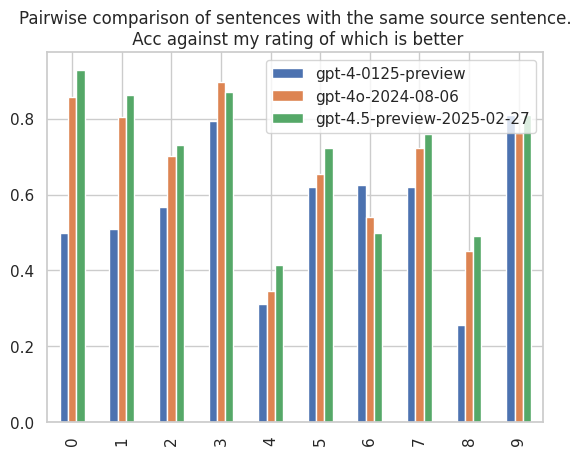

In [ ]:
pd.DataFrame(all_res).plot(kind='bar', title='Pairwise comparison of sentences with the same source sentence.\n Acc against my rating')
# Observation: The internal ranking of the models are not preserved
# There are big variations across sentences. 
# No 4 and 8 are really complex sentences.

## Batch ranking
Rank all 10 sentences and compare the rank with my ranking

In [ ]:
def get_llm_rankings(translations, model, max_completion_tokens, cot=False):
    """Get LLM rankings for a list of translations of the same source."""
    # Construct prompt
    prompt_no_cot = f"""
    
    Please rank the following sentences from best to worst (1 = best) according to how fluent they are to a native Danish speaker:
    {chr(10).join([f"{i+1}. {t}" for i, t in enumerate(translations)])}
    
    Provide your rankings as a comma-separated list of numbers corresponding to the translation numbers above between <rankings> </rankings> tags.
    """

    prompt_cot = f"""
    Please rank the following sentences from best to worst (1 = best) according to how fluent they are to a native Danish speaker:
    {chr(10).join([f"{i+1}. {t}" for i, t in enumerate(translations)])}
    Provide an evaluation of the fluency for each  your ranking between <reasoning> </reasoning> tags that violates a perfect fluency that is defined like:     Grammar: Perfect grammatical control with no errors in noun gender, verb conjugation, or word order
    Vocabulary: Rich, precise, and idiomatic vocabulary with proper use of Danish expressions and colloquialisms
    Flow: Text has a natural rhythm that would sound completely authentic when read aloud
    Sentence Structure: Varied and complex sentence structures used appropriately and effortlessly
    Idioms: Appropriate use of Danish idioms, verbal phraess, and Danish-specific expressions. 
    Example <reasoning>1: fluency errors when using anglicism 'tale op' and this word does not exist in Danish: 'nedskørings' 2: wrong subject-verb ordering in a subclause ... </reasoning>: 
    Provide your rankings as a comma-separated list of indices corresponding to the translation numbers above between <rankings> </rankings> tags.
    """
    if cot:
        prompt = prompt_cot
    else:
        prompt = prompt_no_cot
    
    # Get response from LLM
    if 'deepseek' in model:
        response = openai_get_response(prompt=prompt, model=model, max_completion_tokens=max_completion_tokens, api_key=os.environ.get('LLAMA_API_KEY'), temperature=0.1)
    else:
        response = call_litellm(prompt, model=model, max_completion_tokens=max_completion_tokens)
    
    # Extract just the numbers from the response
    rankings = BeautifulSoup(response, 'html.parser').find('rankings').text 
    rankings_list = [int(x.strip()) for x in rankings.strip().split(',')]
        
    return rankings_list

def get_batch_winner(translations, model, max_completion_tokens, cot=False):
    """Get LLM rankings for a list of translations of the same source."""
    # Construct prompt
    prompt_no_cot = f"""
    
    Return the index of the most fluent sentence from these sentences. Fluency is defined as the sentence that sounds more natural to a native Danish speaker, avoids repetions, no grammatical errors and has a consistent and appropriate rhythm and register:
    {chr(10).join([f"{i}. {t}" for i, t in enumerate(translations)])}
    
    Give the index of the winner between these tags <winner> </winner>.
    """

    prompt_cot = f"""
    Return the index of the most fluent sentence from these sentences between the <winner> </winner> tags. Fluency is defined as the sentence that sounds more natural to a native Danish speaker, avoids repetions, no grammatical errors and has a consistent and appropriate rhythm and register:
    {chr(10).join([f"{i}. {t}" for i, t in enumerate(translations)])}
    Provide an evaluation of the fluency for each  your ranking between <reasoning> </reasoning> tags that violates a perfect fluency that is defined like:     Grammar: Perfect grammatical control with no errors in noun gender, verb conjugation, or word order
    Vocabulary: Rich, precise, and idiomatic vocabulary with proper use of Danish expressions and colloquialisms
    Flow: Text has a natural rhythm that would sound completely authentic when read aloud
    Sentence Structure: Varied and complex sentence structures used appropriately and effortlessly
    Idioms: Appropriate use of Danish idioms, verbal phraess, and Danish-specific expressions. 

    """
    if cot:
        prompt = prompt_cot
    else:
        prompt = prompt_no_cot
    
    # Get response from LLM
    if 'deepseek' in model:
        response = openai_get_response(prompt=prompt, model=model, max_completion_tokens=max_completion_tokens, api_key=os.environ.get('LLAMA_API_KEY'), temperature=0.1)
    else:
        response = call_litellm(prompt, model=model, max_completion_tokens=max_completion_tokens)
    
    # Extract just the numbers from the response
    winner = BeautifulSoup(response, 'html.parser').find('winner').text.strip() 
    winner_idx = int(winner_idx)    
    return winner

def sort_by_llm_and_get_top_n(llm_rankings, human_rankings, n=3):
    # Pair the rankings
    paired_rankings = list(zip(llm_rankings, human_rankings))
    
    # Sort the pairs based on llm_rankings (first element in each pair)
    # Using reverse=True to sort in descending order (higher ranking first)
    sorted_pairs = sorted(paired_rankings, key=lambda x: x[0], reverse=False)
    
    # Take the top n pairs
    top_n_pairs = sorted_pairs[:n]
    
    # Unzip the pairs back into separate lists
    _top_n_llm, top_n_human = zip(*top_n_pairs) if top_n_pairs else ([], [])
    
    return list(top_n_human)

# Process each source sentence

cot = True
all_res_batch_1 = {}
all_res_batch_3 = {}
models = ['gpt-4.1', 'gpt-4o-2024-08-06', 'gpt-4.5-preview-2025-02-27']
models = ['deepseek/deepseek-chat-v3-0324:free-0']
for model in models:
    top3s = []
    top1s = []
    for source, group in df.groupby('source_sentence'):
        translations = group['translations'].tolist()
        human_ratings = group['Fluency_score'].tolist()
        
        # Get human rankings (higher rating = better rank)
        rank_dict = scores_to_ranks_dict(human_ratings)
        human_rankings = [rank_dict[x] for x in human_ratings]
        
        # Get LLM rankings
        llm_rankings = get_llm_rankings(translations, model=model, max_completion_tokens=2000)
        top3 = sort_by_llm_and_get_top_n(llm_rankings=llm_rankings, human_rankings=human_rankings)
        top1 = top3[0]
        top3s.extend(top3)
        top1s.extend([top1])

    all_res_batch_1[model] = top1s
    all_res_batch_3[model] = top3s

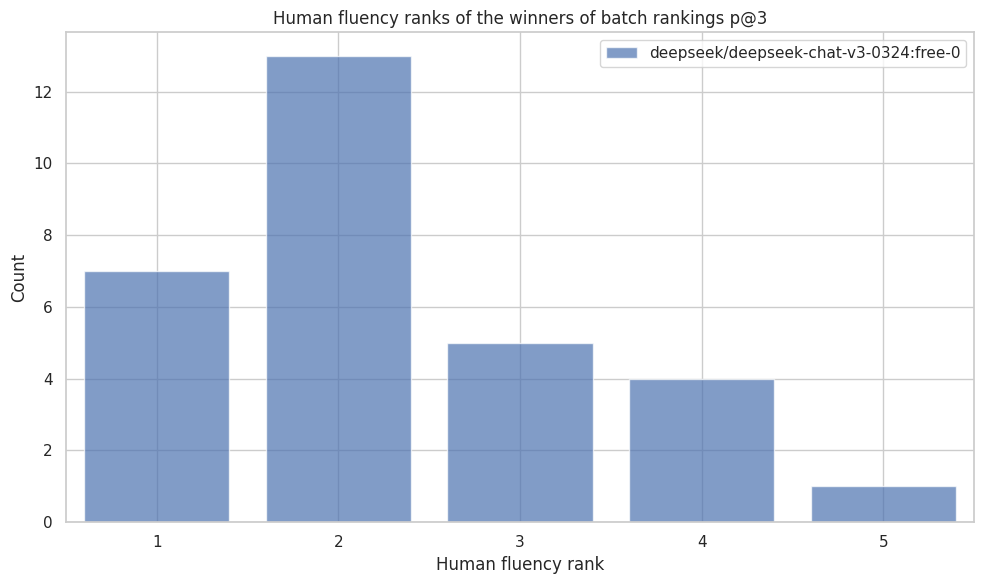

In [22]:
res = pd.DataFrame(all_res_batch_3)

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Calculate bin counts manually
bin_edges = np.arange(0.5, 5.6, 1)
bins = np.arange(1, 6)
width = 0.8 / len(res.columns)  # Width of each bar, adjusted for number of columns

# Plot each column with bars side by side
for i, col in enumerate(res.columns):
    counts, _ = np.histogram(res[col], bins=bin_edges)
    x_pos = bins + width * (i - len(res.columns)/2 + 0.5)
    ax.bar(x_pos, counts, width=width, alpha=0.7, label=col)

# Set x-axis ticks and limits
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_xlim(0.5, 5.5)

# Set title and labels
ax.set_title('Human fluency ranks of the winners of batch rankings p@3')
ax.set_xlabel('Human fluency rank')
ax.set_ylabel('Count')

plt.legend()
plt.tight_layout()
plt.show()

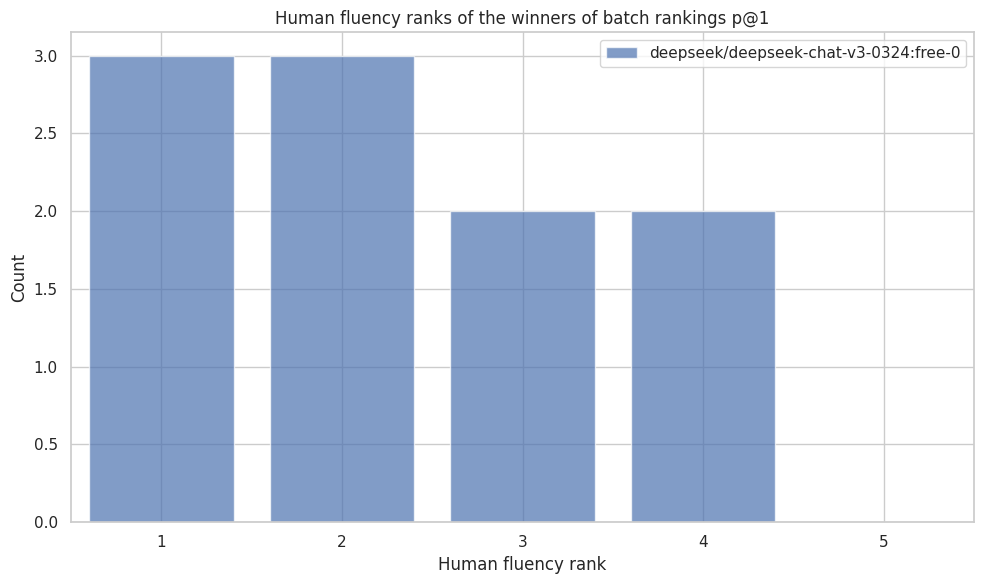

In [23]:
res = pd.DataFrame(all_res_batch_1)

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Calculate bin counts manually
bin_edges = np.arange(0.5, 5.6, 1)
bins = np.arange(1, 6)
width = 0.8 / len(res.columns)  # Width of each bar, adjusted for number of columns

# Plot each column with bars side by side
for i, col in enumerate(res.columns):
    counts, _ = np.histogram(res[col], bins=bin_edges)
    x_pos = bins + width * (i - len(res.columns)/2 + 0.5)
    ax.bar(x_pos, counts, width=width, alpha=0.7, label=col)

# Set x-axis ticks and limits
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_xlim(0.5, 5.5)

# Set title and labels
ax.set_title('Human fluency ranks of the winners of batch rankings p@1')
ax.set_xlabel('Human fluency rank')
ax.set_ylabel('Count')

plt.legend()
plt.tight_layout()
plt.show()

## Only return the best translation per source sentence

In [36]:
def get_batch_winner(translations, model, max_completion_tokens, cot=False):
    """Get LLM rankings for a list of translations of the same source."""
    # Construct prompt
    prompt_no_cot = f"""
    
    Return the index of the most fluent sentence from these sentences. Fluency is defined as the sentence that sounds more natural to a native Danish speaker, avoids repetions, no grammatical errors and has a consistent and appropriate rhythm and register:
    {chr(10).join([f"{i}. {t}" for i, t in enumerate(translations)])}
    
    Give the index of the winner between these tags <winner> </winner>.
    """

    prompt_cot = f"""
    Return the index of the most fluent sentence from these sentences between the <winner> </winner> tags. Fluency is defined as the sentence that sounds more natural to a native Danish speaker, avoids repetions, no grammatical errors and has a consistent and appropriate rhythm and register:
    {chr(10).join([f"{i}. {t}" for i, t in enumerate(translations)])}
    Provide an evaluation of the fluency for each  your ranking between <reasoning> </reasoning> tags that violates a perfect fluency that is defined like:     Grammar: Perfect grammatical control with no errors in noun gender, verb conjugation, or word order
    Vocabulary: Rich, precise, and idiomatic vocabulary with proper use of Danish expressions and colloquialisms
    Flow: Text has a natural rhythm that would sound completely authentic when read aloud
    Sentence Structure: Varied and complex sentence structures used appropriately and effortlessly
    Idioms: Appropriate use of Danish idioms, verbal phraess, and Danish-specific expressions. 

    """
    if cot:
        prompt = prompt_cot
    else:
        prompt = prompt_no_cot
    
    # Get response from LLM
    if 'deepseek' in model:
        response = openai_get_response(prompt=prompt, model=model, max_completion_tokens=max_completion_tokens, api_key=os.environ.get('LLAMA_API_KEY'), temperature=0.1)
    else:
        response = call_litellm(prompt=prompt, model=model, max_completion_tokens=max_completion_tokens, temperature=0.1)

    # Extract just the numbers from the response
    winner = BeautifulSoup(response, 'html.parser').find('winner').text.strip() 
    try:
        winner_idx = int(winner)    
        return winner_idx
    except:
        return None

In [34]:
all_res_1

{'deepseek/deepseek-chat-v3-0324:free-0': [1, 1, 4, 1, 3, 1, 3, 1, 2, 2],
 'gpt-4o-2024-08-06': [1, 1, 1, 1, 2, 1, 3, 1, 3, 2],
 'gpt-4.5-preview-2025-02-27': [1, 1, 1, 1, 2, 1, 2, 2, 2]}

In [39]:
cot = False
#all_res_1 = {}
models = ['gpt-4.1', 'gpt-4o-2024-08-06', 'gpt-4.5-preview-2025-02-27']
models = ['deepseek/deepseek-chat-v3-0324:free-0',  'gpt-4o-2024-08-06', 'gpt-4.5-preview-2025-02-27']
models = ['gpt-4.5-preview-2025-02-27']
#models = ['gpt-4o-2024-08-06']
for model in models:
    winner_ranks = []
    for source, group in df.groupby('source_sentence'):
        translations = group['translations'].tolist()
        human_ratings = group['Fluency_score'].tolist()
        
        # Get human rankings (higher rating = better rank)
        rank_dict = scores_to_ranks_dict(human_ratings)
        human_rankings = [rank_dict[x] for x in human_ratings]
        
        # Get LLM rankings
        winner_idx = get_batch_winner(translations, model=model, max_completion_tokens=500)
        if winner_idx != None:
            top1 = human_rankings[winner_idx]
            print(top1)
            winner_ranks.append(top1)
    all_res_1[model] = winner_ranks

1
1
1
1
2
3
1
1
2
2


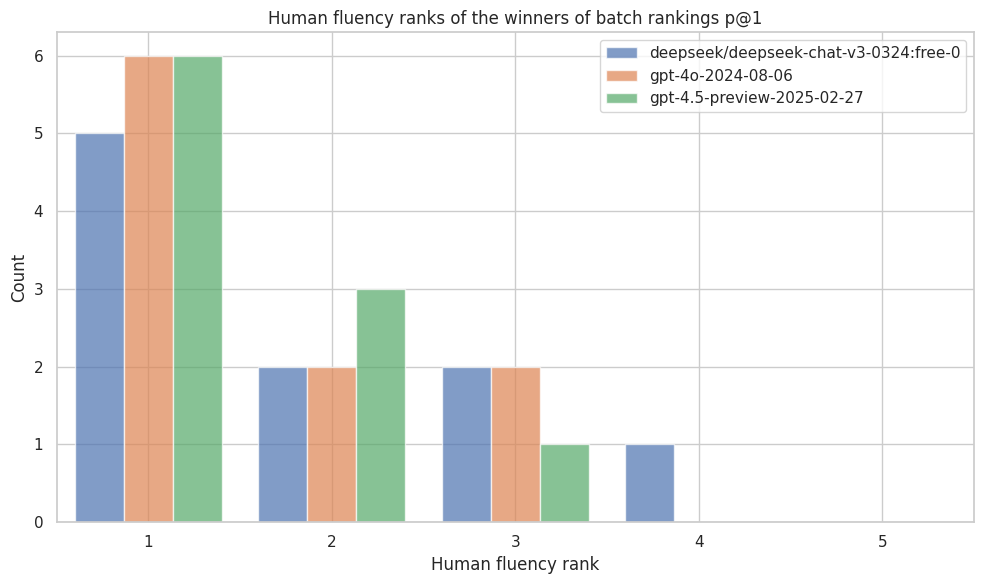

In [40]:
res = pd.DataFrame(all_res_1)

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Calculate bin counts manually
bin_edges = np.arange(0.5, 5.6, 1)
bins = np.arange(1, 6)
width = 0.8 / len(res.columns)  # Width of each bar, adjusted for number of columns

# Plot each column with bars side by side
for i, col in enumerate(res.columns):
    counts, _ = np.histogram(res[col], bins=bin_edges)
    x_pos = bins + width * (i - len(res.columns)/2 + 0.5)
    ax.bar(x_pos, counts, width=width, alpha=0.7, label=col)

# Set x-axis ticks and limits
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_xlim(0.5, 5.5)

# Set title and labels
ax.set_title('Human fluency ranks of the winners of batch rankings p@1')
ax.set_xlabel('Human fluency rank')
ax.set_ylabel('Count')

plt.legend()
plt.tight_layout()
plt.show()

# Scoring
Can an LLM score the fluency similarly to a human?

Observations
- It seems to require substantial model size, but it seems to work reasonaby well
- - GPT4 4.5 and GPT 4.1 have the same mean squared error (0.95) and both show medium strenght correlation with my scores, but GPT 4.5 has a higher correlation (.59)
- The confusion matrix shows that classes are most often mixed with neighboring classes which is pleasing 
- The strongest model is DeepSeek-V3
- Playing with the temperature does not change the result substantially, except performance drops at temperature 0.5 and at 1, there are syntax errors in the dict output. But 0, 0.01, 0.1 are almost the same. 

In [142]:
more_models = ['viking-33b-synthetic-magpie-oasst2-epochs-2-batch-128-packed',
 'Llama-3.3-70B-Instruct',
 'gemma-3-27b-it',
 'EuroLLM-9B-Instruct']

In [144]:
# read in results from files - only run once
edit_results_files = [f for f in glob.glob('../results/*.jsonl') if '_score' in f]
more_models = []

for fname in edit_results_files:
    modelname = fname.split('/')[-1].split('_')[0]
    more_models.append(modelname)
    one = pd.read_json(fname, lines=True)  # Fixed 'True' to True
    edit_col = 'open_model_task_col'
    
    if '_cot' in fname:
        new_colname = modelname + '_fluency_score_cot'
    else:
        new_colname = modelname + '_fluency_score_score'
    
    print(new_colname)
    
    # Extract score from HTML
    one[new_colname] = one[edit_col].progress_map(
        lambda x: BeautifulSoup(str(x), 'html.parser').find('score').text.strip() 
        if BeautifulSoup(str(x), 'html.parser').find('score') 
        else None
    )
    
    # Convert to numeric, keeping NaN for non-convertible values
    one[new_colname] = pd.to_numeric(one[new_colname], errors='coerce')
    
    # Add to main dataframe
    df[new_colname] = one[new_colname]
    
    # Only calculate squared error for values that can be converted to int
    # Create a mask for valid numeric values
    valid_values_mask = df[new_colname].notna()
    
    # Initialize the SE column with NaN
    df[f'{modelname}_fluency_score_SE'] = pd.NA
    
    # Only calculate SE for valid numeric values
    df.loc[valid_values_mask, f'{modelname}_fluency_score_SE'] = (
        df.loc[valid_values_mask, 'Fluency_score'] - 
        df.loc[valid_values_mask, new_colname]
    ) ** 2

Llama-3.3-70B-Instruct_fluency_score_cot


100%|██████████| 100/100 [00:00<00:00, 4161.72it/s]


viking-33b-synthetic-magpie-oasst2-epochs-2-batch-128-packed_fluency_score_score


100%|██████████| 100/100 [00:00<00:00, 875.72it/s]


gemma-3-27b-it_fluency_score_cot


100%|██████████| 100/100 [00:00<00:00, 2055.73it/s]
/tmp/ipykernel_4249/326609324.py:39: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[valid_values_mask, f'{modelname}_fluency_score_SE'] = (


EuroLLM-9B-Instruct_fluency_score_cot


100%|██████████| 100/100 [00:00<00:00, 1826.01it/s]
/tmp/ipykernel_4249/326609324.py:39: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[valid_values_mask, f'{modelname}_fluency_score_SE'] = (


viking-33b-synthetic-magpie-oasst2-epochs-2-batch-128-packed_fluency_score_cot


100%|██████████| 100/100 [00:00<00:00, 1312.18it/s]


Llama-3.3-70B-Instruct_fluency_score_score


100%|██████████| 100/100 [00:00<00:00, 4857.39it/s]


gemma-3-27b-it_fluency_score_score


100%|██████████| 100/100 [00:00<00:00, 2098.87it/s]
/tmp/ipykernel_4249/326609324.py:39: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[valid_values_mask, f'{modelname}_fluency_score_SE'] = (


In [146]:

for model in ['DeepSeek-V3', 'DeepSeek-R1']+models:
    #df[f'{model}_fluency_score'] = df['translations'].progress_map(lambda x: call_litellm(create_prompt_rating(x), model, max_completion_tokens=1000))
    #df[f'{model}_fluency_score_score'] = df[f'{model}_fluency_score'].map(lambda x:  BeautifulSoup(x, 'html.parser').find('score').text.strip() if BeautifulSoup(x, 'html.parser').find('score') else None)
    #df[f'{model}_fluency_score_score'].fillna(0, inplace=True)
    df[f'{model}_fluency_score_SE'] = (df.Fluency_score - df[f'{model}_fluency_score_score'].astype(int))**2

In [214]:
for model in ['meta-llama/llama-3.1-405b-instruct']:
    df[f'{model}_fluency_score'] = df['translations'].progress_map(lambda x: openai_get_response(create_prompt_rating(x), model=model, max_completion_tokens=10, api_key=os.environ['LLAMA_API_KEY']))
    df.to_json('/scratch/project_462000353/maribarr/translation_quality/data/Flores200_dev.jsonl', lines=True, orient='records')
    df[f'{model}_fluency_score_score'] = df[f'{model}_fluency_score'].map(lambda x:  BeautifulSoup(x, 'html.parser').find('score').text.strip() if BeautifulSoup(x, 'html.parser').find('score') else None)
    df[f'{model}_fluency_score_score'].fillna(0, inplace=True)
    df[f'{model}_fluency_score_SE'] = (df.Fluency_score - df[f'{model}_fluency_score_score'].astype(int))**2

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [13:14<00:00,  7.94s/it]


In [48]:

def openai_get_response(prompt, model, max_completion_tokens=1000, api_key=None, temperature=0.1):
    client = OpenAI(
      base_url="https://openrouter.ai/api/v1",
      api_key=api_key)

    completion = client.chat.completions.create(
      extra_headers={
        #"HTTP-Referer": "<YOUR_SITE_URL>", # Optional. Site URL for rankings on openrouter.ai.
        #"X-Title": "<YOUR_SITE_NAME>", # Optional. Site title for rankings on openrouter.ai.
      },
      extra_body={},
      model=model,
      temperature=temperature,
      messages=[
        {
          "role": "user",
          "content": prompt
        }
      ]
    )
    return completion.choices[0].message.content

In [8]:
def create_batch_scoring(sentences: pd.Series) -> str:
    """
    Create a prompt for batch scoring sentence fluency on a scale of 1-5.
    
    Args:
        sentences: A pandas Series containing the sentences to be scored
        
    Returns:
        A formatted prompt string for an LLM to score multiple sentences
    """
    # Convert sentences to a formatted string representation
    sentences_dict = sentences.to_dict()
    sentences_formatted = "\n".join([f"{idx}: {text}" for idx, text in sentences_dict.items()])
    
    # Create the prompt with proper escaping of curly braces
    prompt = f"""Score the fluency of each of the sentences below according to this fluency rubric:
    1 Point: Minimal Fluency

    Grammar: Technically grammatical but with pervasive errors in most areas (gender, number, tense, etc.)
    Vocabulary: Very basic vocabulary with significant repetition and many direct translations
    Pronunciation/Flow: Text is choppy and disconnected, would sound extremely unnatural to native speakers
    Sentence Structure: Almost exclusively simple or fragmented sentences arranged in an unnatural sequence
    Idioms: No awareness of Danish cultural context in language use

    2 Points: Basic Fluency

    Grammar: Frequent grammatical errors in article use, and verb tenses, though main meaning is understandable
    Vocabulary: Limited vocabulary with repetition and occasional use of non-Danish words or direct translations
    Pronunciation/Flow: Text reads with a distinctly non-Danish cadence and would sound unnatural when read aloud
    Sentence Structure: Predominantly simple sentences with awkward attempts at complexity
    Idioms: Minimal awareness of Danish idioms and verbal phrases

    3 Points: Intermediate Fluency

    Grammar: Some noticeable grammatical errors, particularly with complex structures, but meaning remains clear
    Vocabulary: Adequate vocabulary for most situations, but limited idiomatic expressions and some repetition
    Pronunciation/Flow: Text has a somewhat unnatural rhythm that would be noticeable to native speakers
    Sentence Structure: Mix of simple and complex sentences, but reliance on certain patterns
    Idioms: Some awareness of Danish idioms and verbal phrases, but still some errors that are directly translated from English, e.g., 'jeg bryder problemet ned'

    4 Points: Advanced Fluency

    Grammar: Very few minor grammatical errors that wouldn't distract a native speaker
    Vocabulary: Broad vocabulary with good use of idioms, though occasional imprecise word choice
    Pronunciation/Flow: Text flows naturally with only occasional awkward phrasing
    Sentence Structure: Good variety of complex sentence structures with minor awkwardness
    Idioms: Generally appropriate use of Danish idioms and verbal phrases with occasional slight misuse

    5 Points: Native-Like Fluency

    Grammar: Perfect grammatical control with no errors in noun gender, verb conjugation, or word order
    Vocabulary: Rich, precise, and idiomatic vocabulary with proper use of Danish expressions and colloquialisms
    Flow: Text has a natural rhythm that would sound completely authentic when read aloud
    Sentence Structure: Varied and complex sentence structures used appropriately and effortlessly
    Idioms: Appropriate use of Danish idioms, verbal phrases, and Danish-specific expressions.

    Return the result as a valid python dictionary with the sentence index as the key and fluency score as value.
    Example: {{0: 2, 1: 5, 2: 3 ...}}
    
    Say nothing else beyond this dictionary.

    The sentences:
    {sentences_formatted}
    """
    return prompt

In [ ]:
model = 'deepseek/deepseek-chat-v3-0324:free'
for temp in [0, 0.01, 0.5]:
    dict_str = openai_get_response(create_batch_scoring(df.translations),  model=model, max_completion_tokens=1000, api_key=os.environ['LLAMA_API_KEY'], temperature=temp)
    df[f'{model}-{temp}_fluency_score_score']=pd.DataFrame.from_dict(extract_dict_from_code_block(dict_str), orient='index')
    df.to_json('/scratch/project_462000353/maribarr/translation_quality/data/Flores200_dev.jsonl', lines=True, orient='records')
    df[f'{model}_{temp}_fluency_score_SE'] = (df.Fluency_score - df[f'{model}-{temp}_fluency_score_score'].astype(int))**2
df.to_json('/scratch/project_462000353/maribarr/translation_quality/data/Flores200_dev.jsonl', lines=True, orient='records')


In [ ]:
gemini_models = ['google/gemini-2.5-pro-preview', 'google/gemini-2.5-flash-preview', 'google/gemini-2.0-flash-001']
deepseek_models = ['DeepSeek-V3', 'DeepSeek-R1', 'DeepSeek-V3-0324']+['deepseek/deepseek-chat-v3-0324:free-0', 'deepseek/deepseek-chat-v3-0324:free-0.01', 'deepseek/deepseek-chat-v3-0324:free-0.5']
model = 'deepseek/deepseek-chat-v3-0324:free'
for temp in [0, 0.01, 1]:
    df[f'{model}-{temp}_fluency_score'] = df['translations'].progress_map(lambda x: openai_get_response(create_prompt_rating(x), model=model, max_completion_tokens=10, api_key=os.environ['LLAMA_API_KEY'], temperature=temp))
    df.to_json('/scratch/project_462000353/maribarr/translation_quality/data/Flores200_dev.jsonl', lines=True, orient='records')
    df[f'{model}_{temp}_fluency_score_score'] = df[f'{model}_fluency_score'].map(lambda x:  BeautifulSoup(x, 'html.parser').find('score').text.strip() if BeautifulSoup(x, 'html.parser').find('score') else None)
    df[f'{model}_{temp}_fluency_score_score'].fillna(0, inplace=True)
    df[f'{model}_{temp}_fluency_score_SE'] = (df.Fluency_score - df[f'{model}_fluency_score_score'].astype(int))**2

  1%|          | 1/100 [00:00<00:25,  3.90it/s]


BadRequestError: Error code: 400 - {'error': {'message': 'DeepSeek/DeepSeek-V3 is not a valid model ID', 'code': 400}, 'user_id': 'user_2kHrsSPEE5bxQH9UuXEB7ICTBno'}

In [76]:
# Mean squared error
models = ['gpt-4.1-nano', 'gpt-4.1', 'gpt-4o-2024-08-06', 'gpt-4.5-preview-2025-02-27', 'gpt-4.1-mini']
more_models = ['viking-33b-synthetic-magpie-oasst2-epochs-2-batch-128-packed',
 'Llama-3.3-70B-Instruct',
 'gemma-3-27b-it',
 'EuroLLM-9B-Instruct']
gemini_models = ['google/gemini-2.5-pro-preview', 'google/gemini-2.5-flash-preview', 'google/gemini-2.0-flash-001']
deepseek_models = ['DeepSeek-V3', 'DeepSeek-R1', 'DeepSeek-V3-0324']+['deepseek/deepseek-chat-v3-0324:free-0', 'deepseek/deepseek-chat-v3-0324:free-0.01', 'deepseek/deepseek-chat-v3-0324:free-0.5']

for model in  list(set(models+more_models))+deepseek_models:
    # Try both naming patterns for each model
    column_options = [f'{model}_fluency_score_score', f'{model}_fluency_score_cot']
    
    for col in column_options:
        # Skip if column doesn't exist in dataframe
        if col not in df.columns:
            continue
            
        # Check if SE column exists or needs to be created
        se_col = f'{model}_fluency_score_SE'
        if se_col not in df.columns:
            # Create a mask for valid numeric values
            valid_values_mask = df[col].notna()
            
            # Initialize the SE column with None (not NaN)
            df[se_col] = None
            
            # Only calculate SE for valid numeric values
            df.loc[valid_values_mask, se_col] = (df.loc[valid_values_mask, 'Fluency_score'] - 
                                                df.loc[valid_values_mask, col]) ** 2
        
        # Filter for rows where the SE exists and is greater than 0
        mask = (df[se_col].notna()) & (df[se_col] > 0)
        
        if mask.any():  # Check if there are any valid rows to process
            sub = df.loc[mask]
            
            # Only calculate MSE if both actual and predicted values are valid
            valid_rows = sub['Fluency_score'].notna() & sub[col].notna()
            
            if valid_rows.any():
                mse = mean_squared_error(
                    y_true=sub.loc[valid_rows, 'Fluency_score'],
                    y_pred=sub.loc[valid_rows, col]
                )
                print(f"{model} ({col}) MSE: {mse:.2f}")
            else:
                print(f"No valid prediction pairs found for {model} using {col}")
        else:
            print(f"No valid squared error values found for {model} using {col}")

gpt-4.5-preview-2025-02-27 (gpt-4.5-preview-2025-02-27_fluency_score_score) MSE: 1.67
gpt-4.1-mini (gpt-4.1-mini_fluency_score_score) MSE: 1.94
gpt-4.1-nano (gpt-4.1-nano_fluency_score_score) MSE: 2.29
viking-33b-synthetic-magpie-oasst2-epochs-2-batch-128-packed (viking-33b-synthetic-magpie-oasst2-epochs-2-batch-128-packed_fluency_score_score) MSE: 1.60
viking-33b-synthetic-magpie-oasst2-epochs-2-batch-128-packed (viking-33b-synthetic-magpie-oasst2-epochs-2-batch-128-packed_fluency_score_cot) MSE: 3.25
gpt-4o-2024-08-06 (gpt-4o-2024-08-06_fluency_score_score) MSE: 3.00
gpt-4.1 (gpt-4.1_fluency_score_score) MSE: 1.70
gemma-3-27b-it (gemma-3-27b-it_fluency_score_score) MSE: 1.70
gemma-3-27b-it (gemma-3-27b-it_fluency_score_cot) MSE: 1.70
Llama-3.3-70B-Instruct (Llama-3.3-70B-Instruct_fluency_score_score) MSE: 1.83
Llama-3.3-70B-Instruct (Llama-3.3-70B-Instruct_fluency_score_cot) MSE: 1.65
EuroLLM-9B-Instruct (EuroLLM-9B-Instruct_fluency_score_cot) MSE: 2.02
DeepSeek-V3 (DeepSeek-V3_fluen

/tmp/ipykernel_41699/2750518527.py:29: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[valid_values_mask, se_col] = (df.loc[valid_values_mask, 'Fluency_score'] -
/tmp/ipykernel_41699/2750518527.py:29: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[valid_values_mask, se_col] = (df.loc[valid_values_mask, 'Fluency_score'] -
/tmp/ipykernel_41699/2750518527.py:29: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, 

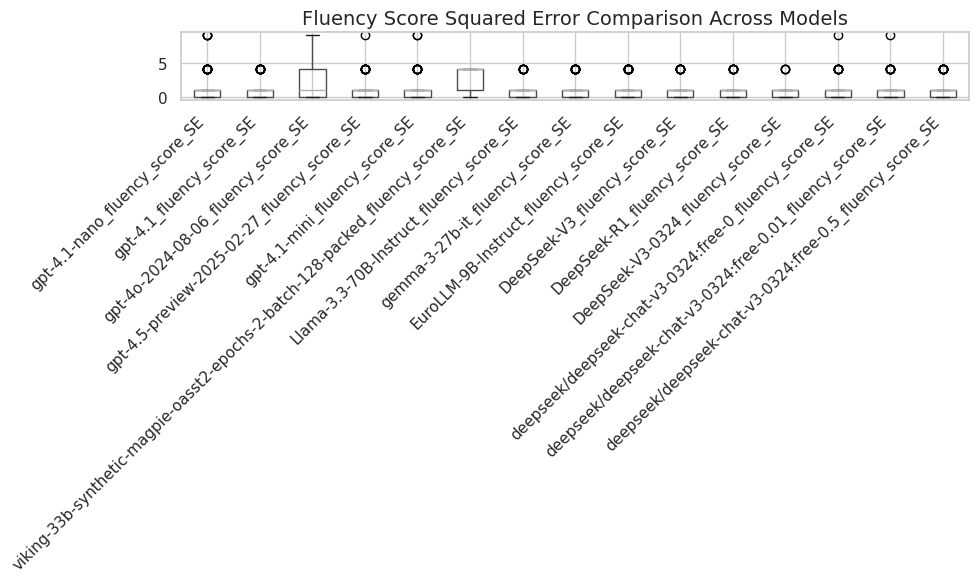

In [77]:

fig, ax = plt.subplots(figsize=(10, 6))  # Create figure with custom size
df[[f'{m}_fluency_score_SE' for m in models+more_models+deepseek_models]].boxplot(ax=ax)
plt.xticks(rotation=45, ha='right')  # Rotate by 45 degrees, horizontally align to right
plt.title('Fluency Score Squared Error Comparison Across Models', fontsize=14)
plt.tight_layout()
plt.show()

correlation between the human fluency score and the model's fluency score


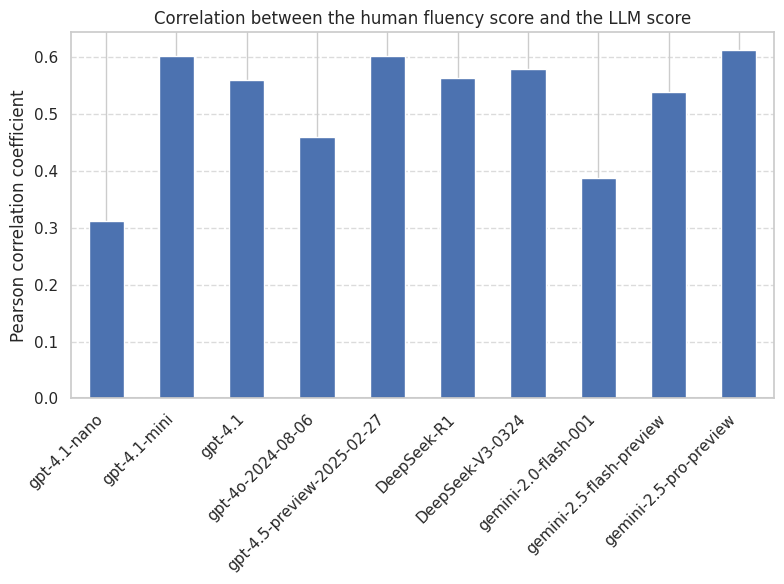

In [17]:
# Correlation between human fluency score and model fluency scores
def strip_model_names(model_name:str):
    model_name = model_name.split('_')[0]
    model_name = model_name.split('/')[-1]
    return(model_name)

models = ['gpt-4.1-nano', 'gpt-4.1-mini', 'gpt-4.1', 'gpt-4o-2024-08-06', 'gpt-4.5-preview-2025-02-27', ]
more_models = ['viking-33b-synthetic-magpie-oasst2-epochs-2-batch-128-packed',
 'Llama-3.3-70B-Instruct',
 'gemma-3-27b-it',
 #'EuroLLM-9B-Instruct'
 ]
gemini_models = ['google/gemini-2.0-flash-001', 'google/gemini-2.5-flash-preview','google/gemini-2.5-pro-preview',  ]
deepseek_models = ['DeepSeek-R1', 'DeepSeek-V3-0324']
#+['deepseek/deepseek-chat-v3-0324:free-0', 'deepseek/deepseek-chat-v3-0324:free-0.01', 'deepseek/deepseek-chat-v3-0324:free-0.5']

plot_df = df[['Fluency_score'] + [f'{m}_fluency_score_score' for m in models+deepseek_models+gemini_models]].copy().astype(int)
plot_df = plot_df.loc[plot_df['gpt-4.1-mini_fluency_score_score'] != 0]

print('correlation between the human fluency score and the model\'s fluency score' )
fig, ax = plt.subplots(figsize=(8, 6))

# Get the correlation data
corr_data = plot_df.corr(method='pearson')['Fluency_score'][1:]

# Create a Series with shortened labels
corr_data_short = pd.Series(
    corr_data.values, 
    index=[strip_model_names(model_name) for model_name in corr_data.index]
)

# Plot with shortened labels
ax = corr_data_short.plot(kind='bar', ax=ax)

# Formatting
plt.xticks(rotation=45, ha='right')
plt.title('Correlation between the human fluency score and the LLM score')
plt.ylabel('Pearson correlation coefficient')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a horizontal line at y=0 to better visualize positive vs negative correlations
plt.axhline(y=0, color='black', linestyle='-', alpha=0.2)

# Ensure layout looks good
plt.tight_layout()

plt.show()


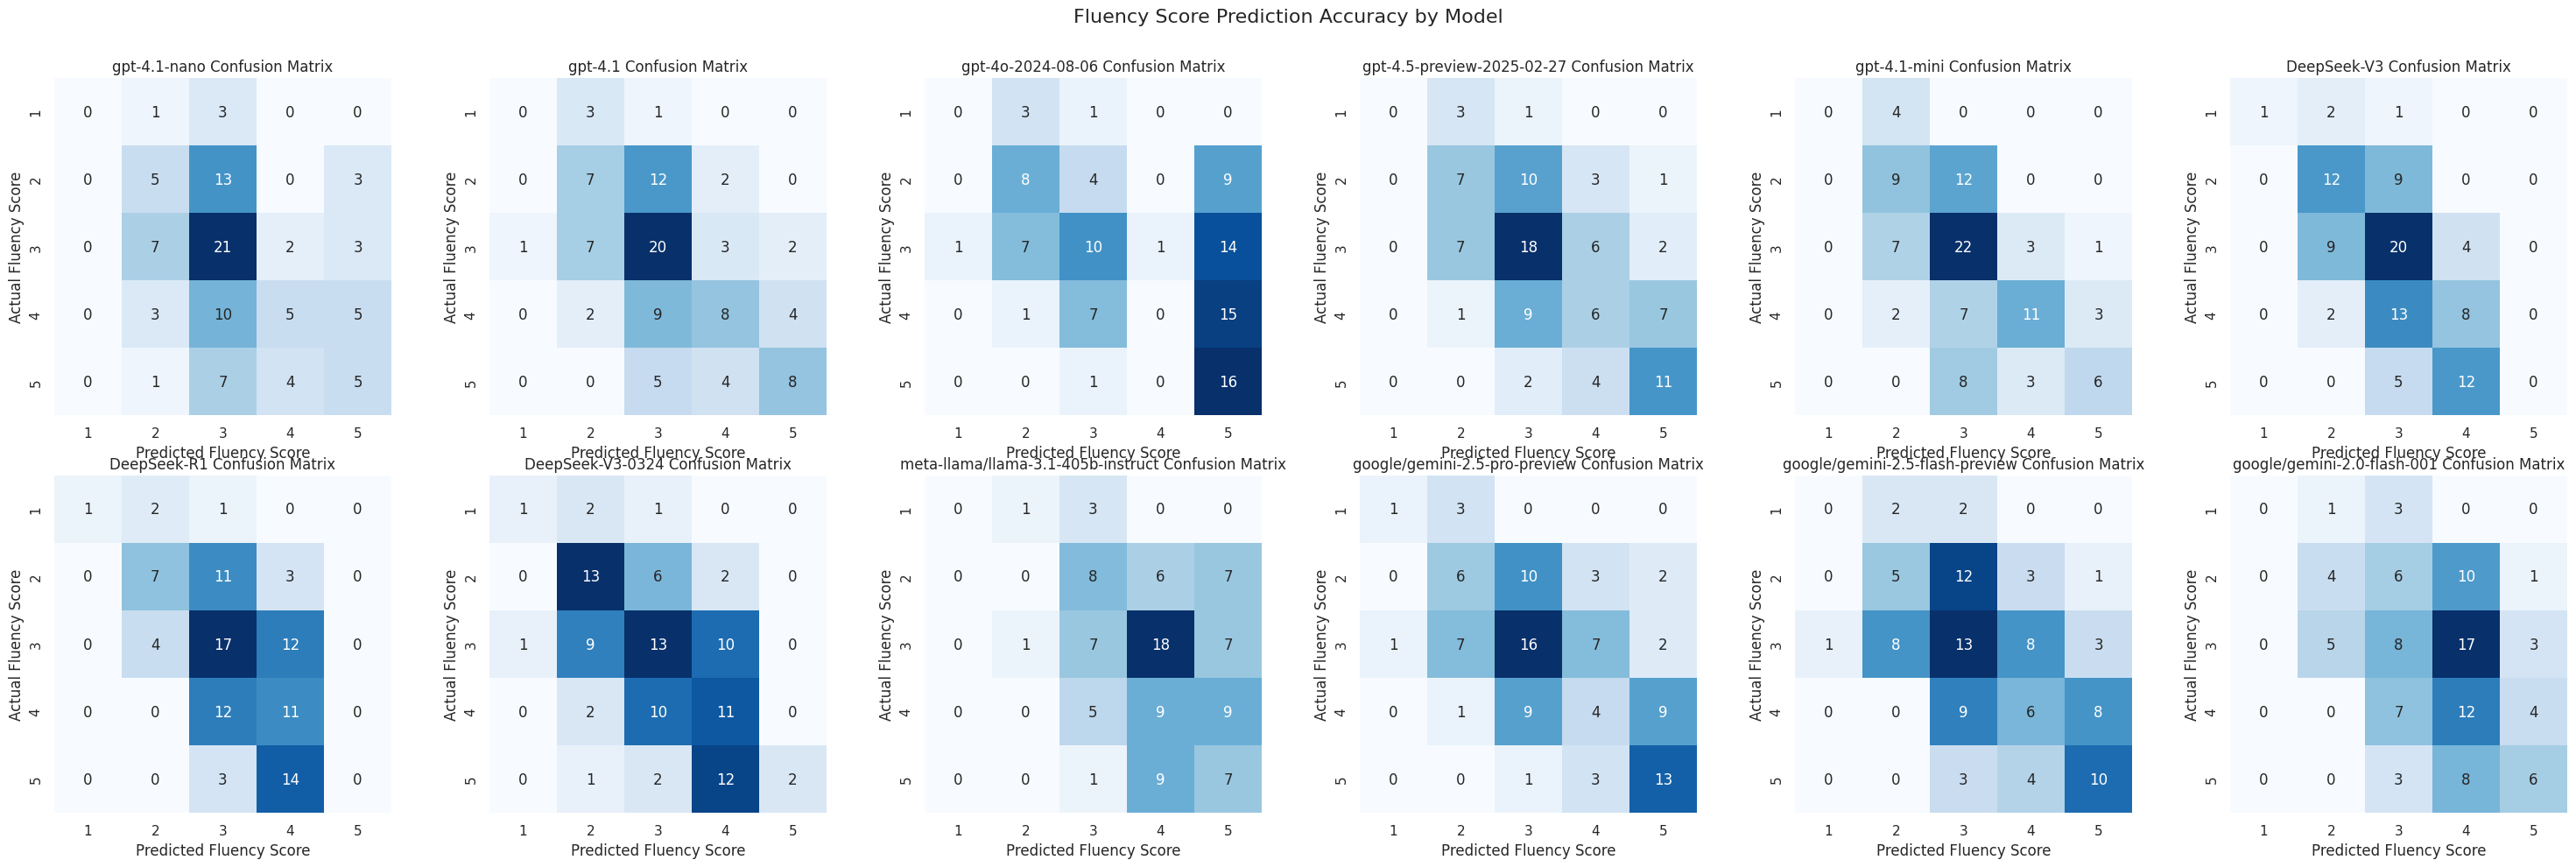

In [13]:
# Create a function to generate confusion matrices in a 2-row layout
def plot_confusion_matrices(df, models):
    # Calculate number of columns needed for each row
    total_models = len(models)
    cols_per_row = (total_models + 1) // 2  # Ceiling division to get columns per row
    
    # Create a figure with 2 rows
    fig, axes = plt.subplots(2, cols_per_row, figsize=(5*cols_per_row, 10))
    axes = axes.flatten()  # Flatten to make indexing easier
    
    # Create each confusion matrix
    for i, model in enumerate(models):
        if i < len(axes):  # Make sure we don't exceed the available axes
            model_col = f"{model}_fluency_score_score"
            
            # Create a confusion matrix (true scores vs. predicted scores)
            conf_matrix = pd.crosstab(
                df['Fluency_score'], 
                df[model_col],
                rownames=['Actual'],
                colnames=['Predicted'],
                dropna=False
            )
            
            # Fill in missing values in the matrix with zeros
            for score in range(1, 6):
                if score not in conf_matrix.index:
                    conf_matrix.loc[score] = 0
                if score not in conf_matrix.columns:
                    conf_matrix[score] = 0
            
            # Sort the indices and columns
            conf_matrix = conf_matrix.sort_index().sort_index(axis=1)
            
            # Plot the confusion matrix
            sns.heatmap(
                conf_matrix, 
                annot=True, 
                fmt='d',
                cmap='Blues',
                ax=axes[i],
                cbar=False,
                square=True
            )
            
            axes[i].set_title(f'{model} Confusion Matrix')
            axes[i].set_xlabel('Predicted Fluency Score')
            axes[i].set_ylabel('Actual Fluency Score')
            
            # Ensure both axes show all values from 1-5
            axes[i].set_xticks(np.arange(0.5, 5.5))
            axes[i].set_yticks(np.arange(0.5, 5.5))
            axes[i].set_xticklabels(range(1, 6))
            axes[i].set_yticklabels(range(1, 6))
    
    # Hide any unused subplots
    for i in range(total_models, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Make room for the suptitle
    plt.suptitle("Fluency Score Prediction Accuracy by Model", fontsize=16)
    
    return fig

# Create the confusion matrices
fig = plot_confusion_matrices(plot_df, models+deepseek_models)
plt.show()

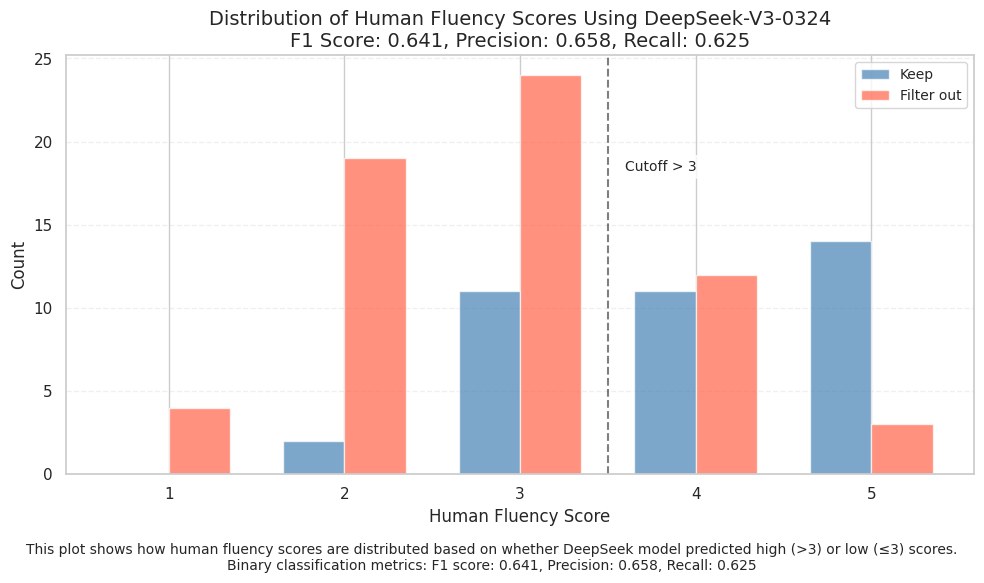

In [92]:
from sklearn.metrics import f1_score, confusion_matrix

# Create a figure with a single subplot
fig, ax = plt.subplots(figsize=(10, 6))

# Get the value counts for each group
high_scores = df.loc[df['DeepSeek-V3-0324_fluency_score_score'] > 3]['Fluency_score'].value_counts().sort_index()
low_scores = df.loc[df['DeepSeek-V3-0324_fluency_score_score'] <= 3]['Fluency_score'].value_counts().sort_index()

# Calculate F1 score
# Create binary masks: true is if human score is > 3, predicted is if model score is > 3
valid_mask = df['DeepSeek-V3-0324_fluency_score_score'].notna() & df['Fluency_score'].notna()
y_true = (df.loc[valid_mask, 'Fluency_score'] > 3).astype(int)
y_pred = (df.loc[valid_mask, 'DeepSeek-V3-0324_fluency_score_score'] > 3).astype(int)

# Calculate F1 score
f1 = f1_score(y_true, y_pred)

# Calculate confusion matrix for additional metrics
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0

# Make sure we have entries for all fluency scores 1-5
for score in range(1, 6):
    if score not in high_scores.index:
        high_scores[score] = 0
    if score not in low_scores.index:
        low_scores[score] = 0

# Sort the Series by index to ensure correct order
high_scores = high_scores.sort_index()
low_scores = low_scores.sort_index()

# Set up the bar positions
x = np.arange(5)  # 5 positions for scores 1-5
width = 0.35  # Width of the bars

# Create the grouped bars
ax.bar(x - width/2, high_scores.values, width, label='Keep', 
       color='steelblue', alpha=0.7)
ax.bar(x + width/2, low_scores.values, width, label='Filter out', 
       color='tomato', alpha=0.7)

# Set the x-ticks to be at bar centers
ax.set_xticks(x)
ax.set_xticklabels(range(1, 6))

# Add labels and title
ax.set_xlabel('Human Fluency Score', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
title = (f'Distribution of Human Fluency Scores Using DeepSeek-V3-0324\n'
         f'F1 Score: {f1:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}')
ax.set_title(title, fontsize=14)

# Add a grid for better readability
ax.grid(axis='y', linestyle='--', alpha=0.3)

# Add legend
ax.legend(fontsize=10, frameon=True)

# Add a horizontal line to indicate the cutoff (score > 3)
ax.axvline(x=2.5, color='black', linestyle='--', alpha=0.5, linewidth=1.5)
ax.text(2.6, ax.get_ylim()[1]*0.75, 'Cutoff > 3', fontsize=10, 
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Add some text explaining the plot
plt.figtext(0.5, 0.01, 
           "This plot shows how human fluency scores are distributed based on whether DeepSeek model predicted high (>3) or low (≤3) scores.\n"
           f"Binary classification metrics: F1 score: {f1:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}",
           wrap=True, horizontalalignment='center', fontsize=10)

# Adjust layout
plt.tight_layout(rect=[0, 0.05, 1, 0.97])

plt.show()

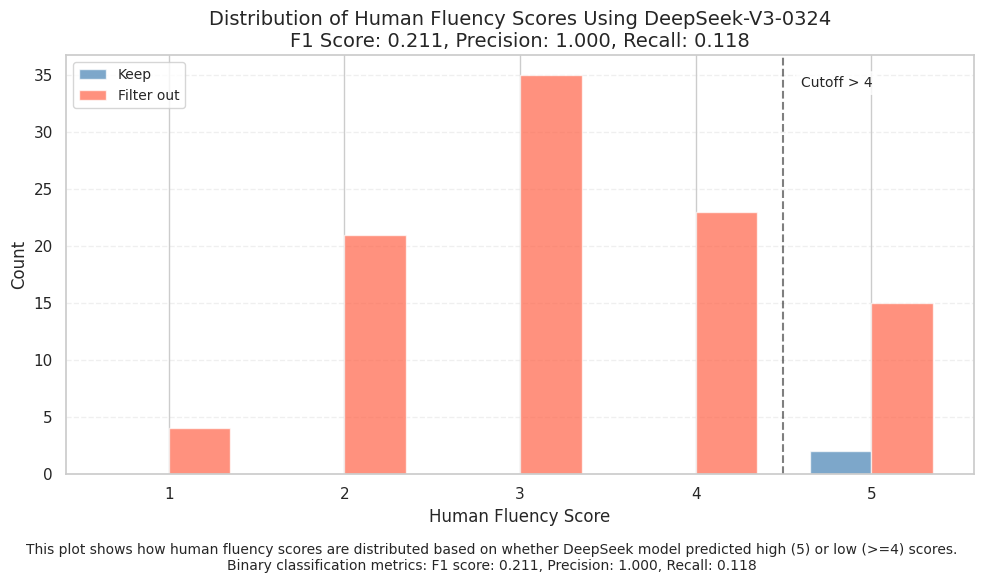

In [87]:
from sklearn.metrics import f1_score, confusion_matrix

# Create a figure with a single subplot
fig, ax = plt.subplots(figsize=(10, 6))

# Get the value counts for each group
high_scores = df.loc[df['DeepSeek-V3-0324_fluency_score_score'] > 4]['Fluency_score'].value_counts().sort_index()
low_scores = df.loc[df['DeepSeek-V3-0324_fluency_score_score'] <= 4]['Fluency_score'].value_counts().sort_index()

# Calculate F1 score
# Create binary masks: true is if human score is > 3, predicted is if model score is > 3
valid_mask = df['DeepSeek-V3-0324_fluency_score_score'].notna() & df['Fluency_score'].notna()
y_true = (df.loc[valid_mask, 'Fluency_score'] > 4).astype(int)
y_pred = (df.loc[valid_mask, 'DeepSeek-V3-0324_fluency_score_score'] > 4).astype(int)

# Calculate F1 score
f1 = f1_score(y_true, y_pred)

# Calculate confusion matrix for additional metrics
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0

# Make sure we have entries for all fluency scores 1-5
for score in range(1, 6):
    if score not in high_scores.index:
        high_scores[score] = 0
    if score not in low_scores.index:
        low_scores[score] = 0

# Sort the Series by index to ensure correct order
high_scores = high_scores.sort_index()
low_scores = low_scores.sort_index()

# Set up the bar positions
x = np.arange(5)  # 5 positions for scores 1-5
width = 0.35  # Width of the bars

# Create the grouped bars
ax.bar(x - width/2, high_scores.values, width, label='Keep', 
       color='steelblue', alpha=0.7)
ax.bar(x + width/2, low_scores.values, width, label='Filter out', 
       color='tomato', alpha=0.7)

# Set the x-ticks to be at bar centers
ax.set_xticks(x)
ax.set_xticklabels(range(1, 6))

# Add labels and title
ax.set_xlabel('Human Fluency Score', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
title = (f'Distribution of Human Fluency Scores Using DeepSeek-V3-0324\n'
         f'F1 Score: {f1:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}')
ax.set_title(title, fontsize=14)

# Add a grid for better readability
ax.grid(axis='y', linestyle='--', alpha=0.3)

# Add legend
ax.legend(fontsize=10, frameon=True)

# Add a horizontal line to indicate the cutoff (score > 3)
ax.axvline(x=3.5, color='black', linestyle='--', alpha=0.5, linewidth=1.5)
ax.text(3.6, ax.get_ylim()[1]*0.95, 'Cutoff > 4', fontsize=10, 
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Add some text explaining the plot
plt.figtext(0.5, 0.01, 
           "This plot shows how human fluency scores are distributed based on whether DeepSeek model predicted high (5) or low (>=4) scores.\n"
           f"Binary classification metrics: F1 score: {f1:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}",
           wrap=True, horizontalalignment='center', fontsize=10)

# Adjust layout
plt.tight_layout(rect=[0, 0.05, 1, 0.97])

plt.show()

In [59]:
# Correlation between human fluency score and model fluency scores (both regular and CoT)
# First, create lists of all possible column names
more_models = list(set(more_models))
regular_score_cols = [f'{m}_fluency_score' for m in more_models]
cot_score_cols = [f'{m}_fluency_score_cot' for m in more_models]

# Filter to only include columns that exist in the DataFrame
existing_regular_cols = [col for col in regular_score_cols if col in df.columns]
existing_cot_cols = [col for col in cot_score_cols if col in df.columns]

# Combine all columns for the final DataFrame
all_cols = ['Fluency_score'] + existing_regular_cols + existing_cot_cols

plot_df_more = df[all_cols].copy() 

# Calculate correlation with human fluency score
print('Correlation between the Fluency score and the models score')
plot_df_more.corr(method='pearson')['Fluency_score']


Correlation between the Fluency score and the models score


Fluency_score                                                                     1.000000
viking-33b-synthetic-magpie-oasst2-epochs-2-batch-128-packed_fluency_score        0.594881
Llama-3.3-70B-Instruct_fluency_score                                              0.596236
gemma-3-27b-it_fluency_score                                                      0.459697
viking-33b-synthetic-magpie-oasst2-epochs-2-batch-128-packed_fluency_score_cot    0.460682
Llama-3.3-70B-Instruct_fluency_score_cot                                          0.637042
gemma-3-27b-it_fluency_score_cot                                                  0.459697
EuroLLM-9B-Instruct_fluency_score_cot                                             0.044921
Name: Fluency_score, dtype: float64

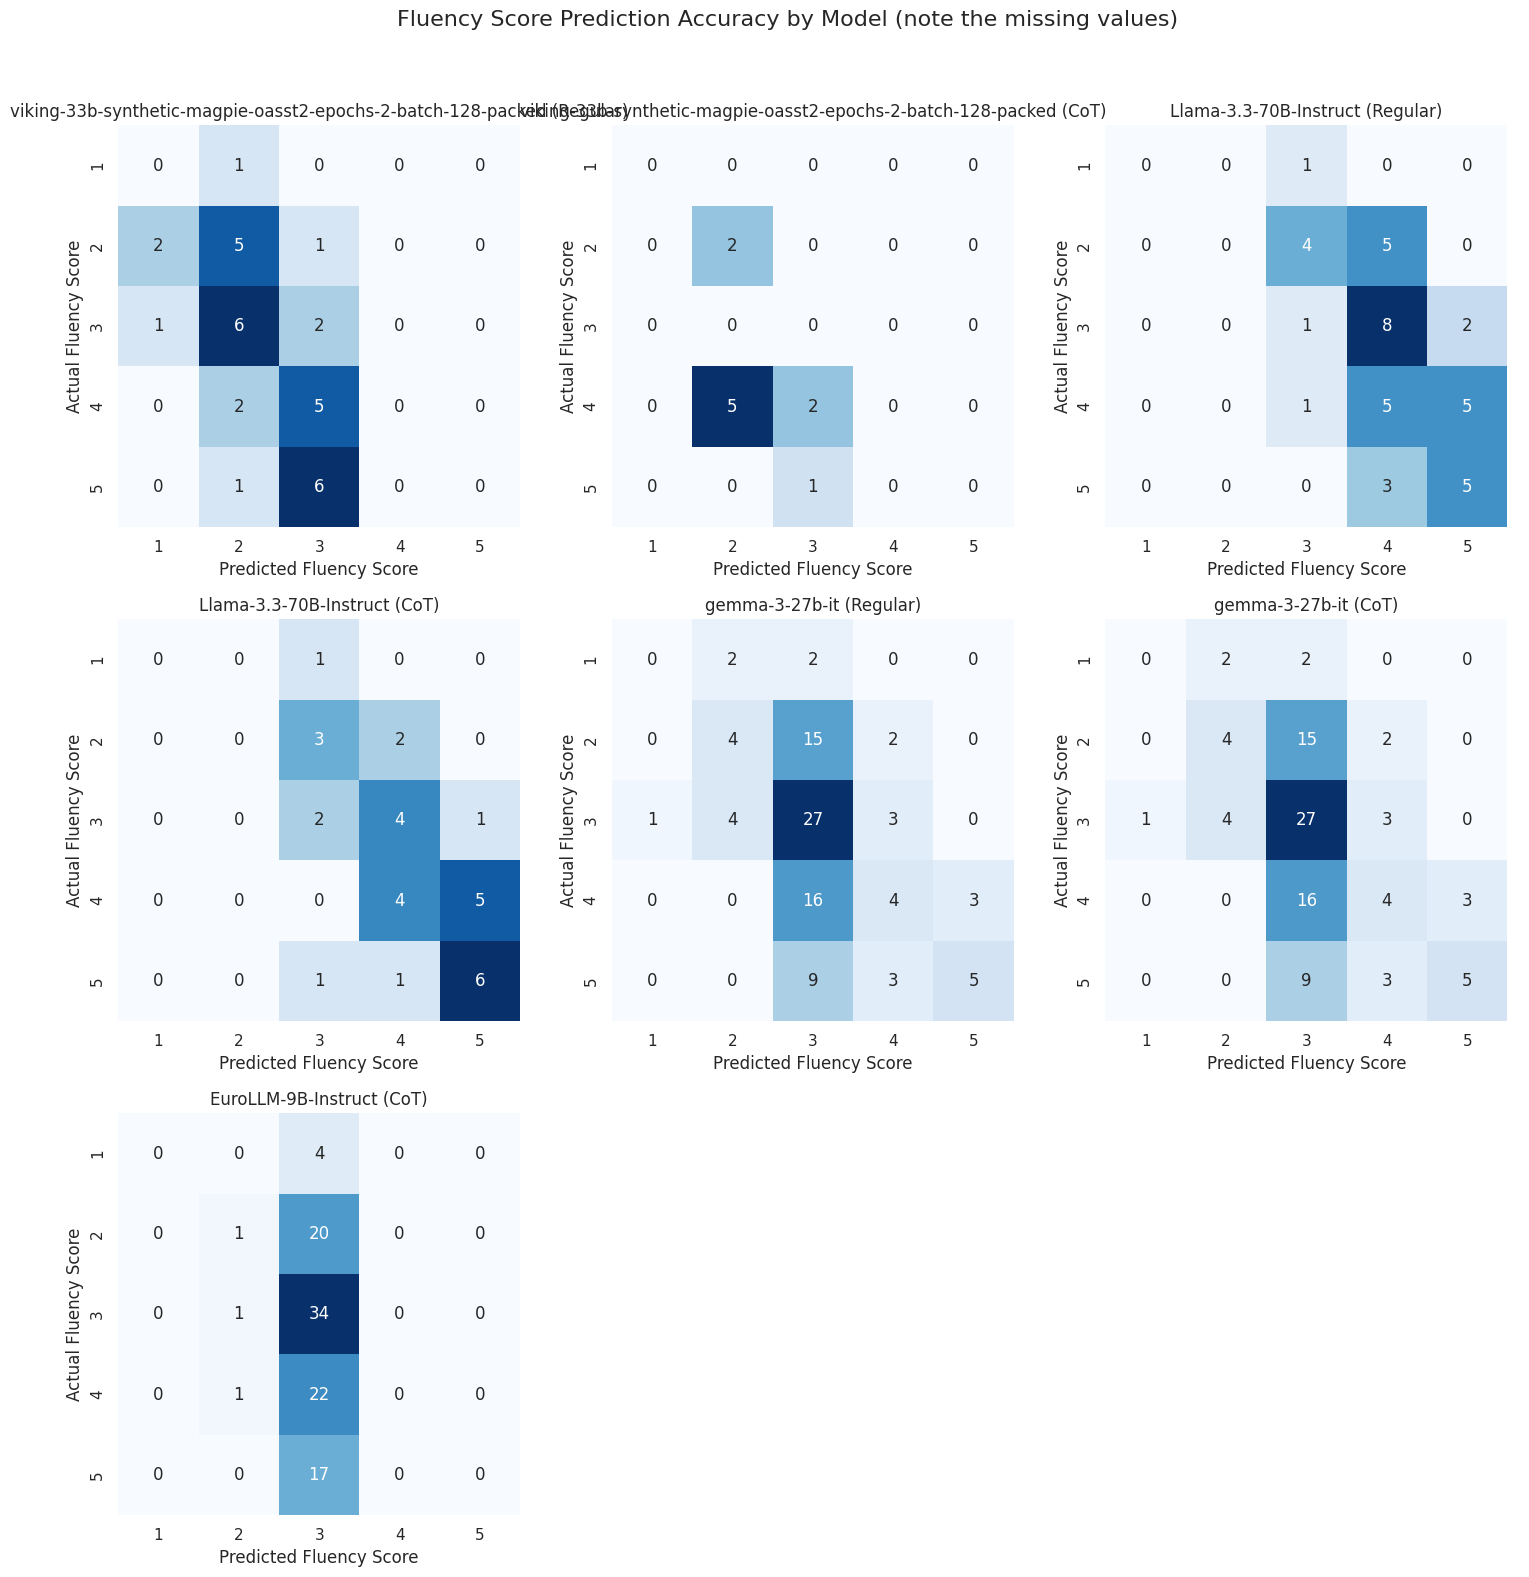

In [62]:
# Create a function to generate confusion matrices
def plot_confusion_matrices(df, models, include_cot=True):
    """
    Generate confusion matrices for model predictions.
    
    Parameters:
    - df: DataFrame containing the data
    - models: List of model names
    - include_cot: Whether to include Chain-of-Thought scores
    """
    # Check which columns actually exist in the DataFrame
    existing_models = []
    existing_cols = {
        'regular': [],
        'cot': []
    }
    
    for model in models:
        regular_col = f"{model}_fluency_score"
        cot_col = f"{model}_fluency_score_cot"
        
        has_regular = regular_col in df.columns
        has_cot = cot_col in df.columns and include_cot
        
        if has_regular or has_cot:
            existing_models.append(model)
            
            if has_regular:
                existing_cols['regular'].append(regular_col)
            
            if has_cot:
                existing_cols['cot'].append(cot_col)
    
    # Calculate how many plots we need
    n_plots = len(existing_cols['regular']) + len(existing_cols['cot'])
    
    if n_plots == 0:
        print("No valid columns found for plotting")
        return None
    
    cols = min(n_plots, 3)  # Maximum 3 plots per row
    rows = (n_plots + cols - 1) // cols  # Calculate needed rows
    
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
    
    # Make axes iterable in all cases
    if n_plots == 1:
        axes = np.array([axes])
    
    axes = axes.flatten()
    
    plot_idx = 0
    
    # Plot regular scores
    for model in existing_models:
        regular_col = f"{model}_fluency_score"
        
        if regular_col in df.columns:
            # Create a confusion matrix (true scores vs. predicted scores)
            conf_matrix = pd.crosstab(
                df['Fluency_score'], 
                df[regular_col],
                rownames=['Actual'],
                colnames=['Predicted'],
                dropna=False
            )
            
            # Fill in missing values in the matrix with zeros
            for score in range(1, 6):
                if score not in conf_matrix.index:
                    conf_matrix.loc[score] = 0
                if score not in conf_matrix.columns:
                    conf_matrix[score] = 0
            
            # Sort the indices and columns
            conf_matrix = conf_matrix.sort_index().sort_index(axis=1)
            
            # Plot the confusion matrix
            sns.heatmap(
                conf_matrix, 
                annot=True, 
                fmt='d',
                cmap='Blues',
                ax=axes[plot_idx],
                cbar=False,
                square=True
            )
            
            axes[plot_idx].set_title(f'{model} (Regular)')
            axes[plot_idx].set_xlabel('Predicted Fluency Score')
            axes[plot_idx].set_ylabel('Actual Fluency Score')
            
            # Ensure both axes show all values from 1-5
            axes[plot_idx].set_xticks(np.arange(0.5, 5.5))
            axes[plot_idx].set_yticks(np.arange(0.5, 5.5))
            axes[plot_idx].set_xticklabels(range(1, 6))
            axes[plot_idx].set_yticklabels(range(1, 6))
            
            plot_idx += 1
        
        # Plot CoT score if it exists
        cot_col = f"{model}_fluency_score_cot"
        if include_cot and cot_col in df.columns:
            # Create a confusion matrix for CoT scores
            conf_matrix_cot = pd.crosstab(
                df['Fluency_score'], 
                df[cot_col],
                rownames=['Actual'],
                colnames=['Predicted'],
                dropna=False
            )
            
            # Fill in missing values in the matrix with zeros
            for score in range(1, 6):
                if score not in conf_matrix_cot.index:
                    conf_matrix_cot.loc[score] = 0
                if score not in conf_matrix_cot.columns:
                    conf_matrix_cot[score] = 0
            
            # Sort the indices and columns
            conf_matrix_cot = conf_matrix_cot.sort_index().sort_index(axis=1)
            
            # Plot the confusion matrix
            sns.heatmap(
                conf_matrix_cot, 
                annot=True, 
                fmt='d',
                cmap='Blues',
                ax=axes[plot_idx],
                cbar=False,
                square=True
            )
            
            axes[plot_idx].set_title(f'{model} (CoT)')
            axes[plot_idx].set_xlabel('Predicted Fluency Score')
            axes[plot_idx].set_ylabel('Actual Fluency Score')
            
            # Ensure both axes show all values from 1-5
            axes[plot_idx].set_xticks(np.arange(0.5, 5.5))
            axes[plot_idx].set_yticks(np.arange(0.5, 5.5))
            axes[plot_idx].set_xticklabels(range(1, 6))
            axes[plot_idx].set_yticklabels(range(1, 6))
            
            plot_idx += 1
    
    # Hide any unused subplots
    for i in range(plot_idx, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.suptitle("Fluency Score Prediction Accuracy by Model (note the missing values)", fontsize=16, y=1.05)
    
    return fig

# Create the confusion matrices for both regular and CoT scores
fig = plot_confusion_matrices(plot_df_more, more_models)
plt.show()

# Editing
Can models edit a dysfluent sentence to a fluent one?

- GPT 4.1 edit the sentences reasonably well and preserve the order between mini and nano
- cot does not make a difference
- GPT 4.5 is better is 4.1, but sometimes do not follow instructions and returns an English sentence

In [7]:
def create_edit_prompt(translation, model, max_completion_tokens, cot=False):

    # Construct prompt
    prompt_no_cot = f"""
    Edit this sentence such that it becomes fluent to a native speaker. Make all the necessary edits, but nothing more than that.
    Return the edited sentence between these tags: <edited_sentence> </edited_sentence>
    <original_sentence>{translation}</original_sentence>
    """
    
    prompt_cot = f"""
    List all the spans that are not fully fluent to a native speaker, whether it be lexical, grammatical, idiomatic, or cultural knowledge errors between these tags: <dysfluent_span> </dysfluent_span>
    Edit this sentence such that it becomes fluent to a native speaker. Make all the necessary edits, but nothing more than that.
    Return the edited sentence between these tags <edited_sentence> </edited_sentence>
    <original_sentence>{translation}</original_sentence>
    """
    if cot:
        prompt = prompt_cot
    else:
        prompt = prompt_no_cot
    
     # Get response from LLM
    response = call_litellm(prompt, model=model, max_completion_tokens=max_completion_tokens)
    
    # Extract just the numbers from the response
    try:
        edited_sentence = BeautifulSoup(response, 'html.parser').find('edited_sentence').text 
    except AttributeError:
        print(response)
        edited_sentence = None

    return edited_sentence
    

In [8]:
models = ['gpt-4.1-nano', 'gpt-4.1', 'gpt-4o-2024-08-06', 'gpt-4.5-preview-2025-02-27', 'gpt-4.1-mini']
for model in models:
    #df[f'{model}_edited_sentence_cot'] = df.translations.progress_map(lambda x: create_edit_prompt(translation=x, model=model, max_completion_tokens=1000, cot=True))
    df[f'{model}_edited_sentence'] = df.translations.progress_map(lambda x: create_edit_prompt(translation=x, model=model, max_completion_tokens=1000, cot=False))

  0%|          | 0/100 [00:00<?, ?it/s]

  6%|▌         | 6/100 [00:03<00:58,  1.60it/s]


KeyboardInterrupt: 

In [19]:
# Add all corrections for the source sentence to a column named 'references' to get multiple references for each source sentence

grouped = df.groupby('source_sentence')['Correction'].apply(list).reset_index()
grouped = grouped.rename(columns={'Correction': 'references'})

# If you want to merge this back to the original df to add the references column
# First create a dictionary mapping source_sentence to references
reference_dict = dict(zip(grouped['source_sentence'], grouped['references']))

# Then add a new column to the original df
df['references'] = df['source_sentence'].map(reference_dict)

#Also add the target sentence

df['references'] = df.apply(
     lambda row: row['references'] + [row['target_sentence']] 
     if isinstance(row['references'], list) and row['target_sentence'] not in row['references']
     else [row['target_sentence']] if not isinstance(row['references'], list)
     else row['references'],
     axis=1
 )


In [29]:
# read in results from files - only run once
edit_results_files =[f for f in glob.glob('../results/*.jsonl') if '_edit' in f]
more_models = []
for fname in edit_results_files:
    modelname = fname.split('/')[-1].split('_')[0]
    more_models.append(modelname)
    one = pd.read_json(fname, lines='True')
    edit_col = 'open_model_task_col'
    if '_cot' in fname:
        new_colname = modelname+'_edited_sentence_cot'
    else:
        new_colname = modelname+'_edited_sentence'
    print(new_colname)
    one[new_colname] = one[edit_col].progress_map(lambda x:  BeautifulSoup(str(x), 'html.parser').find('edited_sentence').text.strip() if BeautifulSoup(str(x), 'html.parser').find('edited_sentence') else None)
    df[new_colname] = one[new_colname]

viking-33b-synthetic-magpie-oasst2-epochs-2-batch-128-packed_edited_sentence_cot


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 2269.69it/s]


EuroLLM-9B-Instruct_edited_sentence


100%|██████████| 100/100 [00:00<00:00, 2904.58it/s]


viking-33b-synthetic-magpie-oasst2-epochs-2-batch-128-packed_edited_sentence


100%|██████████| 100/100 [00:00<00:00, 4022.54it/s]


gemma-3-27b-it_edited_sentence_cot


100%|██████████| 100/100 [00:00<00:00, 12772.71it/s]


Llama-3.3-70B-Instruct_edited_sentence_cot


100%|██████████| 100/100 [00:00<00:00, 2150.66it/s]


EuroLLM-9B-Instruct_edited_sentence_cot


100%|██████████| 100/100 [00:00<00:00, 2575.40it/s]


gemma-3-27b-it_edited_sentence_cot


100%|██████████| 100/100 [00:00<00:00, 1477.72it/s]


EuroLLM-9B-Instruct_edited_sentence_cot


100%|██████████| 100/100 [00:00<00:00, 13195.86it/s]


Llama-3.3-70B-Instruct_edited_sentence


100%|██████████| 100/100 [00:00<00:00, 4005.37it/s]


gemma-3-27b-it_edited_sentence


100%|██████████| 100/100 [00:00<00:00, 4079.47it/s]


In [30]:
# calculate the BLEU score
models = ['gpt-4.1-nano', 'gpt-4.1', 'gpt-4o-2024-08-06', 'gpt-4.5-preview-2025-02-27', 'gpt-4.1-mini']
bleu = BLEU
for model in models:
    print(model)
    df[f'{model}_cot_BLEU'] = df.progress_apply(lambda x: sacrebleu.compute(predictions=[x[f'{model}_edited_sentence_cot']], references=[x['references']])['score'], axis=1)
    df[f'{model}_BLEU'] = df.progress_apply(lambda x: sacrebleu.compute(predictions=[x[f'{model}_edited_sentence']], references=[x['references']])['score'], axis=1)
df['translation_BLEU'] = df.progress_apply(lambda x: sacrebleu.compute(predictions=[x[f'translations']], references=[x['references']])['score'], axis=1)

gpt-4.1-nano


100%|██████████| 100/100 [00:02<00:00, 45.91it/s]


gpt-4.1


100%|██████████| 100/100 [00:02<00:00, 45.67it/s]


gpt-4o-2024-08-06


100%|██████████| 100/100 [00:02<00:00, 43.90it/s]


gpt-4.5-preview-2025-02-27


100%|██████████| 100/100 [00:02<00:00, 43.93it/s]


gpt-4.1-mini


100%|██████████| 100/100 [00:02<00:00, 45.34it/s]


In [31]:
# calculate the BLEU score

bleu = BLEU
for model in more_models:
    print(model)
    df[f'{model}_cot_BLEU'] = df.progress_apply(
        lambda x: sacrebleu.compute(
            predictions=[x[f'{model}_edited_sentence_cot']], 
            references=[x['references']]
        )['score'] if pd.notna(x[f'{model}_edited_sentence_cot']) else None, 
        axis=1
    )

    df[f'{model}_BLEU'] = df.progress_apply(
        lambda x: sacrebleu.compute(
            predictions=[x[f'{model}_edited_sentence']], 
            references=[x['references']]
        )['score'] if pd.notna(x[f'{model}_edited_sentence']) else None, 
        axis=1
    )

viking-33b-synthetic-magpie-oasst2-epochs-2-batch-128-packed


100%|██████████| 100/100 [00:02<00:00, 43.95it/s]


EuroLLM-9B-Instruct


100%|██████████| 100/100 [00:02<00:00, 44.35it/s]


viking-33b-synthetic-magpie-oasst2-epochs-2-batch-128-packed


100%|██████████| 100/100 [00:02<00:00, 44.48it/s]


gemma-3-27b-it


100%|██████████| 100/100 [00:02<00:00, 43.71it/s]


Llama-3.3-70B-Instruct


100%|██████████| 100/100 [00:02<00:00, 42.64it/s]


EuroLLM-9B-Instruct


100%|██████████| 100/100 [00:02<00:00, 44.99it/s]


gemma-3-27b-it


100%|██████████| 100/100 [00:02<00:00, 45.07it/s]


EuroLLM-9B-Instruct


100%|██████████| 100/100 [00:02<00:00, 44.85it/s]


Llama-3.3-70B-Instruct


100%|██████████| 100/100 [00:02<00:00, 45.33it/s]


gemma-3-27b-it


100%|██████████| 100/100 [00:02<00:00, 45.88it/s]


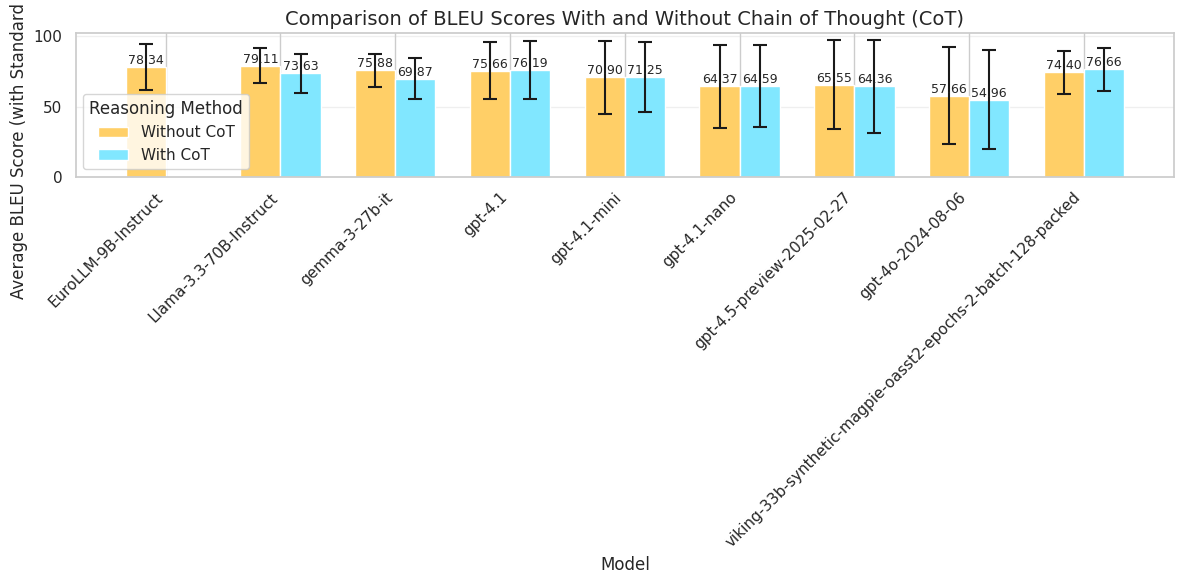

In [32]:
def plot_bleu_comparison(df):
    # Extract model names by looking at column names
    columns = df.columns
    model_names = set(models+more_models)
    
    # Sort models alphabetically for consistent ordering
    models_list = sorted(list(model_names))
    
    # Prepare data for plotting
    plot_data = []
    
    for model in models_list:  # Use models_list here to maintain order
        # Get mean and std BLEU scores (with and without CoT)
        bleu_no_cot_mean = df[f'{model}_BLEU'].mean()
        bleu_no_cot_std = df[f'{model}_BLEU'].std()
        
        bleu_cot_mean = df[f'{model}_cot_BLEU'].mean()
        bleu_cot_std = df[f'{model}_cot_BLEU'].std()
        
        # Add to data list
        plot_data.append({
            'Model': model, 
            'Method': 'Without CoT', 
            'BLEU': bleu_no_cot_mean,
            'BLEU_std': bleu_no_cot_std
        })
        plot_data.append({
            'Model': model, 
            'Method': 'With CoT', 
            'BLEU': bleu_cot_mean,
            'BLEU_std': bleu_cot_std
        })
    
    # Create DataFrame for plotting
    plot_df = pd.DataFrame(plot_data)
    
    # Create plot
    plt.figure(figsize=(12, 6))
    
    # Create custom barplot with error bars
    ax = plt.subplot(111)
    
    # Get unique methods and models for positioning
    methods = plot_df['Method'].unique()
    
    # Set width of bars
    bar_width = 0.35
    
    # Set positions on x-axis
    positions = np.arange(len(models_list))
    
    # Plot bars with error bars
    for i, method in enumerate(methods):
        method_data = plot_df[plot_df['Method'] == method]
        
        # Align bars side by side
        offset = (i - 0.5) * bar_width
        
        # Get colors from viridis palette
        colors = plt.cm.managua(np.linspace(0, 1, len(methods)))
        
        # Ensure method_data is sorted in the same order as models_list
        method_data = method_data.set_index('Model').loc[models_list].reset_index()
        
        # Plot bars with error bars
        bars = ax.bar(
            positions + offset, 
            method_data['BLEU'], 
            width=bar_width,
            yerr=method_data['BLEU_std'],
            label=method,
            color=colors[i],
            capsize=5,  # Cap width for error bars
            error_kw={'elinewidth': 1.5, 'capthick': 1.5}  # Error bar style
        )
        
        # Add value labels on top of bars
        for j, bar in enumerate(bars):
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width()/2.,
                height + 0.01,
                f'{height:.2f}',
                ha='center', 
                va='bottom',
                fontsize=9
            )
    
    # Set x-ticks at the center of grouped bars
    ax.set_xticks(positions)
    ax.set_xticklabels(models_list, rotation=45, ha='right')
    
    # Enhance the plot
    plt.title('Comparison of BLEU Scores With and Without Chain of Thought (CoT)', fontsize=14)
    plt.xlabel('Model', fontsize=12)
    plt.ylabel('Average BLEU Score (with Standard Deviation)', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    
    # Improve legend
    plt.legend(title='Reasoning Method', loc='best')
    
    plt.tight_layout()
    return plt.gcf(), plot_df

# Call the function
fig, plot_df = plot_bleu_comparison(df)
plt.show()

## Score the edits

In [23]:
import ast
import json
from openai import OpenAI
from tqdm import tqdm
import time
import re

def extract_dict_from_code_block(text, max_retries=3):
    """
    Extract a Python dictionary from text that might contain a code block.
    Makes multiple attempts with different parsing strategies.
    
    Args:
        text: String that may contain a Python dictionary in a code block
        max_retries: Number of times to retry with different parsing strategies
        
    Returns:
        The extracted dictionary or raises an exception if all attempts fail
    """
    # List of cleaning strategies to try
    strategies = [
        # Strategy 1: Basic code block cleaning
        lambda t: t.replace('```python', '').replace('```', '').strip(),
        # Strategy 2: Find content between curly braces
        lambda t: '{' + t.split('{', 1)[1].split('}', 1)[0] + '}' if '{' in t and '}' in t else t,
        # Strategy 3: Extract just the dictionary part using more aggressive pattern matching
        lambda t: re.search(r'\{[^}]*\}', t).group(0) if re.search(r'\{[^}]*\}', t) else t
    ]
    
    # Try each strategy
    for strategy in strategies:
        try:
            cleaned_text = strategy(text)
            return ast.literal_eval(cleaned_text)
        except (SyntaxError, ValueError, IndexError, AttributeError):
            continue
    
    # If we get here, all strategies failed
    raise ValueError(f"Failed to extract a valid dictionary from: {text[:100]}...")

def openai_get_response_with_retries(prompt, model, max_completion_tokens=1000, api_key=None, 
                                     temperature=0.1, max_retries=3, retry_delay=2):
    """
    Get a response from the API with retry logic to handle failures and ensure a valid dictionary is returned
    """
    client = OpenAI(
        base_url="https://openrouter.ai/api/v1",
        api_key=api_key
    )
    
    for attempt in range(max_retries):
        try:
            completion = client.chat.completions.create(
                model=model,
                temperature=temperature,
                max_tokens=max_completion_tokens,
                messages=[
                    {"role": "user", "content": prompt}
                ]
            )
            response_text = completion.choices[0].message.content

            # Try to extract a dictionary from the response
            try:
                result_dict = extract_dict_from_code_block(response_text)
                return response_text  # Return the original response if successful
            except Exception as e:
                print(f"Attempt {attempt+1}: Failed to parse response as dictionary: {str(e)}")
                
                # On failure, modify the prompt to be more explicit about wanting a dictionary
                if attempt < max_retries - 1:
                    prompt = (f"Your previous response could not be parsed as a valid Python dictionary. "
                             f"Please provide ONLY a valid Python dictionary like {{1: 5, 2: 4, ...}} "
                             f"with no additional text. Original request: {prompt}")
                    time.sleep(retry_delay)  # Wait before retrying
        
        except Exception as e:
            print(f"API call error on attempt {attempt+1}: {str(e)}")
            if attempt < max_retries - 1:
                time.sleep(retry_delay)  # Wait before retrying
    
    # If we've exhausted all retries, raise an exception
    raise ValueError("Failed to get a valid dictionary response after multiple attempts")

# Updated scoring function for edited sentences
edited_sentence_cols = [d for d in df.columns if '_edited_sentence' in d]
temp = 0.1

for col in tqdm(edited_sentence_cols):
    tgt_model = col.split('_')[0]
    model = 'deepseek/deepseek-chat-v3-0324:free'
    try:
        # Use the retry-enabled function
        dict_str = openai_get_response_with_retries(
            create_batch_scoring(df[col]),
            model=model, 
            max_completion_tokens=1000, 
            api_key=os.environ['LLAMA_API_KEY'], 
            temperature=temp
        )
        # Extract dictionary and create DataFrame
        extracted_dict = extract_dict_from_code_block(dict_str)
        df[f'{tgt_model}-DS_fluency_score'] = pd.DataFrame.from_dict(extracted_dict, orient='index')
        print(tgt_model, df[f'{tgt_model}-DS_fluency_score'].mean())
        
        # Save progress after each successful model
        df.to_json('/scratch/project_462000353/maribarr/translation_quality/data/Flores200_dev.jsonl', 
                   lines=True, orient='records')
        
    except Exception as e:
        print(f"Error processing {col}: {str(e)}")
        continue

  6%|▌         | 1/18 [00:13<03:56, 13.92s/it]

gpt-4.1-nano 3.46


 11%|█         | 2/18 [00:26<03:25, 12.86s/it]

gpt-4.1 3.79


 17%|█▋        | 3/18 [00:45<03:58, 15.88s/it]

gpt-4o-2024-08-06 4.23
Attempt 1: Failed to parse response as dictionary: Failed to extract a valid dictionary from: ...


 22%|██▏       | 4/18 [01:14<04:54, 21.05s/it]

gpt-4.5-preview-2025-02-27 4.49


 28%|██▊       | 5/18 [01:30<04:11, 19.37s/it]

gpt-4.1-mini 3.53
Attempt 1: Failed to parse response as dictionary: Failed to extract a valid dictionary from: ...


 33%|███▎      | 6/18 [01:55<04:13, 21.14s/it]

gpt-4.1-nano 3.55


 39%|███▉      | 7/18 [03:13<07:18, 39.88s/it]

gpt-4.1 2.0


 44%|████▍     | 8/18 [03:38<05:50, 35.06s/it]

gpt-4o-2024-08-06 4.14


 50%|█████     | 9/18 [03:55<04:25, 29.48s/it]

gpt-4.5-preview-2025-02-27 4.76
Attempt 1: Failed to parse response as dictionary: Failed to extract a valid dictionary from: ...
Attempt 2: Failed to parse response as dictionary: Failed to extract a valid dictionary from: ...


 56%|█████▌    | 10/18 [04:23<03:50, 28.76s/it]

gpt-4.1-mini 2.85


 61%|██████    | 11/18 [04:41<02:58, 25.48s/it]

viking-33b-synthetic-magpie-oasst2-epochs-2-batch-128-packed 3.61


 67%|██████▋   | 12/18 [05:09<02:38, 26.36s/it]

EuroLLM-9B-Instruct 3.45
Attempt 1: Failed to parse response as dictionary: Failed to extract a valid dictionary from: ...
Attempt 2: Failed to parse response as dictionary: Failed to extract a valid dictionary from: ...


 72%|███████▏  | 13/18 [05:40<02:18, 27.68s/it]

Attempt 3: Failed to parse response as dictionary: Failed to extract a valid dictionary from: ...
Error processing viking-33b-synthetic-magpie-oasst2-epochs-2-batch-128-packed_edited_sentence: Failed to get a valid dictionary response after multiple attempts


 78%|███████▊  | 14/18 [05:55<01:35, 23.94s/it]

gemma-3-27b-it 3.94


 83%|████████▎ | 15/18 [06:19<01:12, 24.10s/it]

Llama-3.3-70B-Instruct 4.04


 89%|████████▉ | 16/18 [06:34<00:42, 21.23s/it]

EuroLLM-9B-Instruct 1.0
Attempt 1: Failed to parse response as dictionary: Failed to extract a valid dictionary from: ...


 94%|█████████▍| 17/18 [07:11<00:26, 26.12s/it]

Llama-3.3-70B-Instruct 3.78
Attempt 1: Failed to parse response as dictionary: Failed to extract a valid dictionary from: ...


100%|██████████| 18/18 [07:38<00:00, 25.46s/it]

gemma-3-27b-it 3.33


In [ ]:
df.rename(columns={'deepseek/deepseek-chat-v3-0324:free-0.01_fluency_score_score': 'DeepSeek_fluency_score_on_translations',
                   'Fluency_score': 'Human_fluency_score'}, inplace=True)
DS_cols = [d for d in df.columns if 'DS_fluency_score' in d]+['Human_fluency_score', 'DeepSeek_fluency_score_on_translation']
# reordering columns
DS_cols = [
     'gpt-4.5-preview-2025-02-27-DS_fluency_score',
 'gpt-4.1-DS_fluency_score',
  'gpt-4.1-mini-DS_fluency_score',
  'gpt-4.1-nano-DS_fluency_score',
 'gpt-4o-2024-08-06-DS_fluency_score',
 'viking-33b-synthetic-magpie-oasst2-epochs-2-batch-128-packed-DS_fluency_score',
 'EuroLLM-9B-Instruct-DS_fluency_score',
 'gemma-3-27b-it-DS_fluency_score',
 'Llama-3.3-70B-Instruct-DS_fluency_score',
 'Fluency_score',
 'DeepSeek_fluency_score']

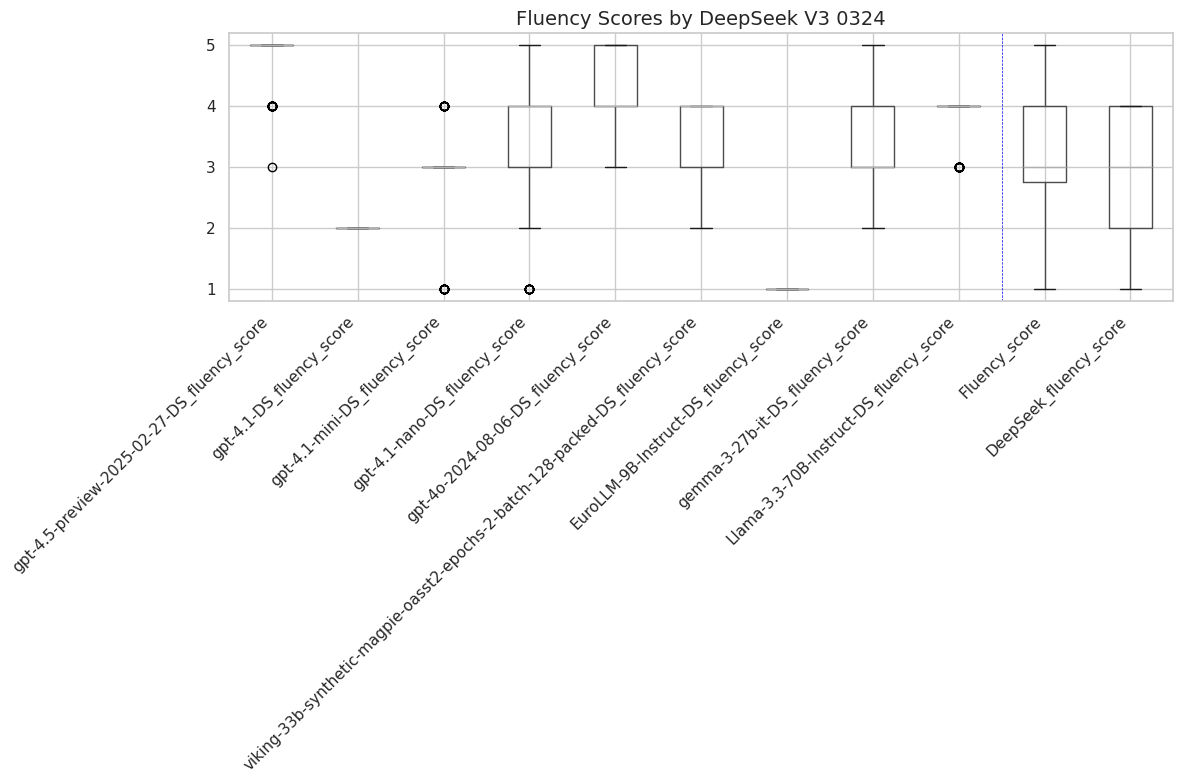

In [38]:
# Create a figure and axis to have more control over the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Create the boxplot on the axis
df[DS_cols].boxplot(ax=ax)

# Add a vertical dotted line to separate the last two boxes from the rest
# The x-position should be between box positions 8 and 9 (since boxes are at 1, 2, 3, etc.)
ax.axvline(x=9.5, color='blue', linestyle='--', linewidth=0.5)

# Rotate the x-tick labels 45 degrees and align them properly
plt.xticks(rotation=45, ha='right')

# Add a title and adjust layout to ensure labels fit
plt.title('Fluency Scores by DeepSeek V3 0324', fontsize=14)

# Add annotation to explain the separation
#ax.text(9.5, ax.get_ylim()[0] + 0.2, 'Human vs. Model Scores', 
#        rotation=90, va='bottom', ha='center', color='black',)

# Adjust layout to ensure labels fit
plt.tight_layout()

# Show the plot
plt.show()

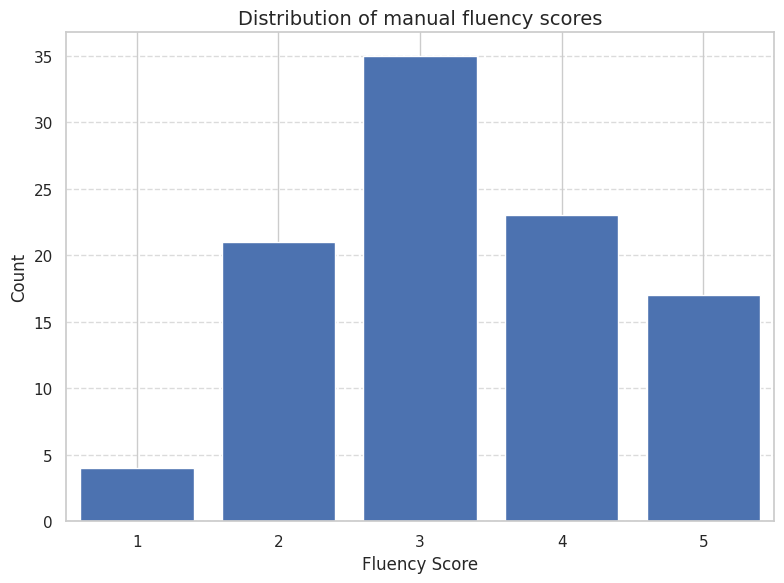

In [54]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Create histogram with specific bins to match fluency scores
ax.hist(df['Fluency_score'], bins=5, range=(0.5, 5.5), align='mid', rwidth=0.8)

# Set x-axis to show only whole numbers 1-5
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_xlim(0.5, 5.5)

# Add title and labels
ax.set_title('Distribution of manual fluency scores', fontsize=14)
ax.set_ylabel('Count', fontsize=12)
ax.set_xlabel('Fluency Score', fontsize=12)

# Add grid for better readability
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()